In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict


In [29]:
import importlib
import Clustering, Forecasting
importlib.reload(Clustering)
importlib.reload(Forecasting)

<module 'Forecasting' from '/home/grinenko/anna/time_series/Forecasting.py'>

In [30]:
data = pd.read_csv("DataSet2.csv", sep=";")#, parse_dates=['Timestamp']) #, nrows=10)

In [31]:
columns = data.columns

In [32]:
K = 5
df = data.groupby(data.index // K).mean() #усреднение
df_np = df.to_numpy()

In [33]:
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError, MeanAbsolutePercentageError
from sklearn.metrics import mean_absolute_error as mae
mase = MeanAbsoluteScaledError(multioutput='raw_values')
mase_uni = MeanAbsoluteScaledError(multioutput='uniform_average')
mape = MeanAbsolutePercentageError(multioutput='raw_values')
# mae = MeanAbsoluteError()


#if ‘raw_values’, returns a full set of errors in case of multioutput input. If ‘uniform_average’, errors of all outputs are averaged with uniform weight.

In [34]:
dataset = df_np[:, :]
# dataset = np.concatenate((dataset[:, :8], dataset[:, 9:]), axis=1)
dataset.shape

(408096, 67)

**__Отбор признаков на минималках__**

In [35]:
#удаление константных
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(0.001)
dataset1 = selector.fit_transform(dataset) 
dataset1.shape

(408096, 65)

In [36]:
set(range(67)) - set(selector.get_feature_names_out(input_features=np.arange(dataset.shape[-1])))

{8, 14}

In [37]:
print(np.unique(dataset[:, 14]))

[0.]


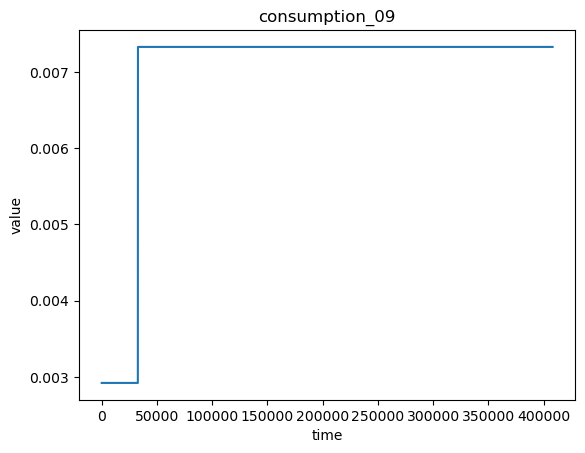

In [38]:
# plt.plot(dataset[:, 8], color="green")
plt.plot(np.concatenate((dataset[:32714, 8], dataset[32717:, 8])))
plt.title("consumption_09")
plt.xlabel("time")
plt.ylabel("value")
plt.show()

In [39]:
values = np.unique(dataset[:, 8])
print(values)
print([len(np.argwhere(dataset[:, 8] == val)) for val in values])
print(f"Изменение только в {np.argwhere(dataset[1:, 8] - dataset[:-1, 8])}")

[0.00292  0.00733  0.754974 1.658794 1.956544]
[32714, 375379, 1, 1, 1]
Изменение только в [[32713]
 [32714]
 [32715]
 [32716]]


**Эти датчики пока выкинем из-за константности: ** 

8: consumption_09

14 : consumption_07 


In [40]:
columns[15], columns[9]

('consumption_07', 'consumption_09')

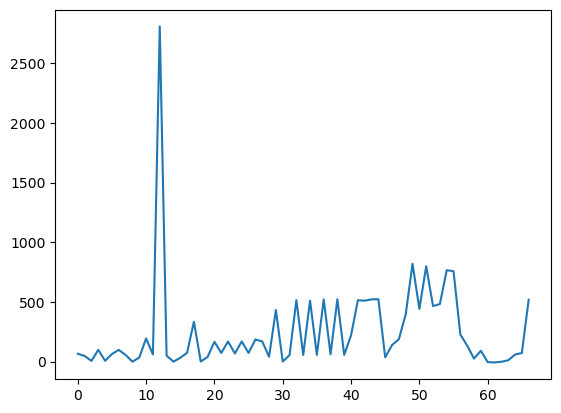

In [41]:
plt.plot(dataset[7])    

In [42]:
# from scipy.signal import correlate
# a = np.array([np.sin(x + 1) for x in range(10)])
# b = np.array([np.sin(x + 2) for x in range(10)])
# c = correlate(a, b, mode="full") #mode='same'
# plt.plot(a, label="a")
# plt.plot(b, label="b")
# plt.plot(c, label="correlation")
# plt.legend()
# c.shape

In [55]:
dataset = dataset1
dataset.shape

(408096, 65)

In [56]:
#еще не поняла до конца
from sklearn.feature_selection import f_regression
for i in range(1):
    X = np.concatenate((dataset[:, :i], dataset[:, i + 1:]), axis=1)
    y = dataset[:, i]
    res = f_regression(X, y)
    print(res[0].shape)
    # plt.plot(res[0], label="f_statistics")
    # # plt.plot(res[1], label="p_values")
    # plt.legend()
    # plt.show()

(64,)


In [57]:
# a = np.array([np.sin(x) for x in range(10)])
# b = np.array([np.sin(x + 1) + 1 for x in range(10)])
# c = np.array([np.sin(x + 0.1) for x in range(10)])

# f_regression(a[:, None], b), f_regression(a[:, None], c)

**Прогнозирование**

In [58]:
dataset = dataset1
dataset.shape

(408096, 65)

In [59]:
from sklearn.model_selection import train_test_split
window_sizes_for_clustering = 10
# X, y = dataset[:-window_sizes_for_clustering, ...], dataset[window_sizes_for_clustering:, ...]
# X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
n_split = round(0.2 * dataset.shape[0])
dataset_train, dataset_test = dataset[:-n_split, ...], dataset[-n_split:, ...]

In [60]:
dataset_train.shape, dataset_test.shape

((326477, 65), (81619, 65))

In [138]:
window_sizes_for_clustering = [1, 5, 10, 15] #[1, 3, 5, 10, 15]
Ns_clusters = [5, 7, 9, 11]#[2, 5, 7, 9, 11, 13]


In [139]:
import importlib
import Clustering, Forecasting
importlib.reload(Clustering)
importlib.reload(Forecasting)

<module 'Forecasting' from '/home/grinenko/anna/time_series/Forecasting.py'>

In [140]:
# Ns_clusters = [2]
# window_sizes_for_clustering = [7]

In [141]:
# N, M, Q = 100, 100, 2
# dataset_train = np.column_stack([[np.sin(x / 40) for x in range(N)], [0.01 + np.sin(x / 20) for x in range(N)]])
# # dataset_train = np.array([np.sin(x / 10000) for x in range(N)])[:, None]
# # dataset_train = np.column_stack(([np.sqrt(x / 10) for x in range(N)], [x + ])
# dataset_test = np.column_stack([[np.sin(x / 30) for x in range(M)], [0.01 + np.sin(x / 30)*1.01 for x in range(M)]])

In [142]:
dataset_train.shape

(326477, 65)

In [143]:
np.std(dataset_train, axis=0)

array([3.55554262e+00, 6.94718493e+00, 1.35044690e+00, 1.43435980e+00,
       1.96606313e+00, 1.20993317e+01, 1.69550842e+01, 1.05198288e+01,
       1.27387877e+01, 3.79597264e+01, 1.29898909e+01, 5.38906772e+02,
       1.20528042e+01, 1.56745749e+01, 1.61560677e+01, 7.02821956e+01,
       2.03564098e-01, 1.28193028e+01, 3.81318543e+01, 1.79147010e+01,
       4.05475406e+01, 1.84169088e+01, 3.87928704e+01, 2.11052226e+01,
       3.90328106e+01, 4.50636914e+01, 1.86632419e+01, 9.42706808e+01,
       2.04214968e-01, 1.10960583e+01, 1.70836005e+01, 1.19863127e+01,
       1.77617573e+01, 1.14188344e+01, 1.57698465e+01, 1.12312718e+01,
       1.65940653e+01, 1.54125731e+01, 4.69899212e+01, 1.12249275e+02,
       1.11860182e+02, 1.12835472e+02, 1.13178754e+02, 9.81358594e+00,
       3.04801927e+01, 4.12606659e+01, 8.51470684e+01, 1.63650176e+02,
       9.49847759e+01, 1.63775300e+02, 9.95543094e+01, 1.01413838e+02,
       1.58447158e+02, 1.52425258e+02, 5.17034385e+01, 3.08712911e+01,
      

In [144]:
import importlib
import Clustering, Forecasting
importlib.reload(Clustering)
importlib.reload(Forecasting)

<module 'Forecasting' from '/home/grinenko/anna/time_series/Forecasting.py'>

In [145]:
parameters = {"N_clusters":Ns_clusters, "window_size_for_clustering":window_sizes_for_clustering, "dif":True}
models, model_mase, results_training = Forecasting.try_parameters(parameters, dataset_train)

N_clusters=5
dataset_windows.shape=(326466, 1, 12, 65), labels.shape=(326466,)
In split_to_train_test: dataset_X.shape=(254053, 11, 65), dataset_y.shape=(254053, 65)
Epoch 1/30
2382/2382 [==============================] - 78s 33ms/step - loss: 752.4075 - val_loss: 751.1846
Epoch 2/30
2382/2382 [==============================] - 76s 32ms/step - loss: 750.0954 - val_loss: 748.8649
Epoch 3/30
2382/2382 [==============================] - 74s 31ms/step - loss: 747.8126 - val_loss: 746.5582
Epoch 4/30
2382/2382 [==============================] - 78s 33ms/step - loss: 745.5405 - val_loss: 744.2713
Epoch 5/30
2382/2382 [==============================] - 79s 33ms/step - loss: 743.2957 - val_loss: 742.0249
Epoch 6/30
2382/2382 [==============================] - 74s 31ms/step - loss: 741.0747 - val_loss: 739.8112
Epoch 7/30
2382/2382 [==============================] - 76s 32ms/step - loss: 738.8793 - val_loss: 737.6223
Epoch 8/30
2382/2382 [==============================] - 75s 31ms/step - loss: 

117/117 [==============================] - 4s 31ms/step - loss: 1056.9570 - val_loss: 1066.6721
Epoch 6/30
117/117 [==============================] - 4s 31ms/step - loss: 1056.8331 - val_loss: 1066.5482
Epoch 7/30
117/117 [==============================] - 4s 31ms/step - loss: 1056.7096 - val_loss: 1066.4247
Epoch 8/30
117/117 [==============================] - 4s 31ms/step - loss: 1056.5861 - val_loss: 1066.3011
Epoch 9/30
117/117 [==============================] - 4s 32ms/step - loss: 1056.4629 - val_loss: 1066.1771
Epoch 10/30
117/117 [==============================] - 4s 31ms/step - loss: 1056.3394 - val_loss: 1066.0538
Epoch 11/30
117/117 [==============================] - 4s 33ms/step - loss: 1056.2158 - val_loss: 1065.9302
Epoch 12/30
117/117 [==============================] - 4s 31ms/step - loss: 1056.0923 - val_loss: 1065.8062
Epoch 13/30
117/117 [==============================] - 4s 31ms/step - loss: 1055.9691 - val_loss: 1065.6827
Epoch 14/30
117/117 [=======================

272/272 [==============================] - 8s 30ms/step - loss: 984.2601 - val_loss: 1008.9877
Epoch 11/30
272/272 [==============================] - 9s 31ms/step - loss: 983.8304 - val_loss: 1008.5612
Epoch 12/30
272/272 [==============================] - 8s 30ms/step - loss: 983.4008 - val_loss: 1008.1351
Epoch 13/30
272/272 [==============================] - 9s 33ms/step - loss: 982.9714 - val_loss: 1007.7089
Epoch 14/30
272/272 [==============================] - 9s 34ms/step - loss: 982.5419 - val_loss: 1007.2825
Epoch 15/30
272/272 [==============================] - 9s 33ms/step - loss: 982.1132 - val_loss: 1006.8565
Epoch 16/30
272/272 [==============================] - 9s 33ms/step - loss: 981.6836 - val_loss: 1006.4305
Epoch 17/30
272/272 [==============================] - 8s 30ms/step - loss: 981.2538 - val_loss: 1006.0045
Epoch 18/30
272/272 [==============================] - 8s 30ms/step - loss: 980.8256 - val_loss: 1005.5787
Epoch 19/30
272/272 [============================

1632/1632 [==============================] - 50s 31ms/step - loss: 811.1253 - val_loss: 810.2662
Epoch 17/30
1632/1632 [==============================] - 52s 32ms/step - loss: 809.3154 - val_loss: 808.4497
Epoch 18/30
1632/1632 [==============================] - 51s 31ms/step - loss: 807.5130 - val_loss: 806.6494
Epoch 19/30
1632/1632 [==============================] - 53s 33ms/step - loss: 805.7239 - val_loss: 804.8696
Epoch 20/30
1632/1632 [==============================] - 50s 31ms/step - loss: 803.9500 - val_loss: 803.1099
Epoch 21/30
1632/1632 [==============================] - 52s 32ms/step - loss: 802.1931 - val_loss: 801.3654
Epoch 22/30
1632/1632 [==============================] - 53s 33ms/step - loss: 800.4531 - val_loss: 799.6329
Epoch 23/30
1632/1632 [==============================] - 53s 33ms/step - loss: 798.7291 - val_loss: 797.9188
Epoch 24/30
1632/1632 [==============================] - 52s 32ms/step - loss: 797.0267 - val_loss: 796.2214
Epoch 25/30
1632/1632 [========

76/76 [==============================] - 2s 33ms/step - loss: 145.7556 - val_loss: 146.9398
Epoch 30/30
51/51 [==============================] - 1s 11ms/step
In calc_results: 4824, 1608, 1608, sum = 8040
N_clusters=9
dataset_windows.shape=(326466, 1, 12, 65), labels.shape=(326466,)
In split_to_train_test: dataset_X.shape=(9813, 11, 65), dataset_y.shape=(9813, 65)
Epoch 1/30
92/92 [==============================] - 3s 32ms/step - loss: 152.8392 - val_loss: 184.3333
Epoch 2/30
92/92 [==============================] - 3s 31ms/step - loss: 152.7757 - val_loss: 184.2727
Epoch 3/30
92/92 [==============================] - 3s 34ms/step - loss: 152.7245 - val_loss: 184.2143
Epoch 4/30
92/92 [==============================] - 3s 34ms/step - loss: 152.6735 - val_loss: 184.1583
Epoch 5/30
92/92 [==============================] - 3s 34ms/step - loss: 152.6229 - val_loss: 184.1039
Epoch 6/30
92/92 [==============================] - 3s 31ms/step - loss: 152.5735 - val_loss: 184.0508
Epoch 7/30
92/92

Epoch 11/30
176/176 [==============================] - 5s 31ms/step - loss: 327.4915 - val_loss: 324.5556
Epoch 12/30
176/176 [==============================] - 5s 31ms/step - loss: 327.2105 - val_loss: 324.2816
Epoch 13/30
176/176 [==============================] - 5s 31ms/step - loss: 326.9310 - val_loss: 324.0091
Epoch 14/30
176/176 [==============================] - 6s 33ms/step - loss: 326.6526 - val_loss: 323.7373
Epoch 15/30
176/176 [==============================] - 6s 34ms/step - loss: 326.3746 - val_loss: 323.4663
Epoch 16/30
176/176 [==============================] - 6s 35ms/step - loss: 326.0973 - val_loss: 323.1960
Epoch 17/30
176/176 [==============================] - 6s 32ms/step - loss: 325.8206 - val_loss: 322.9261
Epoch 18/30
176/176 [==============================] - 5s 30ms/step - loss: 325.5441 - val_loss: 322.6565
Epoch 19/30
176/176 [==============================] - 5s 31ms/step - loss: 325.2679 - val_loss: 322.3871
Epoch 20/30
176/176 [=========================

209/209 [==============================] - 7s 31ms/step - loss: 988.8624 - val_loss: 1010.3034
Epoch 18/30
209/209 [==============================] - 7s 31ms/step - loss: 988.5950 - val_loss: 1010.0374
Epoch 19/30
209/209 [==============================] - 7s 32ms/step - loss: 988.3279 - val_loss: 1009.7718
Epoch 20/30
209/209 [==============================] - 7s 32ms/step - loss: 988.0605 - val_loss: 1009.5057
Epoch 21/30
209/209 [==============================] - 7s 31ms/step - loss: 987.7935 - val_loss: 1009.2401
Epoch 22/30
209/209 [==============================] - 6s 31ms/step - loss: 987.5261 - val_loss: 1008.9740
Epoch 23/30
209/209 [==============================] - 6s 31ms/step - loss: 987.2587 - val_loss: 1008.7086
Epoch 24/30
209/209 [==============================] - 6s 31ms/step - loss: 986.9910 - val_loss: 1008.4426
Epoch 25/30
209/209 [==============================] - 6s 31ms/step - loss: 986.7243 - val_loss: 1008.1770
Epoch 26/30
209/209 [============================

73/73 [==============================] - 1s 11ms/step
In calc_results: 6931, 2311, 2310, sum = 11552
In split_to_train_test: dataset_X.shape=(64700, 11, 65), dataset_y.shape=(64700, 65)
Epoch 1/30
607/607 [==============================] - 20s 33ms/step - loss: 762.6290 - val_loss: 752.4374
Epoch 2/30
607/607 [==============================] - 19s 31ms/step - loss: 761.8779 - val_loss: 751.6946
Epoch 3/30
607/607 [==============================] - 20s 32ms/step - loss: 761.1356 - val_loss: 750.9523
Epoch 4/30
607/607 [==============================] - 20s 32ms/step - loss: 760.3941 - val_loss: 750.2095
Epoch 5/30
607/607 [==============================] - 19s 31ms/step - loss: 759.6541 - val_loss: 749.4668
Epoch 6/30
607/607 [==============================] - 18s 30ms/step - loss: 758.9139 - val_loss: 748.7241
Epoch 7/30
607/607 [==============================] - 19s 31ms/step - loss: 758.1718 - val_loss: 747.9423
Epoch 8/30
607/607 [==============================] - 20s 32ms/step - lo

Epoch 5/30
70/70 [==============================] - 2s 31ms/step - loss: 1168.9479 - val_loss: 1194.8003
Epoch 6/30
70/70 [==============================] - 2s 31ms/step - loss: 1168.8669 - val_loss: 1194.7195
Epoch 7/30
70/70 [==============================] - 2s 31ms/step - loss: 1168.7861 - val_loss: 1194.6384
Epoch 8/30
70/70 [==============================] - 2s 31ms/step - loss: 1168.7056 - val_loss: 1194.5575
Epoch 9/30
70/70 [==============================] - 2s 32ms/step - loss: 1168.6248 - val_loss: 1194.4763
Epoch 10/30
70/70 [==============================] - 2s 32ms/step - loss: 1168.5436 - val_loss: 1194.3955
Epoch 11/30
70/70 [==============================] - 2s 31ms/step - loss: 1168.4630 - val_loss: 1194.3145
Epoch 12/30
70/70 [==============================] - 2s 31ms/step - loss: 1168.3818 - val_loss: 1194.2334
Epoch 13/30
70/70 [==============================] - 2s 32ms/step - loss: 1168.3013 - val_loss: 1194.1523
Epoch 14/30
70/70 [==============================] 

Epoch 19/30
796/796 [==============================] - 26s 32ms/step - loss: 879.5536 - val_loss: 878.8660
Epoch 20/30
796/796 [==============================] - 26s 33ms/step - loss: 878.3804 - val_loss: 877.7086
Epoch 21/30
796/796 [==============================] - 24s 31ms/step - loss: 877.2099 - val_loss: 876.5549
Epoch 22/30
796/796 [==============================] - 25s 32ms/step - loss: 876.0428 - val_loss: 875.4045
Epoch 23/30
796/796 [==============================] - 25s 32ms/step - loss: 874.8776 - val_loss: 874.2585
Epoch 24/30
796/796 [==============================] - 25s 31ms/step - loss: 873.7183 - val_loss: 873.1183
Epoch 25/30
796/796 [==============================] - 25s 32ms/step - loss: 872.5695 - val_loss: 871.9904
Epoch 26/30
796/796 [==============================] - 26s 32ms/step - loss: 871.4323 - val_loss: 870.8683
Epoch 27/30
796/796 [==============================] - 25s 32ms/step - loss: 870.3004 - val_loss: 869.7485
Epoch 28/30
796/796 [================

Epoch 1/30
67/67 [==============================] - 2s 33ms/step - loss: 164.2197 - val_loss: 165.2754
Epoch 2/30
67/67 [==============================] - 2s 31ms/step - loss: 164.1194 - val_loss: 165.1923
Epoch 3/30
67/67 [==============================] - 2s 31ms/step - loss: 164.0140 - val_loss: 165.1098
Epoch 4/30
67/67 [==============================] - 2s 31ms/step - loss: 163.9347 - val_loss: 165.0357
Epoch 5/30
67/67 [==============================] - 2s 31ms/step - loss: 163.8604 - val_loss: 164.9646
Epoch 6/30
67/67 [==============================] - 2s 31ms/step - loss: 163.7889 - val_loss: 164.8953
Epoch 7/30
67/67 [==============================] - 2s 31ms/step - loss: 163.7182 - val_loss: 164.8265
Epoch 8/30
67/67 [==============================] - 2s 31ms/step - loss: 163.6479 - val_loss: 164.7580
Epoch 9/30
67/67 [==============================] - 2s 32ms/step - loss: 163.5781 - val_loss: 164.6898
Epoch 10/30
67/67 [==============================] - 2s 32ms/step - loss:

620/620 [==============================] - 19s 31ms/step - loss: 814.5396 - val_loss: 811.7836
Epoch 16/30
620/620 [==============================] - 20s 33ms/step - loss: 813.6499 - val_loss: 810.8901
Epoch 17/30
620/620 [==============================] - 19s 31ms/step - loss: 812.7614 - val_loss: 809.9977
Epoch 18/30
620/620 [==============================] - 19s 30ms/step - loss: 811.8759 - val_loss: 809.1097
Epoch 19/30
620/620 [==============================] - 19s 31ms/step - loss: 810.9940 - val_loss: 808.2285
Epoch 20/30
620/620 [==============================] - 19s 31ms/step - loss: 810.1207 - val_loss: 807.3602
Epoch 21/30
620/620 [==============================] - 21s 33ms/step - loss: 809.2518 - val_loss: 806.4955
Epoch 22/30
620/620 [==============================] - 20s 33ms/step - loss: 808.3842 - val_loss: 805.6334
Epoch 23/30
620/620 [==============================] - 21s 33ms/step - loss: 807.5190 - val_loss: 804.7732
Epoch 24/30
620/620 [============================

2381/2381 [==============================] - 75s 31ms/step - loss: 659.3871 - val_loss: 658.7567
Epoch 28/30
2381/2381 [==============================] - 74s 31ms/step - loss: 657.1614 - val_loss: 656.5402
Epoch 29/30
2381/2381 [==============================] - 77s 32ms/step - loss: 654.9732 - val_loss: 654.3547
Epoch 30/30
1587/1587 [==============================] - 17s 10ms/step
In calc_results: 152332, 50778, 50777, sum = 253887
In split_to_train_test: dataset_X.shape=(17256, 11, 65), dataset_y.shape=(17256, 65)
Epoch 1/30
162/162 [==============================] - 5s 32ms/step - loss: 12448663133487104.0000 - val_loss: 12688444715171840.0000
Epoch 2/30
162/162 [==============================] - 5s 31ms/step - loss: 12448662059745280.0000 - val_loss: 12688444715171840.0000
Epoch 3/30
162/162 [==============================] - 5s 32ms/step - loss: 12448666354712576.0000 - val_loss: 12688444715171840.0000
Epoch 3: early stopping
108/108 [==============================] - 1s 11ms/ste

Epoch 2/30
117/117 [==============================] - 4s 32ms/step - loss: 1093.4952 - val_loss: 1103.6543
Epoch 3/30
117/117 [==============================] - 4s 32ms/step - loss: 1093.3481 - val_loss: 1103.5070
Epoch 4/30
117/117 [==============================] - 4s 34ms/step - loss: 1093.2010 - val_loss: 1103.3599
Epoch 5/30
117/117 [==============================] - 4s 33ms/step - loss: 1093.0542 - val_loss: 1103.2129
Epoch 6/30
117/117 [==============================] - 4s 31ms/step - loss: 1092.9071 - val_loss: 1103.0657
Epoch 7/30
117/117 [==============================] - 4s 31ms/step - loss: 1092.7606 - val_loss: 1102.9189
Epoch 8/30
117/117 [==============================] - 4s 31ms/step - loss: 1092.6139 - val_loss: 1102.7719
Epoch 9/30
117/117 [==============================] - 4s 31ms/step - loss: 1092.4670 - val_loss: 1102.6246
Epoch 10/30
117/117 [==============================] - 4s 30ms/step - loss: 1092.3203 - val_loss: 1102.4780
Epoch 11/30
117/117 [===============

231/231 [==============================] - 7s 30ms/step - loss: 1015.5687 - val_loss: 1046.9446
Epoch 15/30
231/231 [==============================] - 7s 30ms/step - loss: 1015.2450 - val_loss: 1046.6218
Epoch 16/30
231/231 [==============================] - 7s 31ms/step - loss: 1014.9207 - val_loss: 1046.2991
Epoch 17/30
231/231 [==============================] - 7s 31ms/step - loss: 1014.5970 - val_loss: 1045.9762
Epoch 18/30
231/231 [==============================] - 7s 31ms/step - loss: 1014.2732 - val_loss: 1045.6532
Epoch 19/30
231/231 [==============================] - 7s 31ms/step - loss: 1013.9491 - val_loss: 1045.3303
Epoch 20/30
231/231 [==============================] - 7s 31ms/step - loss: 1013.6255 - val_loss: 1045.0076
Epoch 21/30
231/231 [==============================] - 7s 31ms/step - loss: 1013.3016 - val_loss: 1044.6846
Epoch 22/30
231/231 [==============================] - 7s 31ms/step - loss: 1012.9778 - val_loss: 1044.3617
Epoch 23/30
231/231 [===================

Epoch 20/30
1329/1329 [==============================] - 44s 33ms/step - loss: 837.8385 - val_loss: 836.8759
Epoch 21/30
1329/1329 [==============================] - 42s 32ms/step - loss: 836.5891 - val_loss: 835.6414
Epoch 22/30
1329/1329 [==============================] - 40s 30ms/step - loss: 835.3432 - val_loss: 834.4106
Epoch 23/30
1329/1329 [==============================] - 41s 31ms/step - loss: 834.1007 - val_loss: 833.1876
Epoch 24/30
1329/1329 [==============================] - 41s 31ms/step - loss: 832.8679 - val_loss: 831.9756
Epoch 25/30
1329/1329 [==============================] - 42s 31ms/step - loss: 831.6443 - val_loss: 830.7658
Epoch 26/30
1329/1329 [==============================] - 41s 31ms/step - loss: 830.4228 - val_loss: 829.5584
Epoch 27/30
1329/1329 [==============================] - 43s 32ms/step - loss: 829.2037 - val_loss: 828.3536
Epoch 28/30
1329/1329 [==============================] - 41s 31ms/step - loss: 827.9882 - val_loss: 827.1541
Epoch 29/30
1329/13

208/208 [==============================] - 7s 35ms/step - loss: 993.9601 - val_loss: 1015.5467
Epoch 2/30
208/208 [==============================] - 7s 34ms/step - loss: 993.8076 - val_loss: 1015.3956
Epoch 3/30
208/208 [==============================] - 7s 35ms/step - loss: 993.6561 - val_loss: 1015.2443
Epoch 4/30
208/208 [==============================] - 7s 34ms/step - loss: 993.5048 - val_loss: 1015.0937
Epoch 5/30
208/208 [==============================] - 7s 31ms/step - loss: 993.3529 - val_loss: 1014.9426
Epoch 6/30
208/208 [==============================] - 7s 31ms/step - loss: 993.2018 - val_loss: 1014.7919
Epoch 7/30
208/208 [==============================] - 7s 32ms/step - loss: 993.0499 - val_loss: 1014.6409
Epoch 8/30
208/208 [==============================] - 6s 30ms/step - loss: 992.8984 - val_loss: 1014.4901
Epoch 9/30
208/208 [==============================] - 6s 30ms/step - loss: 992.7474 - val_loss: 1014.3395
Epoch 10/30
208/208 [==============================] - 6s

980/980 [==============================] - 30s 30ms/step - loss: 893.0716 - val_loss: 892.6799
Epoch 15/30
980/980 [==============================] - 31s 32ms/step - loss: 891.6348 - val_loss: 891.2515
Epoch 16/30
980/980 [==============================] - 31s 31ms/step - loss: 890.2039 - val_loss: 889.8319
Epoch 17/30
980/980 [==============================] - 31s 32ms/step - loss: 888.7805 - val_loss: 888.4205
Epoch 18/30
980/980 [==============================] - 30s 31ms/step - loss: 887.3611 - val_loss: 887.0164
Epoch 19/30
980/980 [==============================] - 31s 31ms/step - loss: 885.9473 - val_loss: 885.6198
Epoch 20/30
980/980 [==============================] - 32s 33ms/step - loss: 884.5402 - val_loss: 884.2340
Epoch 21/30
980/980 [==============================] - 31s 32ms/step - loss: 883.1477 - val_loss: 882.8649
Epoch 22/30
980/980 [==============================] - 32s 33ms/step - loss: 881.7689 - val_loss: 881.5015
Epoch 23/30
980/980 [============================

109/109 [==============================] - 3s 32ms/step - loss: 1086.1527 - val_loss: 1108.6652
Epoch 28/30
109/109 [==============================] - 3s 31ms/step - loss: 1086.0287 - val_loss: 1108.5414
Epoch 29/30
109/109 [==============================] - 3s 32ms/step - loss: 1085.9045 - val_loss: 1108.4172
Epoch 30/30
73/73 [==============================] - 1s 11ms/step
In calc_results: 6926, 2309, 2309, sum = 11544
In split_to_train_test: dataset_X.shape=(7310, 11, 65), dataset_y.shape=(7310, 65)
Epoch 1/30
69/69 [==============================] - 2s 32ms/step - loss: 1108.9122 - val_loss: 1114.8068
Epoch 2/30
69/69 [==============================] - 2s 31ms/step - loss: 1108.8409 - val_loss: 1114.7368
Epoch 3/30
69/69 [==============================] - 2s 31ms/step - loss: 1108.7716 - val_loss: 1114.6674
Epoch 4/30
69/69 [==============================] - 2s 33ms/step - loss: 1108.7020 - val_loss: 1114.5978
Epoch 5/30
69/69 [==============================] - 2s 31ms/step - loss:

Epoch 10/30
177/177 [==============================] - 5s 31ms/step - loss: 332.5500 - val_loss: 329.6855
Epoch 11/30
177/177 [==============================] - 5s 31ms/step - loss: 332.3362 - val_loss: 329.4813
Epoch 12/30
177/177 [==============================] - 5s 31ms/step - loss: 332.1225 - val_loss: 329.2773
Epoch 13/30
177/177 [==============================] - 5s 31ms/step - loss: 331.9090 - val_loss: 329.0733
Epoch 14/30
177/177 [==============================] - 6s 34ms/step - loss: 331.6955 - val_loss: 328.8695
Epoch 15/30
177/177 [==============================] - 6s 31ms/step - loss: 331.4822 - val_loss: 328.6656
Epoch 16/30
177/177 [==============================] - 5s 31ms/step - loss: 331.2688 - val_loss: 328.4618
Epoch 17/30
177/177 [==============================] - 5s 30ms/step - loss: 331.0555 - val_loss: 328.2582
Epoch 18/30
177/177 [==============================] - 5s 30ms/step - loss: 330.8425 - val_loss: 328.0549
Epoch 19/30
177/177 [=========================

409/409 [==============================] - 14s 33ms/step - loss: 719.8797 - val_loss: 709.0475
Epoch 3/30
409/409 [==============================] - 13s 32ms/step - loss: 719.1987 - val_loss: 708.3665
Epoch 4/30
409/409 [==============================] - 13s 31ms/step - loss: 718.5175 - val_loss: 707.6864
Epoch 5/30
409/409 [==============================] - 13s 32ms/step - loss: 717.8370 - val_loss: 707.0059
Epoch 6/30
409/409 [==============================] - 12s 30ms/step - loss: 717.1559 - val_loss: 706.3264
Epoch 7/30
409/409 [==============================] - 13s 31ms/step - loss: 716.4752 - val_loss: 705.6476
Epoch 8/30
409/409 [==============================] - 13s 31ms/step - loss: 715.7950 - val_loss: 704.9702
Epoch 9/30
409/409 [==============================] - 13s 31ms/step - loss: 715.1149 - val_loss: 704.2938
Epoch 10/30
409/409 [==============================] - 13s 31ms/step - loss: 714.4345 - val_loss: 703.6202
Epoch 11/30
409/409 [==============================] - 1

Epoch 16/30
136/136 [==============================] - 5s 34ms/step - loss: 298.7543 - val_loss: 293.3589
Epoch 17/30
136/136 [==============================] - 5s 34ms/step - loss: 298.5459 - val_loss: 293.1713
Epoch 18/30
136/136 [==============================] - 5s 34ms/step - loss: 298.3492 - val_loss: 292.9887
Epoch 19/30
136/136 [==============================] - 5s 34ms/step - loss: 298.1572 - val_loss: 292.8082
Epoch 20/30
136/136 [==============================] - 5s 34ms/step - loss: 297.9687 - val_loss: 292.6288
Epoch 21/30
136/136 [==============================] - 5s 34ms/step - loss: 297.7819 - val_loss: 292.4476
Epoch 22/30
136/136 [==============================] - 5s 35ms/step - loss: 297.5961 - val_loss: 292.2642
Epoch 23/30
136/136 [==============================] - 4s 33ms/step - loss: 297.4106 - val_loss: 292.0719
Epoch 24/30
136/136 [==============================] - 5s 34ms/step - loss: 297.2261 - val_loss: 291.8974
Epoch 25/30
136/136 [=========================

Epoch 29/30
788/788 [==============================] - 26s 33ms/step - loss: 843.0076 - val_loss: 842.3289
Epoch 30/30
525/525 [==============================] - 6s 10ms/step
In calc_results: 50369, 16790, 16790, sum = 83949
In split_to_train_test: dataset_X.shape=(5852, 11, 65), dataset_y.shape=(5852, 65)
Epoch 1/30
55/55 [==============================] - 2s 32ms/step - loss: 1097.8651 - val_loss: 1101.9937
Epoch 2/30
55/55 [==============================] - 2s 31ms/step - loss: 1097.8071 - val_loss: 1101.9358
Epoch 3/30
55/55 [==============================] - 2s 31ms/step - loss: 1097.7496 - val_loss: 1101.8779
Epoch 4/30
55/55 [==============================] - 2s 31ms/step - loss: 1097.6917 - val_loss: 1101.8201
Epoch 5/30
55/55 [==============================] - 2s 31ms/step - loss: 1097.6339 - val_loss: 1101.7622
Epoch 6/30
55/55 [==============================] - 2s 32ms/step - loss: 1097.5759 - val_loss: 1101.7043
Epoch 7/30
55/55 [==============================] - 2s 31ms/st

164/164 [==============================] - 5s 32ms/step - loss: 1029.7542 - val_loss: 1062.5450
Epoch 12/30
164/164 [==============================] - 5s 30ms/step - loss: 1029.5524 - val_loss: 1062.3438
Epoch 13/30
164/164 [==============================] - 5s 30ms/step - loss: 1029.3502 - val_loss: 1062.1425
Epoch 14/30
164/164 [==============================] - 5s 30ms/step - loss: 1029.1486 - val_loss: 1061.9408
Epoch 15/30
164/164 [==============================] - 5s 31ms/step - loss: 1028.9463 - val_loss: 1061.7393
Epoch 16/30
164/164 [==============================] - 5s 31ms/step - loss: 1028.7443 - val_loss: 1061.5380
Epoch 17/30
164/164 [==============================] - 5s 31ms/step - loss: 1028.5426 - val_loss: 1061.3365
Epoch 18/30
164/164 [==============================] - 5s 31ms/step - loss: 1028.3409 - val_loss: 1061.1350
Epoch 19/30
164/164 [==============================] - 5s 33ms/step - loss: 1028.1384 - val_loss: 1060.9335
Epoch 20/30
164/164 [===================

Epoch 23/30
290/290 [==============================] - 9s 30ms/step - loss: 998.7637 - val_loss: 1024.1436
Epoch 24/30
290/290 [==============================] - 9s 31ms/step - loss: 998.4362 - val_loss: 1023.8171
Epoch 25/30
290/290 [==============================] - 9s 31ms/step - loss: 998.1085 - val_loss: 1023.4910
Epoch 26/30
290/290 [==============================] - 9s 31ms/step - loss: 997.7805 - val_loss: 1023.1649
Epoch 27/30
290/290 [==============================] - 9s 31ms/step - loss: 997.4542 - val_loss: 1022.8389
Epoch 28/30
290/290 [==============================] - 9s 32ms/step - loss: 997.1271 - val_loss: 1022.5128
Epoch 29/30
290/290 [==============================] - 9s 31ms/step - loss: 996.8002 - val_loss: 1022.1868
Epoch 30/30
194/194 [==============================] - 2s 11ms/step
In calc_results: 18543, 6181, 6181, sum = 30905
In split_to_train_test: dataset_X.shape=(253887, 11, 65), dataset_y.shape=(253887, 65)
Epoch 1/30
2381/2381 [==========================

162/162 [==============================] - 5s 32ms/step - loss: 12448368928227328.0000 - val_loss: 12688559605547008.0000
Epoch 3: early stopping
108/108 [==============================] - 1s 11ms/step
In calc_results: 10350, 3450, 3450, sum = 17250
N_clusters=7
dataset_windows.shape=(326466, 1, 12, 65), labels.shape=(326466,)
In split_to_train_test: dataset_X.shape=(174947, 11, 65), dataset_y.shape=(174947, 65)
Epoch 1/30
1641/1641 [==============================] - 53s 32ms/step - loss: 796.5589 - val_loss: 795.8486
Epoch 2/30
1641/1641 [==============================] - 54s 33ms/step - loss: 795.1807 - val_loss: 794.4849
Epoch 3/30
1641/1641 [==============================] - 54s 33ms/step - loss: 793.8420 - val_loss: 793.1320
Epoch 4/30
1641/1641 [==============================] - 53s 32ms/step - loss: 792.5062 - val_loss: 791.7815
Epoch 5/30
1641/1641 [==============================] - 51s 31ms/step - loss: 791.1743 - val_loss: 790.4327
Epoch 6/30
1641/1641 [======================

76/76 [==============================] - 2s 31ms/step - loss: 148.5235 - val_loss: 149.6743
Epoch 9/30
76/76 [==============================] - 2s 31ms/step - loss: 148.4113 - val_loss: 149.5710
Epoch 10/30
76/76 [==============================] - 2s 31ms/step - loss: 148.2997 - val_loss: 149.4681
Epoch 11/30
76/76 [==============================] - 2s 32ms/step - loss: 148.1887 - val_loss: 149.3664
Epoch 12/30
76/76 [==============================] - 2s 31ms/step - loss: 148.0782 - val_loss: 149.2653
Epoch 13/30
76/76 [==============================] - 2s 31ms/step - loss: 147.9678 - val_loss: 149.1644
Epoch 14/30
76/76 [==============================] - 2s 31ms/step - loss: 147.8577 - val_loss: 149.0635
Epoch 15/30
76/76 [==============================] - 2s 31ms/step - loss: 147.7479 - val_loss: 148.9628
Epoch 16/30
76/76 [==============================] - 2s 31ms/step - loss: 147.6381 - val_loss: 148.8618
Epoch 17/30
76/76 [==============================] - 2s 31ms/step - loss: 147

272/272 [==============================] - 9s 31ms/step - loss: 1018.8165 - val_loss: 1044.5573
Epoch 9/30
272/272 [==============================] - 8s 30ms/step - loss: 1018.3806 - val_loss: 1044.1237
Epoch 10/30
272/272 [==============================] - 9s 32ms/step - loss: 1017.9446 - val_loss: 1043.6901
Epoch 11/30
272/272 [==============================] - 8s 30ms/step - loss: 1017.5081 - val_loss: 1043.2565
Epoch 12/30
272/272 [==============================] - 8s 30ms/step - loss: 1017.0724 - val_loss: 1042.8230
Epoch 13/30
272/272 [==============================] - 8s 30ms/step - loss: 1016.6364 - val_loss: 1042.3890
Epoch 14/30
272/272 [==============================] - 8s 30ms/step - loss: 1016.2009 - val_loss: 1041.9557
Epoch 15/30
272/272 [==============================] - 8s 30ms/step - loss: 1015.7651 - val_loss: 1041.5222
Epoch 16/30
272/272 [==============================] - 8s 30ms/step - loss: 1015.3294 - val_loss: 1041.0894
Epoch 17/30
272/272 [====================

Epoch 13/30
1026/1026 [==============================] - 32s 31ms/step - loss: 787.0482 - val_loss: 785.5403
Epoch 14/30
1026/1026 [==============================] - 35s 34ms/step - loss: 786.0608 - val_loss: 784.5441
Epoch 15/30
1026/1026 [==============================] - 34s 33ms/step - loss: 785.0757 - val_loss: 783.5515
Epoch 16/30
1026/1026 [==============================] - 32s 31ms/step - loss: 784.0912 - val_loss: 782.5626
Epoch 17/30
1026/1026 [==============================] - 32s 31ms/step - loss: 783.1080 - val_loss: 781.5772
Epoch 18/30
1026/1026 [==============================] - 34s 34ms/step - loss: 782.1290 - val_loss: 780.5968
Epoch 19/30
1026/1026 [==============================] - 33s 32ms/step - loss: 781.1575 - val_loss: 779.6268
Epoch 20/30
1026/1026 [==============================] - 33s 32ms/step - loss: 780.0842 - val_loss: 778.1632
Epoch 21/30
1026/1026 [==============================] - 32s 31ms/step - loss: 778.6688 - val_loss: 777.0763
Epoch 22/30
1026/10

Epoch 19/30
69/69 [==============================] - 2s 30ms/step - loss: 157.9173 - val_loss: 159.3523
Epoch 20/30
69/69 [==============================] - 2s 31ms/step - loss: 157.8190 - val_loss: 159.2623
Epoch 21/30
69/69 [==============================] - 2s 33ms/step - loss: 157.7206 - val_loss: 159.1725
Epoch 22/30
69/69 [==============================] - 2s 33ms/step - loss: 157.6228 - val_loss: 159.0843
Epoch 23/30
69/69 [==============================] - 2s 31ms/step - loss: 157.5264 - val_loss: 158.9973
Epoch 24/30
69/69 [==============================] - 2s 31ms/step - loss: 157.4306 - val_loss: 158.9107
Epoch 25/30
69/69 [==============================] - 2s 31ms/step - loss: 157.3358 - val_loss: 158.8251
Epoch 26/30
69/69 [==============================] - 2s 31ms/step - loss: 157.2416 - val_loss: 158.7390
Epoch 27/30
69/69 [==============================] - 2s 31ms/step - loss: 157.1475 - val_loss: 158.6535
Epoch 28/30
69/69 [==============================] - 2s 31ms/ste

Epoch 1/30
244/244 [==============================] - 8s 31ms/step - loss: 396.2044 - val_loss: 390.1817
Epoch 2/30
244/244 [==============================] - 8s 31ms/step - loss: 395.9874 - val_loss: 389.9691
Epoch 3/30
244/244 [==============================] - 7s 31ms/step - loss: 395.7726 - val_loss: 389.7587
Epoch 4/30
244/244 [==============================] - 8s 31ms/step - loss: 395.5429 - val_loss: 389.5046
Epoch 5/30
244/244 [==============================] - 8s 31ms/step - loss: 395.2752 - val_loss: 389.2576
Epoch 6/30
244/244 [==============================] - 8s 31ms/step - loss: 395.0255 - val_loss: 389.0194
Epoch 7/30
244/244 [==============================] - 8s 31ms/step - loss: 394.7814 - val_loss: 388.7845
Epoch 8/30
244/244 [==============================] - 8s 34ms/step - loss: 394.5398 - val_loss: 388.5512
Epoch 9/30
244/244 [==============================] - 8s 31ms/step - loss: 394.2997 - val_loss: 388.3189
Epoch 10/30
244/244 [==============================] - 

644/644 [==============================] - 21s 32ms/step - loss: 720.7521 - val_loss: 710.8698
Epoch 8/30
644/644 [==============================] - 19s 30ms/step - loss: 719.6152 - val_loss: 709.7273
Epoch 9/30
644/644 [==============================] - 20s 31ms/step - loss: 718.4821 - val_loss: 708.5903
Epoch 10/30
644/644 [==============================] - 20s 31ms/step - loss: 717.3551 - val_loss: 707.4630
Epoch 11/30
644/644 [==============================] - 21s 33ms/step - loss: 716.2404 - val_loss: 706.3461
Epoch 12/30
644/644 [==============================] - 20s 31ms/step - loss: 715.1312 - val_loss: 705.2338
Epoch 13/30
644/644 [==============================] - 22s 34ms/step - loss: 714.0264 - val_loss: 704.1283
Epoch 14/30
644/644 [==============================] - 21s 32ms/step - loss: 712.9283 - val_loss: 703.0328
Epoch 15/30
644/644 [==============================] - 21s 33ms/step - loss: 711.8372 - val_loss: 701.9407
Epoch 16/30
644/644 [==============================

Epoch 21/30
71/71 [==============================] - 2s 31ms/step - loss: 1184.6527 - val_loss: 1210.1090
Epoch 22/30
71/71 [==============================] - 2s 31ms/step - loss: 1184.5353 - val_loss: 1209.9911
Epoch 23/30
71/71 [==============================] - 2s 31ms/step - loss: 1184.4171 - val_loss: 1209.8734
Epoch 24/30
71/71 [==============================] - 2s 31ms/step - loss: 1184.2997 - val_loss: 1209.7551
Epoch 25/30
71/71 [==============================] - 2s 31ms/step - loss: 1184.1819 - val_loss: 1209.6375
Epoch 26/30
71/71 [==============================] - 2s 31ms/step - loss: 1184.0645 - val_loss: 1209.5195
Epoch 27/30
71/71 [==============================] - 2s 31ms/step - loss: 1183.9465 - val_loss: 1209.4015
Epoch 28/30
71/71 [==============================] - 2s 31ms/step - loss: 1183.8291 - val_loss: 1209.2839
Epoch 29/30
71/71 [==============================] - 2s 31ms/step - loss: 1183.7109 - val_loss: 1209.1656
Epoch 30/30
47/47 [===========================

871/871 [==============================] - 26s 30ms/step - loss: 891.7603 - val_loss: 891.9998
Epoch 4/30
871/871 [==============================] - 27s 31ms/step - loss: 890.5989 - val_loss: 890.8228
Epoch 5/30
871/871 [==============================] - 28s 32ms/step - loss: 889.4418 - val_loss: 889.6491
Epoch 6/30
871/871 [==============================] - 27s 31ms/step - loss: 888.2886 - val_loss: 888.4775
Epoch 7/30
871/871 [==============================] - 28s 32ms/step - loss: 887.1363 - val_loss: 887.3081
Epoch 8/30
871/871 [==============================] - 28s 32ms/step - loss: 885.9867 - val_loss: 886.1409
Epoch 9/30
871/871 [==============================] - 29s 33ms/step - loss: 884.8380 - val_loss: 884.9783
Epoch 10/30
871/871 [==============================] - 26s 30ms/step - loss: 883.6972 - val_loss: 883.8334
Epoch 11/30
871/871 [==============================] - 28s 32ms/step - loss: 882.5698 - val_loss: 882.6968
Epoch 12/30
871/871 [==============================] - 

114/114 [==============================] - 3s 31ms/step - loss: 1012.1302 - val_loss: 1037.2908
Epoch 18/30
114/114 [==============================] - 4s 33ms/step - loss: 1012.0445 - val_loss: 1037.2053
Epoch 19/30
114/114 [==============================] - 4s 31ms/step - loss: 1011.9590 - val_loss: 1037.1199
Epoch 20/30
114/114 [==============================] - 3s 31ms/step - loss: 1011.8730 - val_loss: 1037.0345
Epoch 21/30
114/114 [==============================] - 3s 30ms/step - loss: 1011.7877 - val_loss: 1036.9489
Epoch 22/30
114/114 [==============================] - 4s 31ms/step - loss: 1011.7017 - val_loss: 1036.8633
Epoch 23/30
114/114 [==============================] - 3s 31ms/step - loss: 1011.6160 - val_loss: 1036.7778
Epoch 24/30
114/114 [==============================] - 4s 31ms/step - loss: 1011.5303 - val_loss: 1036.6924
Epoch 25/30
114/114 [==============================] - 4s 31ms/step - loss: 1011.4446 - val_loss: 1036.6072
Epoch 26/30
114/114 [===================

64/64 [==============================] - 1s 11ms/step
In calc_results: 6122, 2040, 2041, sum = 10203
In split_to_train_test: dataset_X.shape=(183887, 11, 65), dataset_y.shape=(183887, 65)
Epoch 1/30
1724/1724 [==============================] - 56s 32ms/step - loss: 647.0798 - val_loss: 645.6560
Epoch 2/30
1724/1724 [==============================] - 55s 32ms/step - loss: 645.4848 - val_loss: 644.0435
Epoch 3/30
1724/1724 [==============================] - 58s 33ms/step - loss: 643.9155 - val_loss: 642.4686
Epoch 4/30
1724/1724 [==============================] - 57s 33ms/step - loss: 642.3600 - val_loss: 640.9012
Epoch 5/30
1724/1724 [==============================] - 54s 31ms/step - loss: 640.8089 - val_loss: 639.3398
Epoch 6/30
1724/1724 [==============================] - 56s 32ms/step - loss: 639.2632 - val_loss: 637.7964
Epoch 7/30
1724/1724 [==============================] - 55s 32ms/step - loss: 637.7338 - val_loss: 636.2715
Epoch 8/30
1724/1724 [==============================] - 

909/909 [==============================] - 28s 31ms/step - loss: 789.4865 - val_loss: 791.4764
Epoch 4/30
909/909 [==============================] - 29s 32ms/step - loss: 788.2462 - val_loss: 790.2317
Epoch 5/30
909/909 [==============================] - 28s 31ms/step - loss: 787.0066 - val_loss: 788.9886
Epoch 6/30
909/909 [==============================] - 29s 32ms/step - loss: 785.7697 - val_loss: 787.7490
Epoch 7/30
909/909 [==============================] - 29s 32ms/step - loss: 784.5405 - val_loss: 786.5198
Epoch 8/30
909/909 [==============================] - 28s 30ms/step - loss: 783.3257 - val_loss: 785.3090
Epoch 9/30
909/909 [==============================] - 29s 32ms/step - loss: 782.0275 - val_loss: 783.8920
Epoch 10/30
909/909 [==============================] - 28s 31ms/step - loss: 780.6612 - val_loss: 782.5894
Epoch 11/30
909/909 [==============================] - 29s 32ms/step - loss: 779.3768 - val_loss: 781.3076
Epoch 12/30
909/909 [==============================] - 

93/93 [==============================] - 3s 33ms/step - loss: 153.3112 - val_loss: 184.6574
Epoch 17/30
93/93 [==============================] - 3s 30ms/step - loss: 153.2402 - val_loss: 184.5839
Epoch 18/30
93/93 [==============================] - 3s 34ms/step - loss: 153.1698 - val_loss: 184.5120
Epoch 19/30
93/93 [==============================] - 3s 33ms/step - loss: 153.0998 - val_loss: 184.4401
Epoch 20/30
93/93 [==============================] - 3s 33ms/step - loss: 153.0302 - val_loss: 184.3684
Epoch 21/30
93/93 [==============================] - 3s 33ms/step - loss: 152.9624 - val_loss: 184.2996
Epoch 22/30
93/93 [==============================] - 3s 30ms/step - loss: 152.8951 - val_loss: 184.2300
Epoch 23/30
93/93 [==============================] - 3s 31ms/step - loss: 152.8281 - val_loss: 184.1599
Epoch 24/30
93/93 [==============================] - 3s 32ms/step - loss: 152.7613 - val_loss: 184.0908
Epoch 25/30
93/93 [==============================] - 3s 31ms/step - loss: 15

Epoch 29/30
102/102 [==============================] - 3s 31ms/step - loss: 1126.9221 - val_loss: 1135.3094
Epoch 30/30
68/68 [==============================] - 1s 10ms/step
In calc_results: 6517, 2173, 2172, sum = 10862
In split_to_train_test: dataset_X.shape=(24538, 11, 65), dataset_y.shape=(24538, 65)
Epoch 1/30
231/231 [==============================] - 7s 31ms/step - loss: 995.9687 - val_loss: 1025.4841
Epoch 2/30
231/231 [==============================] - 7s 30ms/step - loss: 995.6832 - val_loss: 1025.2001
Epoch 3/30
231/231 [==============================] - 7s 30ms/step - loss: 995.3986 - val_loss: 1024.9156
Epoch 4/30
231/231 [==============================] - 7s 31ms/step - loss: 995.1138 - val_loss: 1024.6317
Epoch 5/30
231/231 [==============================] - 7s 31ms/step - loss: 994.8291 - val_loss: 1024.3475
Epoch 6/30
231/231 [==============================] - 7s 31ms/step - loss: 994.5447 - val_loss: 1024.0635
Epoch 7/30
231/231 [==============================] - 7s 3

Epoch 3/30
92/92 [==============================] - 3s 32ms/step - loss: 154.5206 - val_loss: 186.2552
Epoch 4/30
92/92 [==============================] - 3s 34ms/step - loss: 154.4667 - val_loss: 186.2034
Epoch 5/30
92/92 [==============================] - 3s 31ms/step - loss: 154.4131 - val_loss: 186.1542
Epoch 6/30
92/92 [==============================] - 3s 31ms/step - loss: 154.3533 - val_loss: 186.0905
Epoch 7/30
92/92 [==============================] - 3s 31ms/step - loss: 154.2960 - val_loss: 186.0351
Epoch 8/30
92/92 [==============================] - 3s 31ms/step - loss: 154.2441 - val_loss: 185.9819
Epoch 9/30
92/92 [==============================] - 3s 31ms/step - loss: 154.1945 - val_loss: 185.9300
Epoch 10/30
92/92 [==============================] - 3s 31ms/step - loss: 154.1462 - val_loss: 185.8798
Epoch 11/30
92/92 [==============================] - 3s 31ms/step - loss: 154.0993 - val_loss: 185.8300
Epoch 12/30
92/92 [==============================] - 3s 31ms/step - los

612/612 [==============================] - 19s 31ms/step - loss: 653.4053 - val_loss: 644.1248
Epoch 18/30
612/612 [==============================] - 19s 31ms/step - loss: 652.2986 - val_loss: 643.0461
Epoch 19/30
612/612 [==============================] - 19s 32ms/step - loss: 651.1974 - val_loss: 641.9717
Epoch 20/30
612/612 [==============================] - 20s 33ms/step - loss: 650.1003 - val_loss: 640.9011
Epoch 21/30
612/612 [==============================] - 20s 32ms/step - loss: 649.0066 - val_loss: 639.8333
Epoch 22/30
612/612 [==============================] - 20s 32ms/step - loss: 647.9167 - val_loss: 638.7686
Epoch 23/30
612/612 [==============================] - 19s 32ms/step - loss: 646.8310 - val_loss: 637.7081
Epoch 24/30
612/612 [==============================] - 19s 31ms/step - loss: 645.7509 - val_loss: 636.6569
Epoch 25/30
612/612 [==============================] - 20s 32ms/step - loss: 644.6783 - val_loss: 635.6136
Epoch 26/30
612/612 [============================

208/208 [==============================] - 7s 31ms/step - loss: 995.1927 - val_loss: 1017.1488
Epoch 24/30
208/208 [==============================] - 7s 33ms/step - loss: 994.9520 - val_loss: 1016.9088
Epoch 25/30
208/208 [==============================] - 7s 31ms/step - loss: 994.7108 - val_loss: 1016.6687
Epoch 26/30
208/208 [==============================] - 6s 31ms/step - loss: 994.4693 - val_loss: 1016.4290
Epoch 27/30
208/208 [==============================] - 7s 32ms/step - loss: 994.2285 - val_loss: 1016.1888
Epoch 28/30
208/208 [==============================] - 6s 30ms/step - loss: 993.9868 - val_loss: 1015.9490
Epoch 29/30
208/208 [==============================] - 6s 30ms/step - loss: 993.7454 - val_loss: 1015.7093
Epoch 30/30
139/139 [==============================] - 2s 12ms/step
In calc_results: 13275, 4425, 4425, sum = 22125
In split_to_train_test: dataset_X.shape=(11549, 11, 65), dataset_y.shape=(11549, 65)
Epoch 1/30
109/109 [==============================] - 4s 32ms/

977/977 [==============================] - 31s 32ms/step - loss: 846.9617 - val_loss: 846.3271
Epoch 5/30
977/977 [==============================] - 31s 32ms/step - loss: 845.5778 - val_loss: 844.9324
Epoch 6/30
977/977 [==============================] - 31s 31ms/step - loss: 844.2092 - val_loss: 843.5450
Epoch 7/30
977/977 [==============================] - 30s 31ms/step - loss: 842.8450 - val_loss: 842.1634
Epoch 8/30
977/977 [==============================] - 30s 31ms/step - loss: 841.4855 - val_loss: 840.7922
Epoch 9/30
977/977 [==============================] - 31s 31ms/step - loss: 840.1416 - val_loss: 839.4443
Epoch 10/30
977/977 [==============================] - 32s 32ms/step - loss: 838.8082 - val_loss: 838.1027
Epoch 11/30
977/977 [==============================] - 31s 31ms/step - loss: 837.4787 - val_loss: 836.7702
Epoch 12/30
977/977 [==============================] - 32s 33ms/step - loss: 836.1597 - val_loss: 835.4515
Epoch 13/30
977/977 [==============================] -

74/74 [==============================] - 2s 33ms/step - loss: 1139.8074 - val_loss: 1165.2441
Epoch 18/30
74/74 [==============================] - 2s 31ms/step - loss: 1139.6937 - val_loss: 1165.1302
Epoch 19/30
74/74 [==============================] - 2s 33ms/step - loss: 1139.5803 - val_loss: 1165.0162
Epoch 20/30
74/74 [==============================] - 2s 32ms/step - loss: 1139.4668 - val_loss: 1164.9027
Epoch 21/30
74/74 [==============================] - 2s 32ms/step - loss: 1139.3530 - val_loss: 1164.7892
Epoch 22/30
74/74 [==============================] - 2s 31ms/step - loss: 1139.2393 - val_loss: 1164.6752
Epoch 23/30
74/74 [==============================] - 2s 31ms/step - loss: 1139.1261 - val_loss: 1164.5613
Epoch 24/30
74/74 [==============================] - 2s 30ms/step - loss: 1139.0122 - val_loss: 1164.4478
Epoch 25/30
74/74 [==============================] - 2s 31ms/step - loss: 1138.8990 - val_loss: 1164.3341
Epoch 26/30
74/74 [==============================] - 2s 30

In split_to_train_test: dataset_X.shape=(14488, 11, 65), dataset_y.shape=(14488, 65)
Epoch 1/30
136/136 [==============================] - 4s 32ms/step - loss: 12515615231180800.0000 - val_loss: 12548022906912768.0000
Epoch 2/30
136/136 [==============================] - 4s 33ms/step - loss: 12515617378664448.0000 - val_loss: 12548022906912768.0000
Epoch 3/30
136/136 [==============================] - 4s 33ms/step - loss: 12515614157438976.0000 - val_loss: 12548022906912768.0000
Epoch 3: early stopping
91/91 [==============================] - 1s 11ms/step
In calc_results: 8693, 2897, 2898, sum = 14488
In split_to_train_test: dataset_X.shape=(5022, 11, 65), dataset_y.shape=(5022, 65)
Epoch 1/30
48/48 [==============================] - 2s 36ms/step - loss: 1116.0916 - val_loss: 1119.7113
Epoch 2/30
48/48 [==============================] - 2s 31ms/step - loss: 1116.0439 - val_loss: 1119.6644
Epoch 3/30
48/48 [==============================] - 2s 34ms/step - loss: 1115.9968 - val_loss: 111

123/123 [==============================] - 4s 31ms/step - loss: 1050.0223 - val_loss: 1078.0818
Epoch 7/30
123/123 [==============================] - 4s 30ms/step - loss: 1049.8210 - val_loss: 1077.8811
Epoch 8/30
123/123 [==============================] - 4s 31ms/step - loss: 1049.6199 - val_loss: 1077.6802
Epoch 9/30
123/123 [==============================] - 4s 30ms/step - loss: 1049.4188 - val_loss: 1077.4796
Epoch 10/30
123/123 [==============================] - 4s 30ms/step - loss: 1049.2173 - val_loss: 1077.2789
Epoch 11/30
123/123 [==============================] - 4s 31ms/step - loss: 1049.0161 - val_loss: 1077.0784
Epoch 12/30
123/123 [==============================] - 4s 32ms/step - loss: 1048.8146 - val_loss: 1076.8777
Epoch 13/30
123/123 [==============================] - 4s 34ms/step - loss: 1048.6138 - val_loss: 1076.6770
Epoch 14/30
123/123 [==============================] - 4s 35ms/step - loss: 1048.4125 - val_loss: 1076.4764
Epoch 15/30
123/123 [======================

Epoch 19/30
161/161 [==============================] - 5s 31ms/step - loss: 1004.1632 - val_loss: 1020.1837
Epoch 20/30
161/161 [==============================] - 5s 33ms/step - loss: 1003.9850 - val_loss: 1020.0052
Epoch 21/30
161/161 [==============================] - 5s 31ms/step - loss: 1003.8070 - val_loss: 1019.8271
Epoch 22/30
161/161 [==============================] - 5s 31ms/step - loss: 1003.6284 - val_loss: 1019.6488
Epoch 23/30
161/161 [==============================] - 5s 31ms/step - loss: 1003.4507 - val_loss: 1019.4702
Epoch 24/30
161/161 [==============================] - 5s 31ms/step - loss: 1003.2724 - val_loss: 1019.2922
Epoch 25/30
161/161 [==============================] - 5s 32ms/step - loss: 1003.0945 - val_loss: 1019.1139
Epoch 26/30
161/161 [==============================] - 5s 31ms/step - loss: 1002.9161 - val_loss: 1018.9354
Epoch 27/30
161/161 [==============================] - 5s 32ms/step - loss: 1002.7382 - val_loss: 1018.7570
Epoch 28/30
161/161 [=======

In [163]:
models

{'models': [<keras.engine.sequential.Sequential at 0x7f382bcc3850>,
 'scalers': [<Forecasting.MyStandardScaler at 0x7f38331d3040>,
 'clusters_model': KMeans(init='random', max_iter=100, n_clusters=7)}

In [164]:
model_mase

62528581074936.414

Сохранение моделей

In [162]:
import os
for i, file_name in enumerate(list(os.listdir("scalers"))):
    os.unlink("scalers/"+file_name)
for i in range(len(models['scalers'])):
    with open("scalers/"+str(i)+".pkl", "wb") as f:
        pickle.dump(models['scalers'][i], f)

PicklingError: Can't pickle <class 'Forecasting.MyStandardScaler'>: it's not the same object as Forecasting.MyStandardScaler

In [78]:
os.unlink("clusters_model.pkl")
with open("clusters_model.pkl", "wb") as f:
    pickle.dump(models['clusters_model'], f)


In [79]:
import os, shutil

for i, file_name in enumerate(list(os.listdir("models"))):
    shutil.rmtree("models/"+file_name)
for i in range(len(models['models'])):
    models['models'][i].save("models/"+str(i))
print(len(models))

INFO:tensorflow:Assets written to: models/0/assets


INFO:tensorflow:Assets written to: models/0/assets


INFO:tensorflow:Assets written to: models/1/assets


INFO:tensorflow:Assets written to: models/1/assets


INFO:tensorflow:Assets written to: models/2/assets


INFO:tensorflow:Assets written to: models/2/assets


INFO:tensorflow:Assets written to: models/3/assets


INFO:tensorflow:Assets written to: models/3/assets


INFO:tensorflow:Assets written to: models/4/assets


INFO:tensorflow:Assets written to: models/4/assets


INFO:tensorflow:Assets written to: models/5/assets


INFO:tensorflow:Assets written to: models/5/assets


INFO:tensorflow:Assets written to: models/6/assets


INFO:tensorflow:Assets written to: models/6/assets


INFO:tensorflow:Assets written to: models/7/assets


INFO:tensorflow:Assets written to: models/7/assets


INFO:tensorflow:Assets written to: models/8/assets


INFO:tensorflow:Assets written to: models/8/assets


3


Чтение моделей

In [80]:
import os
N_clusters = len(os.listdir('models'))
assert(len(os.listdir('scalers')) == N_clusters)
models = {'models':[], 'clusters_model':[], 'scalers':[]}

In [81]:
from tensorflow import keras
for file_name in os.listdir('models'):
    models['models'].append(keras.models.load_model('models/'+file_name))

In [82]:
for file_name in os.listdir('scalers'):
    with open('scalers/'+file_name, 'rb') as f:
        models['scalers'].append(pickle.load(f))

In [83]:
with open('clusters_model.pkl', 'rb') as f:
    models['clusters_model'] = pickle.load(f)

Тестирование

In [148]:
clusters_model = models["clusters_model"]
forecasting_models = models['models']
scalers = models['scalers']
assert(len(forecasting_models) == len(scalers))

In [149]:
import importlib
import Clustering, Forecasting
importlib.reload(Clustering)
importlib.reload(Forecasting)

<module 'Forecasting' from '/home/grinenko/anna/time_series/Forecasting.py'>

In [150]:
window_sizes_for_clustering

[1, 5, 10, 15]

In [151]:
window_size_for_clustering = clusters_model.cluster_centers_.shape[-1] // dataset_test.shape[-1]
y_pred, results_testing = Forecasting.predict_through_clusters(dataset_test, clusters_model, forecasting_models, scalers, window_size_clustering=window_size_for_clustering)

dataset.shape=(81619, 65), dataset_windows.shape=(81605, 975), cluster_nums.shape=(81605,), 14
After pad: dataset.shape=(81619, 65), cluster_nums.shape=(81619,)


In [161]:
#лучшие параметры
window_size_for_clustering, len(forecasting_models)

(15, 7)

In [152]:
y_pred.shape, dataset.shape[-1]

((81609, 65), 65)

In [153]:
print(f"{y_pred.shape=}, {dataset_test.shape=}")
y_true = dataset_test[-y_pred.shape[0]:]
print(y_true.shape, results_testing[:, :dataset_train.shape[-1]].shape)
results_testing[:, :dataset_train.shape[-1]] = y_true
cur_mase = Forecasting.my_mase(y_true, y_pred, multioutput='raw_values')
cur_mae = Forecasting.my_mae(y_true, y_pred, multioutput="raw_values")

y_pred.shape=(81609, 65), dataset_test.shape=(81619, 65)
(81609, 65) (81609, 65)


In [154]:
Q = dataset_train.shape[-1]
Q

65

In [158]:
import csv
full_results = np.concatenate((results_training, results_testing), axis=0)
with open("output_table4.csv", "w") as fout:
    writer = csv.writer(fout)
    writer.writerow(["real "+str(i) for i in range(Q)] + ["predicted " + str(i) for i in range(Q)] + ["cluster_num", "mode"])
    for i in range(full_results.shape[0]):
        writer.writerow(full_results[i])


In [94]:
# cur_mase, cur_mae

In [95]:
# full_results.shape

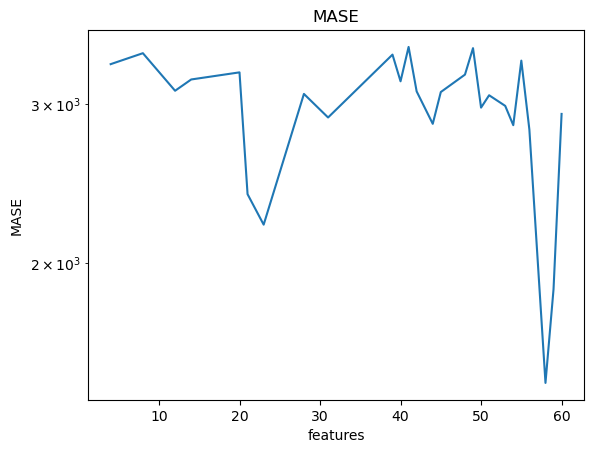

In [155]:
mask = cur_mase <= np.percentile(cur_mase, 40)
plt.plot(np.arange(cur_mase.shape[0])[mask], cur_mase[mask])
plt.yscale("log")
plt.xlabel("features")
plt.ylabel("MASE")
plt.title("MASE")
plt.show()

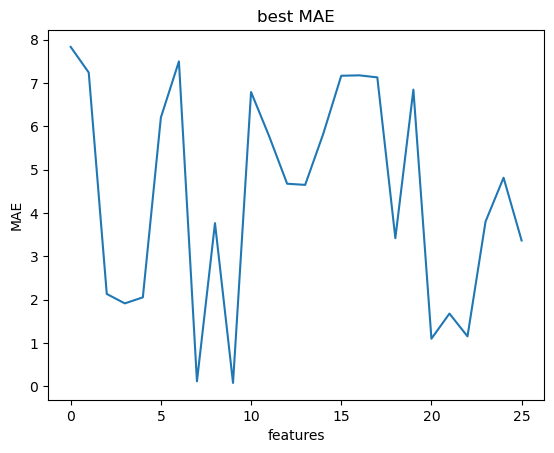

In [157]:
mask = cur_mae <= np.percentile(cur_mae, 40)
# plt.plot(np.arange(cur_mae.shape[0])[mask], cur_mae[mask])
plt.plot(cur_mae[mask])
plt.xlabel("features")
plt.ylabel("MAE")
plt.title("best MAE")
# plt.show()
plt.savefig("best MAE.png")

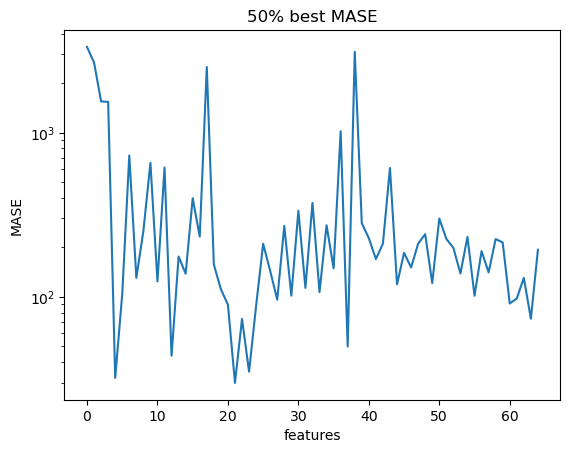

In [98]:
plt.plot(cur_mase[cur_mase <= np.percentile(cur_mase, 100)])
plt.yscale("log")
plt.xlabel("features")
plt.ylabel("MASE")
plt.title("50% best MASE")
plt.show()

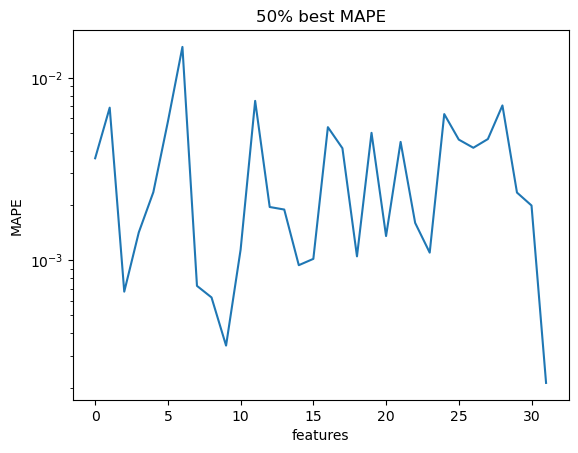

In [99]:
cur_mape = mape(y_true, y_pred)
plt.plot(cur_mape[cur_mape < np.percentile(cur_mape, 50)])
plt.yscale("log")
plt.xlabel("features")
plt.ylabel("MAPE")
plt.title("50% best MAPE")
plt.show()

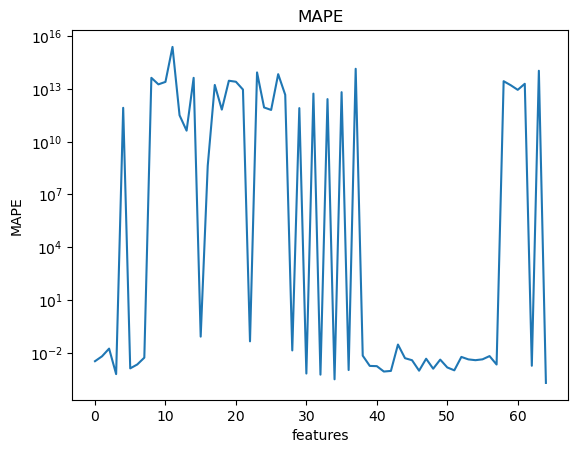

In [100]:
plt.plot(cur_mape[cur_mape <= np.percentile(cur_mape,100)])
plt.yscale("log")
plt.xlabel("features")
plt.ylabel("MAPE")
plt.title("MAPE")
plt.show()

In [22]:
model(np.zeros(67 * 10).reshape(1, 10, 67))

<tf.Tensor: shape=(1, 67), dtype=float32, numpy=
array([[ 8.25200696e-04, -2.52360152e-03,  1.24429585e-03,
         5.61252143e-03,  2.41480279e-03,  6.91283401e-03,
        -1.55929942e-04,  5.05245430e-03, -3.45375156e-03,
         2.31756223e-03, -5.02947718e-03,  5.21133933e-03,
         2.63487943e-03, -1.15680450e-03, -8.61713605e-04,
        -4.27721906e-03,  1.65054473e-04,  1.98029215e-03,
         1.16372411e-03, -6.18001819e-03,  1.38662616e-03,
        -3.87507980e-03, -5.78831602e-03, -4.70064487e-03,
        -4.91938740e-03, -9.45061352e-03, -6.37044199e-03,
        -1.24200690e-03, -2.50279880e-03,  6.26629405e-03,
         7.07075465e-03,  4.37504100e-03,  8.11321661e-06,
         6.27311785e-03, -2.45433138e-03,  6.55709300e-04,
         1.01655931e-03,  3.92863574e-03, -7.48858880e-03,
        -3.09383660e-03, -3.60715576e-03,  3.58439516e-04,
         5.01208124e-04,  4.94992966e-03,  4.09077760e-03,
        -1.00721011e-03, -6.26226794e-03, -6.27841754e-03,
       

In [32]:
maes = defaultdict(lambda: [])
mases = defaultdict(lambda: [])
mapes = defaultdict(lambda: [])
answers = {}
bad_values = np.zeros(dataset.shape[1])

dif=True

for window_size in window_sizes_for_clustering:
    for N_clusters in Ns_clusters:
        dataset_windows, dataset_y = Forecasting.create_windows(dataset, window_size=window_size)
        clusters_labels = Clustering.KMeans_for_windows(dataset_windows, W=window_size, N_clusters=N_clusters, max_iter=50)
        print(f"{clusters_labels.shape=}")
        datasets_clusters = Clustering.flatten_from_interceting_windows(dataset_windows, clusters_labels, W=window_size, \
                N_clusters=N_clusters)
        # list of list of ndarrays [N_i, Q], dataset_clusters[cluster_num][i] - i-th part of dataset for cluster_num

        print(f"{N_clusters=}, {len(datasets_clusters)}, {len(datasets_clusters[0])}, {datasets_clusters[0][0].shape}")
        ###window_size for model
        errors = [1] * N_clusters
        for cluster_num in range(N_clusters):
            sc = Forecasting.MyStandardScaler(dif=dif)
            #datasets_clusters[cluster_num] - list of [N_i, Q] ndarrays
            sc.fit(datasets_clusters[cluster_num])
            prepared_data = sc.transform(datasets_clusters[cluster_num])
            data_X, data_y = Forecasting.create_windows(prepared_data, window_size=10)
            #data_X - list of [N_i-W, W, Q] ndarrays
            train_X, train_y, valid_X, valid_y, test_X, test_y, ind = Forecasting.split_to_train_test(data_X, data_y, part_of_test=0.2, part_of_valid=0.2)
            #ndarrays [N_i, W, Q] or [N_i, Q]
            ind = np.array(ind) + window_size
            print(f"Before prediction: {train_X.shape=}, {train_y.shape=}, {test_X.shape=}, {test_y.shape=}")
            try:
                assert(len(test_X.shape) == 3 and test_X.shape[0] > 0)
                assert(len(valid_X.shape) == 3 and valid_X.shape[0] > 0)
                assert(len(train_X.shape) == 3 and train_X.shape[0] > 0)
            except AssertionError:
                print(f"FAIL - {test_X.shape=}, {valid_X.shape=}, {train_X.shape=}")
                errors[cluster_num] = np.Inf
                continue
            model, history = Forecasting.learn(train_X, train_y, valid_X=valid_X, valid_y=valid_y)
            predicted = model.predict(test_X)
            predicted_original = sc.inverse_transform(predicted)[0]
            #inverse_trasform returns list of ndarrays 
            # if dif:
                #константа при дифференцировании
                # predicted_original = sc.add_first_element(predicted_original, ind)[0]
            print(f"{predicted_original.shape=}, {test_y.shape=}")

            #calc all metrics
            cur_mae = mae(test_y, predicted_original, multioutput='raw_values')
#             error_out = mase(test_y, predicted_original, y_train=test_y)
#             error_in = mase(test_y, predicted_original, y_train=train_y)
            # cur_mase = mase(test_y, predicted_original, y_train=test_y)
            cur_mape = mape(test_y, predicted_original)
            cur_mase = Forecasting.my_mase(test_y, predicted_original, multioutput='raw_values')
            maes[(window_size, N_clusters)].append(cur_mae)
#             mases[(window_size, N_clusters)].append((error_in, error_out))
            mapes[(window_size, N_clusters)].append(cur_mape)
#             errors[cluster_num] = mase_uni(test_y, predicted_original, y_train=test_y)
            tmp_bad = cur_mase > np.percentile(cur_mase, 90)
            bad_values += tmp_bad
            cur_mase[tmp_bad] = -1
#             errors[cluster_num] = Forecasting.my_mase(test_y, predicted_original, multioutput='uniform_average')
            errors[cluster_num] = np.mean(cur_mase[~tmp_bad])
            
            #show all metrics
            plt.figure(figsize=(12, 10))
            plt.suptitle(f"K={N_clusters}, W={window_size}, C={cluster_num}")
            plt.subplot(2, 2, 1)
            plt.plot(cur_mae, color="green", label="library")
            plt.plot(Forecasting.my_mae(test_y, predicted_original, multioutput='raw_values'), color="red", label="custom")
            plt.title("MAE")
            plt.legend()

            plt.subplot(2, 2, 2)
#             plt.plot(error_in, label="library, in")
#             plt.plot(error_out, label="library, out")
            plt.plot(cur_mase, label="custom, out")
            plt.title("MASE")
            plt.legend()

            plt.subplot(2, 2, 3)
            plt.plot(cur_mape)
            plt.title("MAPE")
            plt.legend()

            plt.savefig(f"plots/Dataset2/K={N_clusters}  W={window_size} C={cluster_num}.png")
#             plt.show()    
            plt.clf()
            # print(f"{cur_mae=}, {cur_mase=}, {cur_mape=}")
            # my_mase = mase()
            # print(f"MASE in_sample = {error_in}, MASE out_sample = {error_out}")
            print(f"average MASE = {errors[cluster_num]}, my average MASE = {Forecasting.my_mase(test_y, predicted_original, multioutput='uniform_average')}")
            print(f"Cluster {cluster_num}, {errors[cluster_num]}")
        answers[(window_size, N_clusters)] = errors
        plt.figure(figsize=(12, 10))
        plt.suptitle(f"K={N_clusters}, W={window_size}")
        plt.subplot(2, 2, 1)

        plt.bar(np.arange(N_clusters), [np.sum(clusters_labels == i) for i in range(N_clusters)], color='blue')
        plt.title("Размеры кластеров")
        plt.subplot(2, 2, 2)
        plt.bar(np.arange(N_clusters), [len(datasets_clusters[i]) for i in range(N_clusters)], color="green")
        plt.title("Количество непрерывных отрезков")
        plt.subplot(2, 2, 3)
        plt.bar(np.arange(N_clusters), errors, color="red")
        plt.title("MASE на тесте каждого из кластеров")
        plt.subplot(2, 2, 4)
        plt.axis('tight')
        plt.axis('off')
        plt.table(cellText= [[f"{x:.2f}"] for x in errors],
                      rowLabels=list(range(N_clusters)),
                      loc='center')
#         plt.show()
        plt.savefig(f"plots/Dataset2/method1: {N_clusters=}  W={window_size}.png")
        #         plt.show()
        plt.clf()
        

clusters_labels.shape=(408095,)
N_clusters=2, 2, 22, (30608, 67)
Before prediction: train_X.shape=(18358, 10, 67), train_y.shape=(18358, 67), test_X.shape=(6119, 10, 67), test_y.shape=(6119, 67)
Epoch 1/40
287/287 [==============================] - 9s 30ms/step - loss: 0.3112 - val_loss: 0.3270
Epoch 2/40
287/287 [==============================] - 9s 31ms/step - loss: 0.2915 - val_loss: 0.3111
Epoch 3/40
287/287 [==============================] - 8s 29ms/step - loss: 0.2761 - val_loss: 0.2987
Epoch 4/40
287/287 [==============================] - 9s 32ms/step - loss: 0.2646 - val_loss: 0.2898
Epoch 5/40
287/287 [==============================] - 8s 29ms/step - loss: 0.2564 - val_loss: 0.2830
Epoch 6/40
287/287 [==============================] - 8s 28ms/step - loss: 0.2504 - val_loss: 0.2777
Epoch 7/40
287/287 [==============================] - 8s 29ms/step - loss: 0.2456 - val_loss: 0.2732
Epoch 8/40
287/287 [==============================] - 8s 29ms/step - loss: 0.2415 - val_loss: 0.26

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 1578.0531622950014, my average MASE = 2807.2183134542065
Cluster 0, 1578.0531622950014
Before prediction: train_X.shape=(8, 10, 67), train_y.shape=(8, 67), test_X.shape=(3, 10, 67), test_y.shape=(3, 67)
Epoch 1/40
1/1 [==============================] - 0s 87ms/step - loss: 0.4317 - val_loss: 1.2280
Epoch 2/40
1/1 [==============================] - 0s 63ms/step - loss: 0.4299 - val_loss: 1.2276
Epoch 3/40
1/1 [==============================] - 0s 65ms/step - loss: 0.4282 - val_loss: 1.2273
Epoch 4/40
1/1 [==============================] - 0s 63ms/step - loss: 0.4264 - val_loss: 1.2269
Epoch 5/40
1/1 [==============================] - 0s 65ms/step - loss: 0.4247 - val_loss: 1.2266
Epoch 6/40
1/1 [==============================] - 0s 61ms/step - loss: 0.4231 - val_loss: 1.2263
Epoch 7/40
1/1 [==============================] - 0s 62ms/step - loss: 0.4214 - val_loss: 1.2259
Epoch 8/40
1/1 [==============================] - 0s 65ms/step - loss: 0.4198 - val_loss: 1.2256
Epoch 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 708619678.5307182, my average MASE = 1911068024.4320867
Cluster 1, 708619678.5307182
clusters_labels.shape=(408095,)
N_clusters=5, 5, 1026, (269, 67)
Before prediction: train_X.shape=(155, 10, 67), train_y.shape=(155, 67), test_X.shape=(52, 10, 67), test_y.shape=(52, 67)
Epoch 1/40
3/3 [==============================] - 0s 55ms/step - loss: 0.5683 - val_loss: 0.4789
Epoch 2/40
3/3 [==============================] - 0s 47ms/step - loss: 0.5669 - val_loss: 0.4779
Epoch 3/40
3/3 [==============================] - 0s 43ms/step - loss: 0.5656 - val_loss: 0.4770
Epoch 4/40
3/3 [==============================] - 0s 45ms/step - loss: 0.5643 - val_loss: 0.4760
Epoch 5/40
3/3 [==============================] - 0s 45ms/step - loss: 0.5631 - val_loss: 0.4751
Epoch 6/40
3/3 [==============================] - 0s 45ms/step - loss: 0.5619 - val_loss: 0.4743
Epoch 7/40
3/3 [==============================] - 0s 46ms/step - loss: 0.5607 - val_loss: 0.4734
Epoch 8/40
3/3 [==================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 139.40868807431647, my average MASE = 112470179.11258063
Cluster 0, 139.40868807431647
Before prediction: train_X.shape=(31, 10, 67), train_y.shape=(31, 67), test_X.shape=(10, 10, 67), test_y.shape=(10, 67)
Epoch 1/40
1/1 [==============================] - 0s 90ms/step - loss: 0.3364 - val_loss: 0.3469
Epoch 2/40
1/1 [==============================] - 0s 64ms/step - loss: 0.3360 - val_loss: 0.3468
Epoch 3/40
1/1 [==============================] - 0s 64ms/step - loss: 0.3355 - val_loss: 0.3468
Epoch 4/40
1/1 [==============================] - 0s 70ms/step - loss: 0.3350 - val_loss: 0.3467
Epoch 5/40
1/1 [==============================] - 0s 66ms/step - loss: 0.3346 - val_loss: 0.3466
Epoch 6/40
1/1 [==============================] - 0s 68ms/step - loss: 0.3341 - val_loss: 0.3465
Epoch 7/40
1/1 [==============================] - 0s 67ms/step - loss: 0.3337 - val_loss: 0.3464
Epoch 8/40
1/1 [==============================] - 0s 68ms/step - loss: 0.3332 - val_loss: 0.3463
Ep

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 3523641.3982873675, my average MASE = 66808534.66599488
Cluster 1, 3523641.3982873675
Before prediction: train_X.shape=(1939, 10, 67), train_y.shape=(1939, 67), test_X.shape=(646, 10, 67), test_y.shape=(646, 67)
Epoch 1/40
31/31 [==============================] - 1s 35ms/step - loss: 0.1130 - val_loss: 0.1021
Epoch 2/40
31/31 [==============================] - 1s 34ms/step - loss: 0.1076 - val_loss: 0.1000
Epoch 3/40
31/31 [==============================] - 1s 33ms/step - loss: 0.1032 - val_loss: 0.0984
Epoch 4/40
31/31 [==============================] - 1s 35ms/step - loss: 0.0995 - val_loss: 0.0974
Epoch 5/40
31/31 [==============================] - 1s 33ms/step - loss: 0.0964 - val_loss: 0.0968
Epoch 6/40
31/31 [==============================] - 1s 34ms/step - loss: 0.0936 - val_loss: 0.0962
Epoch 7/40
31/31 [==============================] - 1s 31ms/step - loss: 0.0912 - val_loss: 0.0958
Epoch 8/40
31/31 [==============================] - 1s 31ms/step - loss: 0.0889 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(646, 67), test_y.shape=(646, 67)
average MASE = 869790828.2820631, my average MASE = 17262168691.962505
Cluster 2, 869790828.2820631
Before prediction: train_X.shape=(2219, 10, 67), train_y.shape=(2219, 67), test_X.shape=(740, 10, 67), test_y.shape=(740, 67)
Epoch 1/40
35/35 [==============================] - 1s 30ms/step - loss: 0.5462 - val_loss: 0.4045
Epoch 2/40
35/35 [==============================] - 1s 30ms/step - loss: 0.5391 - val_loss: 0.4010
Epoch 3/40
35/35 [==============================] - 1s 30ms/step - loss: 0.5333 - val_loss: 0.3979
Epoch 4/40
35/35 [==============================] - 1s 30ms/step - loss: 0.5281 - val_loss: 0.3951
Epoch 5/40
35/35 [==============================] - 1s 30ms/step - loss: 0.5234 - val_loss: 0.3925
Epoch 6/40
35/35 [==============================] - 1s 34ms/step - loss: 0.5190 - val_loss: 0.3900
Epoch 7/40
35/35 [==============================] - 1s 34ms/step - loss: 0.5147 - val_loss: 0.3877
Epoch 8/40
35/35 [====

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 408.78828000932964, my average MASE = 1218.6998180420371
Cluster 3, 408.78828000932964
Before prediction: train_X.shape=(32, 10, 67), train_y.shape=(32, 67), test_X.shape=(11, 10, 67), test_y.shape=(11, 67)
Epoch 1/40
1/1 [==============================] - 0s 92ms/step - loss: 0.5668 - val_loss: 0.4468
Epoch 2/40
1/1 [==============================] - 0s 60ms/step - loss: 0.5648 - val_loss: 0.4459
Epoch 3/40
1/1 [==============================] - 0s 67ms/step - loss: 0.5628 - val_loss: 0.4451
Epoch 4/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5609 - val_loss: 0.4443
Epoch 5/40
1/1 [==============================] - 0s 71ms/step - loss: 0.5589 - val_loss: 0.4435
Epoch 6/40
1/1 [==============================] - 0s 64ms/step - loss: 0.5570 - val_loss: 0.4427
Epoch 7/40
1/1 [==============================] - 0s 62ms/step - loss: 0.5551 - val_loss: 0.4419
Epoch 8/40
1/1 [==============================] - 0s 65ms/step - loss: 0.5533 - val_loss: 0.4412
Ep

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 2631402082.882854, my average MASE = 5288471031.0194235
Cluster 4, 2631402082.882854
clusters_labels.shape=(408095,)
N_clusters=7, 7, 17, (3243, 67)
Before prediction: train_X.shape=(1939, 10, 67), train_y.shape=(1939, 67), test_X.shape=(646, 10, 67), test_y.shape=(646, 67)
Epoch 1/40
31/31 [==============================] - 1s 31ms/step - loss: 0.1149 - val_loss: 0.1029
Epoch 2/40
31/31 [==============================] - 1s 30ms/step - loss: 0.1092 - val_loss: 0.1008
Epoch 3/40
31/31 [==============================] - 1s 30ms/step - loss: 0.1047 - val_loss: 0.0992
Epoch 4/40
31/31 [==============================] - 1s 31ms/step - loss: 0.1009 - val_loss: 0.0980
Epoch 5/40
31/31 [==============================] - 1s 30ms/step - loss: 0.0976 - val_loss: 0.0972
Epoch 6/40
31/31 [==============================] - 1s 31ms/step - loss: 0.0947 - val_loss: 0.0965
Epoch 7/40
31/31 [==============================] - 1s 34ms/step - loss: 0.0922 - val_loss: 0.0960
Epoch 8/40
31/31 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(646, 67), test_y.shape=(646, 67)
average MASE = 1397145651.915293, my average MASE = 8779028319.064796
Cluster 0, 1397145651.915293
Before prediction: train_X.shape=(77, 10, 67), train_y.shape=(77, 67), test_X.shape=(26, 10, 67), test_y.shape=(26, 67)
Epoch 1/40
2/2 [==============================] - 0s 84ms/step - loss: 0.4446 - val_loss: 0.4248
Epoch 2/40
2/2 [==============================] - 0s 218ms/step - loss: 0.4440 - val_loss: 0.4245
Epoch 3/40
2/2 [==============================] - 0s 65ms/step - loss: 0.4434 - val_loss: 0.4242
Epoch 4/40
2/2 [==============================] - 0s 60ms/step - loss: 0.4429 - val_loss: 0.4239
Epoch 5/40
2/2 [==============================] - 0s 62ms/step - loss: 0.4423 - val_loss: 0.4236
Epoch 6/40
2/2 [==============================] - 0s 69ms/step - loss: 0.4418 - val_loss: 0.4234
Epoch 7/40
2/2 [==============================] - 0s 70ms/step - loss: 0.4413 - val_loss: 0.4231
Epoch 8/40
2/2 [==========================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(26, 67), test_y.shape=(26, 67)
average MASE = 86.00366340249806, my average MASE = 69691247.07168306
Cluster 1, 86.00366340249806
Before prediction: train_X.shape=(4, 10, 67), train_y.shape=(4, 67), test_X.shape=(1, 10, 67), test_y.shape=(1, 67)
Epoch 1/40
1/1 [==============================] - 0s 88ms/step - loss: 0.9826 - val_loss: 1.3468
Epoch 2/40
1/1 [==============================] - 0s 72ms/step - loss: 0.9801 - val_loss: 1.3460
Epoch 3/40
1/1 [==============================] - 0s 66ms/step - loss: 0.9776 - val_loss: 1.3453
Epoch 4/40
1/1 [==============================] - 0s 66ms/step - loss: 0.9751 - val_loss: 1.3446
Epoch 5/40
1/1 [==============================] - 0s 65ms/step - loss: 0.9726 - val_loss: 1.3439
Epoch 6/40
1/1 [==============================] - 0s 63ms/step - loss: 0.9701 - val_loss: 1.3432
Epoch 7/40
1/1 [==============================] - 0s 74ms/step - loss: 0.9677 - val_loss: 1.3425
Epoch 8/40
1/1 [==============================] -

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 1.6636413128548868, my average MASE = 8.526439257891766
Cluster 2, 1.6636413128548868
Before prediction: train_X.shape=(177, 10, 67), train_y.shape=(177, 67), test_X.shape=(59, 10, 67), test_y.shape=(59, 67)
Epoch 1/40
3/3 [==============================] - 0s 59ms/step - loss: 0.7327 - val_loss: 0.5966
Epoch 2/40
3/3 [==============================] - 0s 50ms/step - loss: 0.7311 - val_loss: 0.5956
Epoch 3/40
3/3 [==============================] - 0s 46ms/step - loss: 0.7296 - val_loss: 0.5946
Epoch 4/40
3/3 [==============================] - 0s 46ms/step - loss: 0.7281 - val_loss: 0.5936
Epoch 5/40
3/3 [==============================] - 0s 46ms/step - loss: 0.7266 - val_loss: 0.5927
Epoch 6/40
3/3 [==============================] - 0s 44ms/step - loss: 0.7252 - val_loss: 0.5918
Epoch 7/40
3/3 [==============================] - 0s 49ms/step - loss: 0.7239 - val_loss: 0.5909
Epoch 8/40
3/3 [==============================] - 0s 44ms/step - loss: 0.7225 - val_loss: 0.5901
E

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 148.95203283848892, my average MASE = 195949093.5023566
Cluster 3, 148.95203283848892
Before prediction: train_X.shape=(59, 10, 67), train_y.shape=(59, 67), test_X.shape=(20, 10, 67), test_y.shape=(20, 67)
Epoch 1/40
1/1 [==============================] - 0s 97ms/step - loss: 0.4242 - val_loss: 0.4717
Epoch 2/40
1/1 [==============================] - 0s 72ms/step - loss: 0.4237 - val_loss: 0.4716
Epoch 3/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4233 - val_loss: 0.4715
Epoch 4/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4228 - val_loss: 0.4714
Epoch 5/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4223 - val_loss: 0.4713
Epoch 6/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4219 - val_loss: 0.4712
Epoch 7/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4214 - val_loss: 0.4711
Epoch 8/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4210 - val_loss: 0.4710
Epo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 138.4214035546147, my average MASE = 76438634.40084383
Cluster 4, 138.4214035546147
Before prediction: train_X.shape=(6, 10, 67), train_y.shape=(6, 67), test_X.shape=(2, 10, 67), test_y.shape=(2, 67)
Epoch 1/40
1/1 [==============================] - 0s 89ms/step - loss: 0.4144 - val_loss: 0.4072
Epoch 2/40
1/1 [==============================] - 0s 64ms/step - loss: 0.4116 - val_loss: 0.4056
Epoch 3/40
1/1 [==============================] - 0s 72ms/step - loss: 0.4089 - val_loss: 0.4039
Epoch 4/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4061 - val_loss: 0.4022
Epoch 5/40
1/1 [==============================] - 0s 63ms/step - loss: 0.4034 - val_loss: 0.4005
Epoch 6/40
1/1 [==============================] - 0s 64ms/step - loss: 0.4008 - val_loss: 0.3988
Epoch 7/40
1/1 [==============================] - 0s 60ms/step - loss: 0.3982 - val_loss: 0.3971
Epoch 8/40
1/1 [==============================] - 0s 62ms/step - loss: 0.3957 - val_loss: 0.3954
Epoch 9/4

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 697989181.1057402, my average MASE = 1714132782.1928625
Cluster 5, 697989181.1057402
Before prediction: train_X.shape=(95, 10, 67), train_y.shape=(95, 67), test_X.shape=(32, 10, 67), test_y.shape=(32, 67)
Epoch 1/40
2/2 [==============================] - 0s 83ms/step - loss: 0.3944 - val_loss: 0.3555
Epoch 2/40
2/2 [==============================] - 0s 63ms/step - loss: 0.3937 - val_loss: 0.3552
Epoch 3/40
2/2 [==============================] - 0s 62ms/step - loss: 0.3930 - val_loss: 0.3549
Epoch 4/40
2/2 [==============================] - 0s 68ms/step - loss: 0.3924 - val_loss: 0.3546
Epoch 5/40
2/2 [==============================] - 0s 61ms/step - loss: 0.3917 - val_loss: 0.3543
Epoch 6/40
2/2 [==============================] - 0s 61ms/step - loss: 0.3910 - val_loss: 0.3540
Epoch 7/40
2/2 [==============================] - 0s 65ms/step - loss: 0.3904 - val_loss: 0.3537
Epoch 8/40
2/2 [==============================] - 0s 61ms/step - loss: 0.3898 - val_loss: 0.3534
Epoc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(32, 67), test_y.shape=(32, 67)
average MASE = 265.33452450872096, my average MASE = 56598015.30805221
Cluster 6, 265.33452450872096
clusters_labels.shape=(408095,)
N_clusters=9, 9, 1486, (3, 67)
Before prediction: train_X.shape=(97, 10, 67), train_y.shape=(97, 67), test_X.shape=(32, 10, 67), test_y.shape=(32, 67)
Epoch 1/40
2/2 [==============================] - 0s 89ms/step - loss: 0.4153 - val_loss: 0.4398
Epoch 2/40
2/2 [==============================] - 0s 63ms/step - loss: 0.4145 - val_loss: 0.4396
Epoch 3/40
2/2 [==============================] - 0s 68ms/step - loss: 0.4138 - val_loss: 0.4393
Epoch 4/40
2/2 [==============================] - 0s 59ms/step - loss: 0.4131 - val_loss: 0.4391
Epoch 5/40
2/2 [==============================] - 0s 66ms/step - loss: 0.4124 - val_loss: 0.4388
Epoch 6/40
2/2 [==============================] - 0s 64ms/step - loss: 0.4118 - val_loss: 0.4386
Epoch 7/40
2/2 [==============================] - 0s 59ms/step - loss: 0.4111

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(32, 67), test_y.shape=(32, 67)
average MASE = 106.62824359839709, my average MASE = 181907103.45341906
Cluster 0, 106.62824359839709
Before prediction: train_X.shape=(1415, 10, 67), train_y.shape=(1415, 67), test_X.shape=(472, 10, 67), test_y.shape=(472, 67)
Epoch 1/40
23/23 [==============================] - 1s 32ms/step - loss: 0.1435 - val_loss: 0.0272
Epoch 2/40
23/23 [==============================] - 1s 31ms/step - loss: 0.1388 - val_loss: 0.0264
Epoch 3/40
23/23 [==============================] - 1s 30ms/step - loss: 0.1347 - val_loss: 0.0256
Epoch 4/40
23/23 [==============================] - 1s 30ms/step - loss: 0.1311 - val_loss: 0.0250
Epoch 5/40
23/23 [==============================] - 1s 30ms/step - loss: 0.1278 - val_loss: 0.0244
Epoch 6/40
23/23 [==============================] - 1s 30ms/step - loss: 0.1249 - val_loss: 0.0239
Epoch 7/40
23/23 [==============================] - 1s 30ms/step - loss: 0.1221 - val_loss: 0.0234
Epoch 8/40
23/23 [====

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(472, 67), test_y.shape=(472, 67)
average MASE = 484561401.3912065, my average MASE = 2109803098.5295365
Cluster 1, 484561401.3912065
Before prediction: train_X.shape=(19, 10, 67), train_y.shape=(19, 67), test_X.shape=(6, 10, 67), test_y.shape=(6, 67)
Epoch 1/40
1/1 [==============================] - 0s 95ms/step - loss: 0.4184 - val_loss: 0.4085
Epoch 2/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4174 - val_loss: 0.4084
Epoch 3/40
1/1 [==============================] - 0s 65ms/step - loss: 0.4165 - val_loss: 0.4083
Epoch 4/40
1/1 [==============================] - 0s 70ms/step - loss: 0.4155 - val_loss: 0.4082
Epoch 5/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4146 - val_loss: 0.4082
Epoch 6/40
1/1 [==============================] - 0s 63ms/step - loss: 0.4136 - val_loss: 0.4081
Epoch 7/40
1/1 [==============================] - 0s 67ms/step - loss: 0.4127 - val_loss: 0.4080
Epoch 8/40
1/1 [============================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 146.41485105295615, my average MASE = 90287364.09726365
Cluster 2, 146.41485105295615
Before prediction: train_X.shape=(32, 10, 67), train_y.shape=(32, 67), test_X.shape=(11, 10, 67), test_y.shape=(11, 67)
Epoch 1/40
1/1 [==============================] - 0s 91ms/step - loss: 0.5429 - val_loss: 0.4489
Epoch 2/40
1/1 [==============================] - 0s 59ms/step - loss: 0.5408 - val_loss: 0.4477
Epoch 3/40
1/1 [==============================] - 0s 69ms/step - loss: 0.5388 - val_loss: 0.4466
Epoch 4/40
1/1 [==============================] - 0s 65ms/step - loss: 0.5367 - val_loss: 0.4454
Epoch 5/40
1/1 [==============================] - 0s 64ms/step - loss: 0.5348 - val_loss: 0.4443
Epoch 6/40
1/1 [==============================] - 0s 67ms/step - loss: 0.5328 - val_loss: 0.4432
Epoch 7/40
1/1 [==============================] - 0s 78ms/step - loss: 0.5308 - val_loss: 0.4421
Epoch 8/40
1/1 [==============================] - 0s 68ms/step - loss: 0.5289 - val_loss: 0.4410
Epo

/tmp/ipykernel_1177081/3287276626.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 10))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 3556660081.750684, my average MASE = 7865462670.190711
Cluster 3, 3556660081.750684
Before prediction: train_X.shape=(173, 10, 67), train_y.shape=(173, 67), test_X.shape=(58, 10, 67), test_y.shape=(58, 67)
Epoch 1/40
3/3 [==============================] - 0s 59ms/step - loss: 0.7286 - val_loss: 0.5747
Epoch 2/40
3/3 [==============================] - 0s 44ms/step - loss: 0.7270 - val_loss: 0.5740
Epoch 3/40
3/3 [==============================] - 0s 49ms/step - loss: 0.7256 - val_loss: 0.5733
Epoch 4/40
3/3 [==============================] - 0s 43ms/step - loss: 0.7243 - val_loss: 0.5725
Epoch 5/40
3/3 [==============================] - 0s 44ms/step - loss: 0.7229 - val_loss: 0.5718
Epoch 6/40
3/3 [==============================] - 0s 46ms/step - loss: 0.7216 - val_loss: 0.5712
Epoch 7/40
3/3 [==============================] - 0s 47ms/step - loss: 0.7203 - val_loss: 0.5705
Epoch 8/40
3/3 [==============================] - 0s 43ms/step - loss: 0.7190 - val_loss: 0.5698
Epo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 122.19340890523425, my average MASE = 115345826.80728418
Cluster 4, 122.19340890523425
Before prediction: train_X.shape=(1562, 10, 67), train_y.shape=(1562, 67), test_X.shape=(521, 10, 67), test_y.shape=(521, 67)
Epoch 1/40
25/25 [==============================] - 1s 31ms/step - loss: 0.2392 - val_loss: 0.2772
Epoch 2/40
25/25 [==============================] - 1s 31ms/step - loss: 0.2287 - val_loss: 0.2673
Epoch 3/40
25/25 [==============================] - 1s 31ms/step - loss: 0.2207 - val_loss: 0.2595
Epoch 4/40
25/25 [==============================] - 1s 31ms/step - loss: 0.2144 - val_loss: 0.2534
Epoch 5/40
25/25 [==============================] - 1s 30ms/step - loss: 0.2094 - val_loss: 0.2481
Epoch 6/40
25/25 [==============================] - 1s 32ms/step - loss: 0.2050 - val_loss: 0.2435
Epoch 7/40
25/25 [==============================] - 1s 31ms/step - loss: 0.2013 - val_loss: 0.2394
Epoch 8/40
25/25 [==============================] - 1s 30ms/step - loss: 0.1978

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 151.79409601094594, my average MASE = 3866050940.760538
Cluster 5, 151.79409601094594
Before prediction: train_X.shape=(83, 10, 67), train_y.shape=(83, 67), test_X.shape=(28, 10, 67), test_y.shape=(28, 67)
Epoch 1/40
2/2 [==============================] - 0s 80ms/step - loss: 0.4279 - val_loss: 0.5018
Epoch 2/40
2/2 [==============================] - 0s 65ms/step - loss: 0.4270 - val_loss: 0.5012
Epoch 3/40
2/2 [==============================] - 0s 63ms/step - loss: 0.4262 - val_loss: 0.5006
Epoch 4/40
2/2 [==============================] - 0s 64ms/step - loss: 0.4254 - val_loss: 0.5000
Epoch 5/40
2/2 [==============================] - 0s 64ms/step - loss: 0.4246 - val_loss: 0.4995
Epoch 6/40
2/2 [==============================] - 0s 62ms/step - loss: 0.4239 - val_loss: 0.4989
Epoch 7/40
2/2 [==============================] - 0s 64ms/step - loss: 0.4231 - val_loss: 0.4984
Epoch 8/40
2/2 [==============================] - 0s 62ms/step - loss: 0.4224 - val_loss: 0.4978
Epo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 155.68618683798326, my average MASE = 97738271.39222205
Cluster 6, 155.68618683798326
Before prediction: train_X.shape=(1, 10, 67), train_y.shape=(1, 67), test_X.shape=(0, 10, 67), test_y.shape=(0, 67)
FAIL - test_X.shape=(0, 10, 67), valid_X.shape=(1, 10, 67), train_X.shape=(1, 10, 67)
Before prediction: train_X.shape=(19, 10, 67), train_y.shape=(19, 67), test_X.shape=(6, 10, 67), test_y.shape=(6, 67)
Epoch 1/40
1/1 [==============================] - 0s 102ms/step - loss: 0.2911 - val_loss: 0.2917
Epoch 2/40
1/1 [==============================] - 0s 68ms/step - loss: 0.2907 - val_loss: 0.2915
Epoch 3/40
1/1 [==============================] - 0s 67ms/step - loss: 0.2902 - val_loss: 0.2913
Epoch 4/40
1/1 [==============================] - 0s 65ms/step - loss: 0.2897 - val_loss: 0.2911
Epoch 5/40
1/1 [==============================] - 0s 65ms/step - loss: 0.2892 - val_loss: 0.2909
Epoch 6/40
1/1 [==============================] - 0s 66ms/step - loss: 0.2888 - val_loss: 0.2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 112.24086700274312, my average MASE = 119826311.76187374
Cluster 8, 112.24086700274312
clusters_labels.shape=(408095,)
N_clusters=11, 11, 17, (3243, 67)
Before prediction: train_X.shape=(1939, 10, 67), train_y.shape=(1939, 67), test_X.shape=(646, 10, 67), test_y.shape=(646, 67)
Epoch 1/40
31/31 [==============================] - 1s 33ms/step - loss: 0.1118 - val_loss: 0.1019
Epoch 2/40
31/31 [==============================] - 1s 34ms/step - loss: 0.1064 - val_loss: 0.0996
Epoch 3/40
31/31 [==============================] - 1s 31ms/step - loss: 0.1022 - val_loss: 0.0982
Epoch 4/40
31/31 [==============================] - 1s 30ms/step - loss: 0.0987 - val_loss: 0.0973
Epoch 5/40
31/31 [==============================] - 1s 30ms/step - loss: 0.0956 - val_loss: 0.0966
Epoch 6/40
31/31 [==============================] - 1s 34ms/step - loss: 0.0930 - val_loss: 0.0962
Epoch 7/40
31/31 [==============================] - 1s 34ms/step - loss: 0.0906 - val_loss: 0.0958
Epoch 8/40
31

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(646, 67), test_y.shape=(646, 67)
average MASE = 876211806.5152007, my average MASE = 21477700395.128197
Cluster 0, 876211806.5152007
Before prediction: train_X.shape=(13, 10, 67), train_y.shape=(13, 67), test_X.shape=(4, 10, 67), test_y.shape=(4, 67)
Epoch 1/40
1/1 [==============================] - 0s 91ms/step - loss: 0.7012 - val_loss: 0.5689
Epoch 2/40
1/1 [==============================] - 0s 68ms/step - loss: 0.7001 - val_loss: 0.5688
Epoch 3/40
1/1 [==============================] - 0s 63ms/step - loss: 0.6990 - val_loss: 0.5687
Epoch 4/40
1/1 [==============================] - 0s 68ms/step - loss: 0.6979 - val_loss: 0.5686
Epoch 5/40
1/1 [==============================] - 0s 68ms/step - loss: 0.6968 - val_loss: 0.5685
Epoch 6/40
1/1 [==============================] - 0s 69ms/step - loss: 0.6958 - val_loss: 0.5684
Epoch 7/40
1/1 [==============================] - 0s 63ms/step - loss: 0.6947 - val_loss: 0.5683
Epoch 8/40
1/1 [============================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 1104923.1929255812, my average MASE = 35973487.14565515
Cluster 1, 1104923.1929255812
Before prediction: train_X.shape=(134, 10, 67), train_y.shape=(134, 67), test_X.shape=(45, 10, 67), test_y.shape=(45, 67)
Epoch 1/40
3/3 [==============================] - 0s 59ms/step - loss: 0.4388 - val_loss: 0.7635
Epoch 2/40
3/3 [==============================] - 0s 44ms/step - loss: 0.4381 - val_loss: 0.7630
Epoch 3/40
3/3 [==============================] - 0s 48ms/step - loss: 0.4375 - val_loss: 0.7625
Epoch 4/40
3/3 [==============================] - 0s 45ms/step - loss: 0.4369 - val_loss: 0.7620
Epoch 5/40
3/3 [==============================] - 0s 45ms/step - loss: 0.4363 - val_loss: 0.7616
Epoch 6/40
3/3 [==============================] - 0s 45ms/step - loss: 0.4358 - val_loss: 0.7611
Epoch 7/40
3/3 [==============================] - 0s 46ms/step - loss: 0.4353 - val_loss: 0.7607
Epoch 8/40
3/3 [==============================] - 0s 46ms/step - loss: 0.4348 - val_loss: 0.7603
E

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 134.01886625392066, my average MASE = 180554408.61752364
Cluster 2, 134.01886625392066
Before prediction: train_X.shape=(2, 10, 67), train_y.shape=(2, 67), test_X.shape=(1, 10, 67), test_y.shape=(1, 67)
Epoch 1/40
1/1 [==============================] - 0s 83ms/step - loss: 0.3365 - val_loss: 0.4571
Epoch 2/40
1/1 [==============================] - 0s 65ms/step - loss: 0.3346 - val_loss: 0.4566
Epoch 3/40
1/1 [==============================] - 0s 58ms/step - loss: 0.3328 - val_loss: 0.4560
Epoch 4/40
1/1 [==============================] - 0s 60ms/step - loss: 0.3311 - val_loss: 0.4555
Epoch 5/40
1/1 [==============================] - 0s 60ms/step - loss: 0.3293 - val_loss: 0.4550
Epoch 6/40
1/1 [==============================] - 0s 61ms/step - loss: 0.3277 - val_loss: 0.4544
Epoch 7/40
1/1 [==============================] - 0s 60ms/step - loss: 0.3260 - val_loss: 0.4539
Epoch 8/40
1/1 [==============================] - 0s 61ms/step - loss: 0.3244 - val_loss: 0.4534
Epoch 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 0.28495017155315366, my average MASE = 0.3992586255016426
Cluster 3, 0.28495017155315366
Before prediction: train_X.shape=(77, 10, 67), train_y.shape=(77, 67), test_X.shape=(26, 10, 67), test_y.shape=(26, 67)
Epoch 1/40
2/2 [==============================] - 0s 90ms/step - loss: 0.6320 - val_loss: 1.0222
Epoch 2/40
2/2 [==============================] - 0s 60ms/step - loss: 0.6307 - val_loss: 1.0218
Epoch 3/40
2/2 [==============================] - 0s 60ms/step - loss: 0.6295 - val_loss: 1.0214
Epoch 4/40
2/2 [==============================] - 0s 60ms/step - loss: 0.6284 - val_loss: 1.0211
Epoch 5/40
2/2 [==============================] - 0s 60ms/step - loss: 0.6273 - val_loss: 1.0208
Epoch 6/40
2/2 [==============================] - 0s 60ms/step - loss: 0.6262 - val_loss: 1.0205
Epoch 7/40
2/2 [==============================] - 0s 64ms/step - loss: 0.6252 - val_loss: 1.0201
Epoch 8/40
2/2 [==============================] - 0s 61ms/step - loss: 0.6241 - val_loss: 1.0198


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(26, 67), test_y.shape=(26, 67)
average MASE = 98.33747704062574, my average MASE = 204772160.73570046
Cluster 4, 98.33747704062574
Before prediction: train_X.shape=(5, 10, 67), train_y.shape=(5, 67), test_X.shape=(2, 10, 67), test_y.shape=(2, 67)
Epoch 1/40
1/1 [==============================] - 0s 91ms/step - loss: 0.4785 - val_loss: 0.4645
Epoch 2/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4760 - val_loss: 0.4629
Epoch 3/40
1/1 [==============================] - 0s 63ms/step - loss: 0.4734 - val_loss: 0.4612
Epoch 4/40
1/1 [==============================] - 0s 60ms/step - loss: 0.4709 - val_loss: 0.4596
Epoch 5/40
1/1 [==============================] - 0s 60ms/step - loss: 0.4684 - val_loss: 0.4580
Epoch 6/40
1/1 [==============================] - 0s 60ms/step - loss: 0.4661 - val_loss: 0.4564
Epoch 7/40
1/1 [==============================] - 0s 61ms/step - loss: 0.4638 - val_loss: 0.4548
Epoch 8/40
1/1 [==============================] 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 931833756.986838, my average MASE = 2420970654.4710827
Cluster 5, 931833756.986838
Before prediction: train_X.shape=(5, 10, 67), train_y.shape=(5, 67), test_X.shape=(2, 10, 67), test_y.shape=(2, 67)
Epoch 1/40
1/1 [==============================] - 0s 90ms/step - loss: 0.4346 - val_loss: 0.4628
Epoch 2/40
1/1 [==============================] - 0s 69ms/step - loss: 0.4334 - val_loss: 0.4625
Epoch 3/40
1/1 [==============================] - 0s 64ms/step - loss: 0.4323 - val_loss: 0.4621
Epoch 4/40
1/1 [==============================] - 0s 62ms/step - loss: 0.4312 - val_loss: 0.4618
Epoch 5/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4301 - val_loss: 0.4615
Epoch 6/40
1/1 [==============================] - 0s 63ms/step - loss: 0.4290 - val_loss: 0.4612
Epoch 7/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4280 - val_loss: 0.4609
Epoch 8/40
1/1 [==============================] - 0s 60ms/step - loss: 0.4269 - val_loss: 0.4605
Epoch 9/40

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 806621.4868706047, my average MASE = 27017424.126969155
Cluster 6, 806621.4868706047
Before prediction: train_X.shape=(5, 10, 67), train_y.shape=(5, 67), test_X.shape=(2, 10, 67), test_y.shape=(2, 67)
Epoch 1/40
1/1 [==============================] - 0s 89ms/step - loss: 0.8616 - val_loss: 0.8556
Epoch 2/40
1/1 [==============================] - 0s 69ms/step - loss: 0.8588 - val_loss: 0.8539
Epoch 3/40
1/1 [==============================] - 0s 63ms/step - loss: 0.8561 - val_loss: 0.8522
Epoch 4/40
1/1 [==============================] - 0s 64ms/step - loss: 0.8534 - val_loss: 0.8505
Epoch 5/40
1/1 [==============================] - 0s 67ms/step - loss: 0.8508 - val_loss: 0.8489
Epoch 6/40
1/1 [==============================] - 0s 64ms/step - loss: 0.8484 - val_loss: 0.8472
Epoch 7/40
1/1 [==============================] - 0s 66ms/step - loss: 0.8459 - val_loss: 0.8456
Epoch 8/40
1/1 [==============================] - 0s 64ms/step - loss: 0.8435 - val_loss: 0.8440
Epoch 9/

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 964635493.0745914, my average MASE = 2107611139.389815
Cluster 7, 964635493.0745914
Before prediction: train_X.shape=(30, 10, 67), train_y.shape=(30, 67), test_X.shape=(10, 10, 67), test_y.shape=(10, 67)
Epoch 1/40
1/1 [==============================] - 0s 100ms/step - loss: 0.3952 - val_loss: 0.3689
Epoch 2/40
1/1 [==============================] - 0s 69ms/step - loss: 0.3946 - val_loss: 0.3689
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 0.3941 - val_loss: 0.3688
Epoch 4/40
1/1 [==============================] - 0s 64ms/step - loss: 0.3935 - val_loss: 0.3687
Epoch 5/40
1/1 [==============================] - 0s 72ms/step - loss: 0.3930 - val_loss: 0.3687
Epoch 6/40
1/1 [==============================] - 0s 67ms/step - loss: 0.3924 - val_loss: 0.3686
Epoch 7/40
1/1 [==============================] - 0s 71ms/step - loss: 0.3919 - val_loss: 0.3685
Epoch 8/40
1/1 [==============================] - 0s 64ms/step - loss: 0.3914 - val_loss: 0.3685
Epoc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 51.171495934252626, my average MASE = 30811708.472042836
Cluster 8, 51.171495934252626
Before prediction: train_X.shape=(19, 10, 67), train_y.shape=(19, 67), test_X.shape=(6, 10, 67), test_y.shape=(6, 67)
Epoch 1/40
1/1 [==============================] - 0s 90ms/step - loss: 0.4416 - val_loss: 0.4387
Epoch 2/40
1/1 [==============================] - 0s 65ms/step - loss: 0.4409 - val_loss: 0.4386
Epoch 3/40
1/1 [==============================] - 0s 62ms/step - loss: 0.4402 - val_loss: 0.4384
Epoch 4/40
1/1 [==============================] - 0s 76ms/step - loss: 0.4395 - val_loss: 0.4383
Epoch 5/40
1/1 [==============================] - 0s 61ms/step - loss: 0.4388 - val_loss: 0.4381
Epoch 6/40
1/1 [==============================] - 0s 64ms/step - loss: 0.4382 - val_loss: 0.4380
Epoch 7/40
1/1 [==============================] - 0s 63ms/step - loss: 0.4375 - val_loss: 0.4379
Epoch 8/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4368 - val_loss: 0.4377
Epoc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 67.68630348587587, my average MASE = 34346224.36796317
Cluster 9, 67.68630348587587
Before prediction: train_X.shape=(1, 10, 67), train_y.shape=(1, 67), test_X.shape=(0, 10, 67), test_y.shape=(0, 67)
FAIL - test_X.shape=(0, 10, 67), valid_X.shape=(1, 10, 67), train_X.shape=(1, 10, 67)
clusters_labels.shape=(408093,)
N_clusters=2, 2, 18, (30610, 67)
Before prediction: train_X.shape=(18359, 10, 67), train_y.shape=(18359, 67), test_X.shape=(6120, 10, 67), test_y.shape=(6120, 67)
Epoch 1/40
287/287 [==============================] - 9s 30ms/step - loss: 0.3046 - val_loss: 0.3213
Epoch 2/40
287/287 [==============================] - 8s 29ms/step - loss: 0.2853 - val_loss: 0.3058
Epoch 3/40
287/287 [==============================] - 8s 29ms/step - loss: 0.2698 - val_loss: 0.2935
Epoch 4/40
287/287 [==============================] - 9s 31ms/step - loss: 0.2588 - val_loss: 0.2851
Epoch 5/40
287/287 [==============================] - 9s 32ms/step - loss: 0.2516 - val_loss: 0.2788

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 1675.644817755528, my average MASE = 2652.7812514268226
Cluster 0, 1675.644817755528
Before prediction: train_X.shape=(8, 10, 67), train_y.shape=(8, 67), test_X.shape=(3, 10, 67), test_y.shape=(3, 67)
Epoch 1/40
1/1 [==============================] - 0s 96ms/step - loss: 0.4228 - val_loss: 1.1321
Epoch 2/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4209 - val_loss: 1.1320
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4191 - val_loss: 1.1319
Epoch 4/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4173 - val_loss: 1.1318
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 0.4156 - val_loss: 1.1317
Epoch 6/40
1/1 [==============================] - 0s 64ms/step - loss: 0.4139 - val_loss: 1.1315
Epoch 7/40
1/1 [==============================] - 0s 64ms/step - loss: 0.4122 - val_loss: 1.1314
Epoch 8/40
1/1 [==============================] - 0s 65ms/step - loss: 0.4106 - val_loss: 1.1313
Epoch 9/

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 993839931.13901, my average MASE = 2723871222.022616
Cluster 1, 993839931.13901
clusters_labels.shape=(408093,)
N_clusters=5, 5, 75, (319, 67)
Before prediction: train_X.shape=(185, 10, 67), train_y.shape=(185, 67), test_X.shape=(62, 10, 67), test_y.shape=(62, 67)
Epoch 1/40
3/3 [==============================] - 0s 61ms/step - loss: 0.6944 - val_loss: 0.6444
Epoch 2/40
3/3 [==============================] - 0s 44ms/step - loss: 0.6929 - val_loss: 0.6434
Epoch 3/40
3/3 [==============================] - 0s 48ms/step - loss: 0.6914 - val_loss: 0.6425
Epoch 4/40
3/3 [==============================] - 0s 48ms/step - loss: 0.6901 - val_loss: 0.6415
Epoch 5/40
3/3 [==============================] - 0s 44ms/step - loss: 0.6887 - val_loss: 0.6406
Epoch 6/40
3/3 [==============================] - 0s 46ms/step - loss: 0.6874 - val_loss: 0.6397
Epoch 7/40
3/3 [==============================] - 0s 44ms/step - loss: 0.6860 - val_loss: 0.6388
Epoch 8/40
3/3 [=========================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 141.38884780958514, my average MASE = 173942620.82410374
Cluster 0, 141.38884780958514
Before prediction: train_X.shape=(5954, 10, 67), train_y.shape=(5954, 67), test_X.shape=(1985, 10, 67), test_y.shape=(1985, 67)
Epoch 1/40
94/94 [==============================] - 3s 32ms/step - loss: 0.0665 - val_loss: 0.0455
Epoch 2/40
94/94 [==============================] - 3s 29ms/step - loss: 0.0607 - val_loss: 0.0424
Epoch 3/40
94/94 [==============================] - 3s 29ms/step - loss: 0.0575 - val_loss: 0.0402
Epoch 4/40
94/94 [==============================] - 3s 29ms/step - loss: 0.0551 - val_loss: 0.0384
Epoch 5/40
94/94 [==============================] - 3s 29ms/step - loss: 0.0531 - val_loss: 0.0370
Epoch 6/40
94/94 [==============================] - 3s 29ms/step - loss: 0.0515 - val_loss: 0.0358
Epoch 7/40
94/94 [==============================] - 3s 29ms/step - loss: 0.0502 - val_loss: 0.0347
Epoch 8/40
94/94 [==============================] - 3s 29ms/step - loss: 0.04

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 1157555182.6490364, my average MASE = 73085160895.13536
Cluster 1, 1157555182.6490364
Before prediction: train_X.shape=(37, 10, 67), train_y.shape=(37, 67), test_X.shape=(12, 10, 67), test_y.shape=(12, 67)
Epoch 1/40
1/1 [==============================] - 0s 92ms/step - loss: 0.5516 - val_loss: 0.5380
Epoch 2/40
1/1 [==============================] - 0s 59ms/step - loss: 0.5498 - val_loss: 0.5365
Epoch 3/40
1/1 [==============================] - 0s 65ms/step - loss: 0.5480 - val_loss: 0.5350
Epoch 4/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5462 - val_loss: 0.5335
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 0.5444 - val_loss: 0.5321
Epoch 6/40
1/1 [==============================] - 0s 71ms/step - loss: 0.5427 - val_loss: 0.5306
Epoch 7/40
1/1 [==============================] - 0s 57ms/step - loss: 0.5410 - val_loss: 0.5292
Epoch 8/40
1/1 [==============================] - 0s 67ms/step - loss: 0.5393 - val_loss: 0.5278
Epo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 4324881186.205308, my average MASE = 10393885205.318085
Cluster 2, 4324881186.205308
Before prediction: train_X.shape=(19, 10, 67), train_y.shape=(19, 67), test_X.shape=(6, 10, 67), test_y.shape=(6, 67)
Epoch 1/40
1/1 [==============================] - 0s 94ms/step - loss: 0.4066 - val_loss: 0.3845
Epoch 2/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4060 - val_loss: 0.3840
Epoch 3/40
1/1 [==============================] - 0s 61ms/step - loss: 0.4054 - val_loss: 0.3836
Epoch 4/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4048 - val_loss: 0.3831
Epoch 5/40
1/1 [==============================] - 0s 60ms/step - loss: 0.4042 - val_loss: 0.3826
Epoch 6/40
1/1 [==============================] - 0s 65ms/step - loss: 0.4036 - val_loss: 0.3822
Epoch 7/40
1/1 [==============================] - 0s 61ms/step - loss: 0.4031 - val_loss: 0.3817
Epoch 8/40
1/1 [==============================] - 0s 61ms/step - loss: 0.4025 - val_loss: 0.3812
Epoch 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(6, 67), test_y.shape=(6, 67)
average MASE = 1110146.2653270473, my average MASE = 43278995.990564056
Cluster 3, 1110146.2653270473
Before prediction: train_X.shape=(25, 10, 67), train_y.shape=(25, 67), test_X.shape=(8, 10, 67), test_y.shape=(8, 67)
Epoch 1/40
1/1 [==============================] - 0s 105ms/step - loss: 0.5208 - val_loss: 0.4711
Epoch 2/40
1/1 [==============================] - 0s 69ms/step - loss: 0.5196 - val_loss: 0.4707
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 0.5184 - val_loss: 0.4702
Epoch 4/40
1/1 [==============================] - 0s 73ms/step - loss: 0.5173 - val_loss: 0.4698
Epoch 5/40
1/1 [==============================] - 0s 74ms/step - loss: 0.5161 - val_loss: 0.4694
Epoch 6/40
1/1 [==============================] - 0s 71ms/step - loss: 0.5150 - val_loss: 0.4690
Epoch 7/40
1/1 [==============================] - 0s 70ms/step - loss: 0.5138 - val_loss: 0.4686
Epoch 8/40
1/1 [=============================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 111.6892159594304, my average MASE = 112347014.53903662
Cluster 4, 111.6892159594304
clusters_labels.shape=(408093,)
N_clusters=7, 7, 884, (12, 67)
Before prediction: train_X.shape=(1, 10, 67), train_y.shape=(1, 67), test_X.shape=(0, 10, 67), test_y.shape=(0, 67)
FAIL - test_X.shape=(0, 10, 67), valid_X.shape=(0, 10, 67), train_X.shape=(1, 10, 67)
Before prediction: train_X.shape=(5954, 10, 67), train_y.shape=(5954, 67), test_X.shape=(1985, 10, 67), test_y.shape=(1985, 67)
Epoch 1/40
94/94 [==============================] - 3s 31ms/step - loss: 0.0672 - val_loss: 0.0440
Epoch 2/40
94/94 [==============================] - 3s 31ms/step - loss: 0.0611 - val_loss: 0.0410
Epoch 3/40
94/94 [==============================] - 3s 33ms/step - loss: 0.0576 - val_loss: 0.0390
Epoch 4/40
94/94 [==============================] - 3s 29ms/step - loss: 0.0552 - val_loss: 0.0374
Epoch 5/40
94/94 [==============================] - 3s 29ms/step - loss: 0.0533 - val_loss: 0.0361
Epoch 6/40
9

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 1103404601.9868512, my average MASE = 55700347192.937294
Cluster 1, 1103404601.9868512
Before prediction: train_X.shape=(34, 10, 67), train_y.shape=(34, 67), test_X.shape=(11, 10, 67), test_y.shape=(11, 67)
Epoch 1/40
1/1 [==============================] - 0s 94ms/step - loss: 0.5205 - val_loss: 0.4218
Epoch 2/40
1/1 [==============================] - 0s 72ms/step - loss: 0.5186 - val_loss: 0.4208
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 0.5167 - val_loss: 0.4198
Epoch 4/40
1/1 [==============================] - 0s 65ms/step - loss: 0.5148 - val_loss: 0.4189
Epoch 5/40
1/1 [==============================] - 0s 68ms/step - loss: 0.5129 - val_loss: 0.4179
Epoch 6/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5111 - val_loss: 0.4170
Epoch 7/40
1/1 [==============================] - 0s 63ms/step - loss: 0.5093 - val_loss: 0.4161
Epoch 8/40
1/1 [==============================] - 0s 65ms/step - loss: 0.5074 - val_loss: 0.4152
Ep

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 3560489905.356454, my average MASE = 9030960108.787361
Cluster 2, 3560489905.356454
Before prediction: train_X.shape=(96, 10, 67), train_y.shape=(96, 67), test_X.shape=(32, 10, 67), test_y.shape=(32, 67)
Epoch 1/40
2/2 [==============================] - 0s 82ms/step - loss: 0.3774 - val_loss: 0.3465
Epoch 2/40
2/2 [==============================] - 0s 61ms/step - loss: 0.3767 - val_loss: 0.3460
Epoch 3/40
2/2 [==============================] - 0s 57ms/step - loss: 0.3759 - val_loss: 0.3456
Epoch 4/40
2/2 [==============================] - 0s 57ms/step - loss: 0.3752 - val_loss: 0.3452
Epoch 5/40
2/2 [==============================] - 0s 57ms/step - loss: 0.3744 - val_loss: 0.3448
Epoch 6/40
2/2 [==============================] - 0s 59ms/step - loss: 0.3737 - val_loss: 0.3444
Epoch 7/40
2/2 [==============================] - 0s 65ms/step - loss: 0.3730 - val_loss: 0.3440
Epoch 8/40
2/2 [==============================] - 0s 60ms/step - loss: 0.3723 - val_loss: 0.3436
Epoch

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(32, 67), test_y.shape=(32, 67)
average MASE = 332.8608286989534, my average MASE = 85442913.95523748
Cluster 3, 332.8608286989534
Before prediction: train_X.shape=(179, 10, 67), train_y.shape=(179, 67), test_X.shape=(60, 10, 67), test_y.shape=(60, 67)
Epoch 1/40
3/3 [==============================] - 0s 56ms/step - loss: 0.7187 - val_loss: 0.5712
Epoch 2/40
3/3 [==============================] - 0s 42ms/step - loss: 0.7172 - val_loss: 0.5706
Epoch 3/40
3/3 [==============================] - 0s 44ms/step - loss: 0.7158 - val_loss: 0.5700
Epoch 4/40
3/3 [==============================] - 0s 43ms/step - loss: 0.7145 - val_loss: 0.5694
Epoch 5/40
3/3 [==============================] - 0s 46ms/step - loss: 0.7132 - val_loss: 0.5688
Epoch 6/40
3/3 [==============================] - 0s 43ms/step - loss: 0.7119 - val_loss: 0.5682
Epoch 7/40
3/3 [==============================] - 0s 46ms/step - loss: 0.7107 - val_loss: 0.5677
Epoch 8/40
3/3 [===========================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 139.45484282658396, my average MASE = 350849744.5231373
Cluster 4, 139.45484282658396
Before prediction: train_X.shape=(133, 10, 67), train_y.shape=(133, 67), test_X.shape=(44, 10, 67), test_y.shape=(44, 67)
Epoch 1/40
3/3 [==============================] - 0s 55ms/step - loss: 0.4266 - val_loss: 0.6651
Epoch 2/40
3/3 [==============================] - 0s 43ms/step - loss: 0.4259 - val_loss: 0.6645
Epoch 3/40
3/3 [==============================] - 0s 45ms/step - loss: 0.4253 - val_loss: 0.6639
Epoch 4/40
3/3 [==============================] - 0s 44ms/step - loss: 0.4247 - val_loss: 0.6633
Epoch 5/40
3/3 [==============================] - 0s 44ms/step - loss: 0.4242 - val_loss: 0.6628
Epoch 6/40
3/3 [==============================] - 0s 44ms/step - loss: 0.4236 - val_loss: 0.6623
Epoch 7/40
3/3 [==============================] - 0s 43ms/step - loss: 0.4231 - val_loss: 0.6618
Epoch 8/40
3/3 [==============================] - 0s 45ms/step - loss: 0.4226 - val_loss: 0.6613
E

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 116.65244791791511, my average MASE = 142786035.78420427
Cluster 5, 116.65244791791511
Before prediction: train_X.shape=(78, 10, 67), train_y.shape=(78, 67), test_X.shape=(26, 10, 67), test_y.shape=(26, 67)
Epoch 1/40
2/2 [==============================] - 0s 80ms/step - loss: 0.4078 - val_loss: 0.4868
Epoch 2/40
2/2 [==============================] - 0s 56ms/step - loss: 0.4070 - val_loss: 0.4862
Epoch 3/40
2/2 [==============================] - 0s 56ms/step - loss: 0.4062 - val_loss: 0.4856
Epoch 4/40
2/2 [==============================] - 0s 61ms/step - loss: 0.4055 - val_loss: 0.4850
Epoch 5/40
2/2 [==============================] - 0s 60ms/step - loss: 0.4048 - val_loss: 0.4845
Epoch 6/40
2/2 [==============================] - 0s 60ms/step - loss: 0.4041 - val_loss: 0.4839
Epoch 7/40
2/2 [==============================] - 0s 58ms/step - loss: 0.4034 - val_loss: 0.4833
Epoch 8/40
2/2 [==============================] - 0s 60ms/step - loss: 0.4027 - val_loss: 0.4828
Ep

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(26, 67), test_y.shape=(26, 67)
average MASE = 221.65144919995234, my average MASE = 102271349.10812314
Cluster 6, 221.65144919995234
clusters_labels.shape=(408093,)
N_clusters=9, 9, 14, (3245, 67)
Before prediction: train_X.shape=(1940, 10, 67), train_y.shape=(1940, 67), test_X.shape=(647, 10, 67), test_y.shape=(647, 67)
Epoch 1/40
31/31 [==============================] - 1s 35ms/step - loss: 0.1141 - val_loss: 0.1031
Epoch 2/40
31/31 [==============================] - 1s 34ms/step - loss: 0.1086 - val_loss: 0.1010
Epoch 3/40
31/31 [==============================] - 1s 31ms/step - loss: 0.1042 - val_loss: 0.0995
Epoch 4/40
31/31 [==============================] - 1s 32ms/step - loss: 0.1005 - val_loss: 0.0982
Epoch 5/40
31/31 [==============================] - 1s 32ms/step - loss: 0.0973 - val_loss: 0.0973
Epoch 6/40
31/31 [==============================] - 1s 31ms/step - loss: 0.0945 - val_loss: 0.0965
Epoch 7/40
31/31 [==============================] - 1s 34

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 1289233887.8234715, my average MASE = 15636865244.557127
Cluster 0, 1289233887.8234715
Before prediction: train_X.shape=(29, 10, 67), train_y.shape=(29, 67), test_X.shape=(10, 10, 67), test_y.shape=(10, 67)
Epoch 1/40
1/1 [==============================] - 0s 96ms/step - loss: 0.4693 - val_loss: 0.6570
Epoch 2/40
1/1 [==============================] - 0s 67ms/step - loss: 0.4687 - val_loss: 0.6567
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4680 - val_loss: 0.6563
Epoch 4/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4674 - val_loss: 0.6560
Epoch 5/40
1/1 [==============================] - 0s 71ms/step - loss: 0.4668 - val_loss: 0.6557
Epoch 6/40
1/1 [==============================] - 0s 67ms/step - loss: 0.4662 - val_loss: 0.6554
Epoch 7/40
1/1 [==============================] - 0s 65ms/step - loss: 0.4656 - val_loss: 0.6551
Epoch 8/40
1/1 [==============================] - 0s 69ms/step - loss: 0.4650 - val_loss: 0.6548
Ep

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 10049120.449906044, my average MASE = 246733533.9412494
Cluster 1, 10049120.449906044
Before prediction: train_X.shape=(1564, 10, 67), train_y.shape=(1564, 67), test_X.shape=(521, 10, 67), test_y.shape=(521, 67)
Epoch 1/40
25/25 [==============================] - 1s 33ms/step - loss: 0.2359 - val_loss: 0.2748
Epoch 2/40
25/25 [==============================] - 1s 35ms/step - loss: 0.2264 - val_loss: 0.2656
Epoch 3/40
25/25 [==============================] - 1s 34ms/step - loss: 0.2192 - val_loss: 0.2584
Epoch 4/40
25/25 [==============================] - 1s 32ms/step - loss: 0.2135 - val_loss: 0.2523
Epoch 5/40
25/25 [==============================] - 1s 33ms/step - loss: 0.2087 - val_loss: 0.2471
Epoch 6/40
25/25 [==============================] - 1s 32ms/step - loss: 0.2045 - val_loss: 0.2424
Epoch 7/40
25/25 [==============================] - 1s 33ms/step - loss: 0.2007 - val_loss: 0.2382
Epoch 8/40
25/25 [==============================] - 1s 30ms/step - loss: 0.1973 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 187.65491616156584, my average MASE = 1727876346.7517292
Cluster 2, 187.65491616156584
Before prediction: train_X.shape=(34, 10, 67), train_y.shape=(34, 67), test_X.shape=(11, 10, 67), test_y.shape=(11, 67)
Epoch 1/40
1/1 [==============================] - 0s 93ms/step - loss: 0.5179 - val_loss: 0.4772
Epoch 2/40
1/1 [==============================] - 0s 65ms/step - loss: 0.5158 - val_loss: 0.4757
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 0.5138 - val_loss: 0.4743
Epoch 4/40
1/1 [==============================] - 0s 67ms/step - loss: 0.5118 - val_loss: 0.4729
Epoch 5/40
1/1 [==============================] - 0s 67ms/step - loss: 0.5098 - val_loss: 0.4715
Epoch 6/40
1/1 [==============================] - 0s 65ms/step - loss: 0.5079 - val_loss: 0.4701
Epoch 7/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5059 - val_loss: 0.4687
Epoch 8/40
1/1 [==============================] - 0s 70ms/step - loss: 0.5040 - val_loss: 0.4673
Ep

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 3258333520.23763, my average MASE = 7487984704.271554
Cluster 3, 3258333520.23763
Before prediction: train_X.shape=(11, 10, 67), train_y.shape=(11, 67), test_X.shape=(4, 10, 67), test_y.shape=(4, 67)
Epoch 1/40
1/1 [==============================] - 0s 87ms/step - loss: 0.3367 - val_loss: 0.3564
Epoch 2/40
1/1 [==============================] - 0s 67ms/step - loss: 0.3362 - val_loss: 0.3564
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 0.3356 - val_loss: 0.3564
Epoch 4/40
1/1 [==============================] - 0s 71ms/step - loss: 0.3351 - val_loss: 0.3563
Epoch 5/40
1/1 [==============================] - 0s 67ms/step - loss: 0.3346 - val_loss: 0.3563
Epoch 6/40
1/1 [==============================] - 0s 60ms/step - loss: 0.3340 - val_loss: 0.3563
Epoch 7/40
1/1 [==============================] - 0s 65ms/step - loss: 0.3335 - val_loss: 0.3563
Epoch 8/40
1/1 [==============================] - 0s 63ms/step - loss: 0.3330 - val_loss: 0.3562
Epoch 9/4

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 544.8910068645505, my average MASE = 25915172.7591836
Cluster 4, 544.8910068645505
Before prediction: train_X.shape=(17, 10, 67), train_y.shape=(17, 67), test_X.shape=(6, 10, 67), test_y.shape=(6, 67)
Epoch 1/40
1/1 [==============================] - 0s 92ms/step - loss: 0.5189 - val_loss: 0.8510
Epoch 2/40
1/1 [==============================] - 0s 69ms/step - loss: 0.5183 - val_loss: 0.8507
Epoch 3/40
1/1 [==============================] - 0s 57ms/step - loss: 0.5176 - val_loss: 0.8503
Epoch 4/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5170 - val_loss: 0.8500
Epoch 5/40
1/1 [==============================] - 0s 67ms/step - loss: 0.5163 - val_loss: 0.8496
Epoch 6/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5157 - val_loss: 0.8493
Epoch 7/40
1/1 [==============================] - 0s 62ms/step - loss: 0.5151 - val_loss: 0.8490
Epoch 8/40
1/1 [==============================] - 0s 65ms/step - loss: 0.5145 - val_loss: 0.8487
Epoch 9/

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 1963484.3822421303, my average MASE = 64800710.430740915
Cluster 5, 1963484.3822421303
Before prediction: train_X.shape=(4, 10, 67), train_y.shape=(4, 67), test_X.shape=(1, 10, 67), test_y.shape=(1, 67)
Epoch 1/40
1/1 [==============================] - 0s 84ms/step - loss: 0.8495 - val_loss: 4.3516
Epoch 2/40
1/1 [==============================] - 0s 69ms/step - loss: 0.8473 - val_loss: 4.3510
Epoch 3/40
1/1 [==============================] - 0s 65ms/step - loss: 0.8451 - val_loss: 4.3503
Epoch 4/40
1/1 [==============================] - 0s 60ms/step - loss: 0.8429 - val_loss: 4.3497
Epoch 5/40
1/1 [==============================] - 0s 60ms/step - loss: 0.8408 - val_loss: 4.3491
Epoch 6/40
1/1 [==============================] - 0s 62ms/step - loss: 0.8386 - val_loss: 4.3485
Epoch 7/40
1/1 [==============================] - 0s 62ms/step - loss: 0.8365 - val_loss: 4.3479
Epoch 8/40
1/1 [==============================] - 0s 60ms/step - loss: 0.8344 - val_loss: 4.3473
Epoch 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 4.116072897890656, my average MASE = 12.21206426084865
Cluster 6, 4.116072897890656
Before prediction: train_X.shape=(1, 10, 67), train_y.shape=(1, 67), test_X.shape=(0, 10, 67), test_y.shape=(0, 67)
FAIL - test_X.shape=(0, 10, 67), valid_X.shape=(1, 10, 67), train_X.shape=(1, 10, 67)
Before prediction: train_X.shape=(96, 10, 67), train_y.shape=(96, 67), test_X.shape=(32, 10, 67), test_y.shape=(32, 67)
Epoch 1/40
2/2 [==============================] - 0s 81ms/step - loss: 0.3660 - val_loss: 0.3458
Epoch 2/40
2/2 [==============================] - 0s 61ms/step - loss: 0.3652 - val_loss: 0.3455
Epoch 3/40
2/2 [==============================] - 0s 60ms/step - loss: 0.3645 - val_loss: 0.3451
Epoch 4/40
2/2 [==============================] - 0s 65ms/step - loss: 0.3638 - val_loss: 0.3448
Epoch 5/40
2/2 [==============================] - 0s 65ms/step - loss: 0.3632 - val_loss: 0.3445
Epoch 6/40
2/2 [==============================] - 0s 63ms/step - loss: 0.3625 - val_loss: 0.34

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(32, 67), test_y.shape=(32, 67)
average MASE = 266.09609302896547, my average MASE = 71685898.00003502
Cluster 8, 266.09609302896547
clusters_labels.shape=(408093,)
N_clusters=11, 11, 663, (11, 67)
Before prediction: train_X.shape=(4, 10, 67), train_y.shape=(4, 67), test_X.shape=(1, 10, 67), test_y.shape=(1, 67)
Epoch 1/40
1/1 [==============================] - 0s 95ms/step - loss: 0.3610 - val_loss: 0.4969
Epoch 2/40
1/1 [==============================] - 0s 67ms/step - loss: 0.3601 - val_loss: 0.4969
Epoch 3/40
1/1 [==============================] - 0s 58ms/step - loss: 0.3592 - val_loss: 0.4970
Epoch 3: early stopping
1/1 [==============================] - 0s 25ms/step
predicted_original.shape=(1, 67), test_y.shape=(1, 67)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 0.35712691602972574, my average MASE = 0.5241910168311086
Cluster 0, 0.35712691602972574
Before prediction: train_X.shape=(19, 10, 67), train_y.shape=(19, 67), test_X.shape=(6, 10, 67), test_y.shape=(6, 67)
Epoch 1/40
1/1 [==============================] - 0s 89ms/step - loss: 0.2752 - val_loss: 0.2714
Epoch 2/40
1/1 [==============================] - 0s 66ms/step - loss: 0.2747 - val_loss: 0.2712
Epoch 3/40
1/1 [==============================] - 0s 66ms/step - loss: 0.2742 - val_loss: 0.2710
Epoch 4/40
1/1 [==============================] - 0s 66ms/step - loss: 0.2737 - val_loss: 0.2707
Epoch 5/40
1/1 [==============================] - 0s 62ms/step - loss: 0.2733 - val_loss: 0.2705
Epoch 6/40
1/1 [==============================] - 0s 62ms/step - loss: 0.2728 - val_loss: 0.2703
Epoch 7/40
1/1 [==============================] - 0s 69ms/step - loss: 0.2723 - val_loss: 0.2701
Epoch 8/40
1/1 [==============================] - 0s 68ms/step - loss: 0.2718 - val_loss: 0.2699
Ep

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 114.92828938190037, my average MASE = 64775351.69732988
Cluster 1, 114.92828938190037
Before prediction: train_X.shape=(21, 10, 67), train_y.shape=(21, 67), test_X.shape=(7, 10, 67), test_y.shape=(7, 67)
Epoch 1/40
1/1 [==============================] - 0s 91ms/step - loss: 0.6587 - val_loss: 0.2666
Epoch 2/40
1/1 [==============================] - 0s 64ms/step - loss: 0.6569 - val_loss: 0.2655
Epoch 3/40
1/1 [==============================] - 0s 67ms/step - loss: 0.6551 - val_loss: 0.2645
Epoch 4/40
1/1 [==============================] - 0s 73ms/step - loss: 0.6533 - val_loss: 0.2635
Epoch 5/40
1/1 [==============================] - 0s 63ms/step - loss: 0.6515 - val_loss: 0.2624
Epoch 6/40
1/1 [==============================] - 0s 67ms/step - loss: 0.6497 - val_loss: 0.2614
Epoch 7/40
1/1 [==============================] - 0s 66ms/step - loss: 0.6480 - val_loss: 0.2604
Epoch 8/40
1/1 [==============================] - 0s 59ms/step - loss: 0.6463 - val_loss: 0.2594
Epoch

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 26456338.054780327, my average MASE = 1170397376.6808207
Cluster 2, 26456338.054780327
Before prediction: train_X.shape=(62, 10, 67), train_y.shape=(62, 67), test_X.shape=(21, 10, 67), test_y.shape=(21, 67)
Epoch 1/40
1/1 [==============================] - 0s 99ms/step - loss: 0.3828 - val_loss: 0.5067
Epoch 2/40
1/1 [==============================] - 0s 70ms/step - loss: 0.3824 - val_loss: 0.5064
Epoch 3/40
1/1 [==============================] - 0s 73ms/step - loss: 0.3820 - val_loss: 0.5062
Epoch 4/40
1/1 [==============================] - 0s 76ms/step - loss: 0.3816 - val_loss: 0.5059
Epoch 5/40
1/1 [==============================] - 0s 71ms/step - loss: 0.3812 - val_loss: 0.5056
Epoch 6/40
1/1 [==============================] - 0s 71ms/step - loss: 0.3808 - val_loss: 0.5053
Epoch 7/40
1/1 [==============================] - 0s 71ms/step - loss: 0.3804 - val_loss: 0.5051
Epoch 8/40
1/1 [==============================] - 0s 69ms/step - loss: 0.3801 - val_loss: 0.5048
Ep

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 88.873907317969, my average MASE = 105114880.66517946
Cluster 3, 88.873907317969
Before prediction: train_X.shape=(58, 10, 67), train_y.shape=(58, 67), test_X.shape=(19, 10, 67), test_y.shape=(19, 67)
Epoch 1/40
1/1 [==============================] - 0s 107ms/step - loss: 0.6113 - val_loss: 0.3397
Epoch 2/40
1/1 [==============================] - 0s 70ms/step - loss: 0.6107 - val_loss: 0.3395
Epoch 3/40
1/1 [==============================] - 0s 66ms/step - loss: 0.6100 - val_loss: 0.3394
Epoch 4/40
1/1 [==============================] - 0s 74ms/step - loss: 0.6094 - val_loss: 0.3393
Epoch 5/40
1/1 [==============================] - 0s 73ms/step - loss: 0.6087 - val_loss: 0.3392
Epoch 6/40
1/1 [==============================] - 0s 68ms/step - loss: 0.6081 - val_loss: 0.3391
Epoch 7/40
1/1 [==============================] - 0s 66ms/step - loss: 0.6075 - val_loss: 0.3390
Epoch 8/40
1/1 [==============================] - 0s 70ms/step - loss: 0.6069 - val_loss: 0.3389
Epoch 9

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 2288977.9462372796, my average MASE = 275894539.3328722
Cluster 4, 2288977.9462372796
Before prediction: train_X.shape=(22, 10, 67), train_y.shape=(22, 67), test_X.shape=(7, 10, 67), test_y.shape=(7, 67)
Epoch 1/40
1/1 [==============================] - 0s 93ms/step - loss: 0.6507 - val_loss: 0.5866
Epoch 2/40
1/1 [==============================] - 0s 71ms/step - loss: 0.6499 - val_loss: 0.5864
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 0.6491 - val_loss: 0.5862
Epoch 4/40
1/1 [==============================] - 0s 68ms/step - loss: 0.6483 - val_loss: 0.5861
Epoch 5/40
1/1 [==============================] - 0s 67ms/step - loss: 0.6475 - val_loss: 0.5859
Epoch 6/40
1/1 [==============================] - 0s 76ms/step - loss: 0.6467 - val_loss: 0.5857
Epoch 7/40
1/1 [==============================] - 0s 71ms/step - loss: 0.6459 - val_loss: 0.5855
Epoch 8/40
1/1 [==============================] - 0s 69ms/step - loss: 0.6451 - val_loss: 0.5854
Epoch

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 56.939779008571485, my average MASE = 37107546.21609385
Cluster 5, 56.939779008571485
Before prediction: train_X.shape=(4681, 10, 67), train_y.shape=(4681, 67), test_X.shape=(1560, 10, 67), test_y.shape=(1560, 67)
Epoch 1/40
74/74 [==============================] - 2s 31ms/step - loss: 0.0785 - val_loss: 0.0245
Epoch 2/40
74/74 [==============================] - 2s 32ms/step - loss: 0.0726 - val_loss: 0.0222
Epoch 3/40
74/74 [==============================] - 2s 33ms/step - loss: 0.0688 - val_loss: 0.0210
Epoch 4/40
74/74 [==============================] - 2s 31ms/step - loss: 0.0661 - val_loss: 0.0201
Epoch 5/40
74/74 [==============================] - 2s 29ms/step - loss: 0.0638 - val_loss: 0.0195
Epoch 6/40
74/74 [==============================] - 2s 29ms/step - loss: 0.0620 - val_loss: 0.0189
Epoch 7/40
74/74 [==============================] - 2s 29ms/step - loss: 0.0604 - val_loss: 0.0185
Epoch 8/40
74/74 [==============================] - 2s 29ms/step - loss: 0.059

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 149408746.52177918, my average MASE = 566572768.961764
Cluster 6, 149408746.52177918
Before prediction: train_X.shape=(34, 10, 67), train_y.shape=(34, 67), test_X.shape=(11, 10, 67), test_y.shape=(11, 67)
Epoch 1/40
1/1 [==============================] - 0s 92ms/step - loss: 0.5377 - val_loss: 0.4682
Epoch 2/40
1/1 [==============================] - 0s 58ms/step - loss: 0.5358 - val_loss: 0.4667
Epoch 3/40
1/1 [==============================] - 0s 58ms/step - loss: 0.5339 - val_loss: 0.4653
Epoch 4/40
1/1 [==============================] - 0s 65ms/step - loss: 0.5320 - val_loss: 0.4638
Epoch 5/40
1/1 [==============================] - 0s 71ms/step - loss: 0.5302 - val_loss: 0.4624
Epoch 6/40
1/1 [==============================] - 0s 58ms/step - loss: 0.5283 - val_loss: 0.4609
Epoch 7/40
1/1 [==============================] - 0s 72ms/step - loss: 0.5265 - val_loss: 0.4595
Epoch 8/40
1/1 [==============================] - 0s 67ms/step - loss: 0.5247 - val_loss: 0.4581
Epoc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 3453236106.5511885, my average MASE = 6985920382.132476
Cluster 7, 3453236106.5511885
Before prediction: train_X.shape=(4, 10, 67), train_y.shape=(4, 67), test_X.shape=(1, 10, 67), test_y.shape=(1, 67)
Epoch 1/40
1/1 [==============================] - 0s 82ms/step - loss: 0.3084 - val_loss: 0.3104
Epoch 2/40
1/1 [==============================] - 0s 64ms/step - loss: 0.3075 - val_loss: 0.3100
Epoch 3/40
1/1 [==============================] - 0s 59ms/step - loss: 0.3066 - val_loss: 0.3095
Epoch 4/40
1/1 [==============================] - 0s 70ms/step - loss: 0.3058 - val_loss: 0.3091
Epoch 5/40
1/1 [==============================] - 0s 65ms/step - loss: 0.3050 - val_loss: 0.3086
Epoch 6/40
1/1 [==============================] - 0s 57ms/step - loss: 0.3042 - val_loss: 0.3082
Epoch 7/40
1/1 [==============================] - 0s 58ms/step - loss: 0.3034 - val_loss: 0.3077
Epoch 8/40
1/1 [==============================] - 0s 66ms/step - loss: 0.3026 - val_loss: 0.3073
Epoch 9

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 0.2112740905793214, my average MASE = 0.3813496945040607
Cluster 8, 0.2112740905793214
Before prediction: train_X.shape=(33, 10, 67), train_y.shape=(33, 67), test_X.shape=(11, 10, 67), test_y.shape=(11, 67)
Epoch 1/40
1/1 [==============================] - 0s 93ms/step - loss: 0.5052 - val_loss: 0.6961
Epoch 2/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5045 - val_loss: 0.6956
Epoch 3/40
1/1 [==============================] - 0s 65ms/step - loss: 0.5038 - val_loss: 0.6950
Epoch 4/40
1/1 [==============================] - 0s 70ms/step - loss: 0.5030 - val_loss: 0.6945
Epoch 5/40
1/1 [==============================] - 0s 71ms/step - loss: 0.5023 - val_loss: 0.6939
Epoch 6/40
1/1 [==============================] - 0s 64ms/step - loss: 0.5016 - val_loss: 0.6934
Epoch 7/40
1/1 [==============================] - 0s 67ms/step - loss: 0.5009 - val_loss: 0.6928
Epoch 8/40
1/1 [==============================] - 0s 65ms/step - loss: 0.5002 - val_loss: 0.6923
Ep

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 74.79960857799604, my average MASE = 23518054.91533832
Cluster 9, 74.79960857799604
Before prediction: train_X.shape=(4, 10, 67), train_y.shape=(4, 67), test_X.shape=(1, 10, 67), test_y.shape=(1, 67)
Epoch 1/40
1/1 [==============================] - 0s 87ms/step - loss: 0.3521 - val_loss: 0.2993
Epoch 2/40
1/1 [==============================] - 0s 70ms/step - loss: 0.3508 - val_loss: 0.2987
Epoch 3/40
1/1 [==============================] - 0s 61ms/step - loss: 0.3496 - val_loss: 0.2982
Epoch 4/40
1/1 [==============================] - 0s 63ms/step - loss: 0.3483 - val_loss: 0.2976
Epoch 5/40
1/1 [==============================] - 0s 62ms/step - loss: 0.3470 - val_loss: 0.2971
Epoch 6/40
1/1 [==============================] - 0s 58ms/step - loss: 0.3458 - val_loss: 0.2966
Epoch 7/40
1/1 [==============================] - 0s 64ms/step - loss: 0.3446 - val_loss: 0.2961
Epoch 8/40
1/1 [==============================] - 0s 68ms/step - loss: 0.3435 - val_loss: 0.2957
Epoch 9/4

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 0.1864435054204945, my average MASE = 0.27675363785512175
Cluster 10, 0.1864435054204945
clusters_labels.shape=(408091,)
N_clusters=2, 2, 18, (30612, 67)
Before prediction: train_X.shape=(18361, 10, 67), train_y.shape=(18361, 67), test_X.shape=(6120, 10, 67), test_y.shape=(6120, 67)
Epoch 1/40
287/287 [==============================] - 8s 30ms/step - loss: 0.3015 - val_loss: 0.3194
Epoch 2/40
287/287 [==============================] - 8s 29ms/step - loss: 0.2836 - val_loss: 0.3051
Epoch 3/40
287/287 [==============================] - 9s 30ms/step - loss: 0.2695 - val_loss: 0.2935
Epoch 4/40
287/287 [==============================] - 8s 29ms/step - loss: 0.2585 - val_loss: 0.2851
Epoch 5/40
287/287 [==============================] - 9s 31ms/step - loss: 0.2510 - val_loss: 0.2789
Epoch 6/40
287/287 [==============================] - 9s 32ms/step - loss: 0.2456 - val_loss: 0.2737
Epoch 7/40
287/287 [==============================] - 8s 29ms/step - loss: 0.2410 - val_loss: 0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 2046.5122369835897, my average MASE = 2805.5341357338157
Cluster 0, 2046.5122369835897
Before prediction: train_X.shape=(10, 10, 67), train_y.shape=(10, 67), test_X.shape=(3, 10, 67), test_y.shape=(3, 67)
Epoch 1/40
1/1 [==============================] - 0s 93ms/step - loss: 0.5756 - val_loss: 1.2952
Epoch 2/40
1/1 [==============================] - 0s 67ms/step - loss: 0.5738 - val_loss: 1.2950
Epoch 3/40
1/1 [==============================] - 0s 72ms/step - loss: 0.5721 - val_loss: 1.2949
Epoch 4/40
1/1 [==============================] - 0s 70ms/step - loss: 0.5703 - val_loss: 1.2948
Epoch 5/40
1/1 [==============================] - 0s 62ms/step - loss: 0.5686 - val_loss: 1.2947
Epoch 6/40
1/1 [==============================] - 0s 63ms/step - loss: 0.5670 - val_loss: 1.2946
Epoch 7/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5653 - val_loss: 1.2945
Epoch 8/40
1/1 [==============================] - 0s 63ms/step - loss: 0.5637 - val_loss: 1.2944
Epoc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 950350834.5172157, my average MASE = 2745439088.6097794
Cluster 1, 950350834.5172157
clusters_labels.shape=(408091,)
N_clusters=5, 5, 599, (8, 67)
Before prediction: train_X.shape=(13, 10, 67), train_y.shape=(13, 67), test_X.shape=(4, 10, 67), test_y.shape=(4, 67)
Epoch 1/40
1/1 [==============================] - 0s 93ms/step - loss: 0.3119 - val_loss: 0.2829
Epoch 2/40
1/1 [==============================] - 0s 65ms/step - loss: 0.3116 - val_loss: 0.2829
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 0.3112 - val_loss: 0.2828
Epoch 4/40
1/1 [==============================] - 0s 65ms/step - loss: 0.3109 - val_loss: 0.2828
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 0.3106 - val_loss: 0.2828
Epoch 6/40
1/1 [==============================] - 0s 71ms/step - loss: 0.3102 - val_loss: 0.2827
Epoch 7/40
1/1 [==============================] - 0s 67ms/step - loss: 0.3099 - val_loss: 0.2827
Epoch 8/40
1/1 [=========================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 104.97029321074898, my average MASE = 15924142.879668588
Cluster 0, 104.97029321074898
Before prediction: train_X.shape=(35, 10, 67), train_y.shape=(35, 67), test_X.shape=(12, 10, 67), test_y.shape=(12, 67)
Epoch 1/40
1/1 [==============================] - 0s 91ms/step - loss: 0.5420 - val_loss: 0.4071
Epoch 2/40
1/1 [==============================] - 0s 70ms/step - loss: 0.5399 - val_loss: 0.4062
Epoch 3/40
1/1 [==============================] - 0s 63ms/step - loss: 0.5378 - val_loss: 0.4054
Epoch 4/40
1/1 [==============================] - 0s 68ms/step - loss: 0.5357 - val_loss: 0.4045
Epoch 5/40
1/1 [==============================] - 0s 59ms/step - loss: 0.5337 - val_loss: 0.4037
Epoch 6/40
1/1 [==============================] - 0s 67ms/step - loss: 0.5316 - val_loss: 0.4029
Epoch 7/40
1/1 [==============================] - 0s 70ms/step - loss: 0.5296 - val_loss: 0.4021
Epoch 8/40
1/1 [==============================] - 0s 62ms/step - loss: 0.5276 - val_loss: 0.4013
Ep

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 3145368812.0062547, my average MASE = 5974295545.526059
Cluster 1, 3145368812.0062547
Before prediction: train_X.shape=(2220, 10, 67), train_y.shape=(2220, 67), test_X.shape=(740, 10, 67), test_y.shape=(740, 67)
Epoch 1/40
35/35 [==============================] - 1s 31ms/step - loss: 0.5043 - val_loss: 0.3721
Epoch 2/40
35/35 [==============================] - 1s 31ms/step - loss: 0.4967 - val_loss: 0.3684
Epoch 3/40
35/35 [==============================] - 1s 29ms/step - loss: 0.4907 - val_loss: 0.3653
Epoch 4/40
35/35 [==============================] - 1s 32ms/step - loss: 0.4855 - val_loss: 0.3625
Epoch 5/40
35/35 [==============================] - 1s 30ms/step - loss: 0.4810 - val_loss: 0.3601
Epoch 6/40
35/35 [==============================] - 1s 30ms/step - loss: 0.4769 - val_loss: 0.3579
Epoch 7/40
35/35 [==============================] - 1s 30ms/step - loss: 0.4731 - val_loss: 0.3558
Epoch 8/40
35/35 [==============================] - 1s 30ms/step - loss: 0.4695 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 487.922050733615, my average MASE = 1880.6635092100216
Cluster 2, 487.922050733615
Before prediction: train_X.shape=(1942, 10, 67), train_y.shape=(1942, 67), test_X.shape=(647, 10, 67), test_y.shape=(647, 67)
Epoch 1/40
31/31 [==============================] - 1s 35ms/step - loss: 0.1089 - val_loss: 0.0991
Epoch 2/40
31/31 [==============================] - 1s 34ms/step - loss: 0.1039 - val_loss: 0.0970
Epoch 3/40
31/31 [==============================] - 1s 34ms/step - loss: 0.0998 - val_loss: 0.0956
Epoch 4/40
31/31 [==============================] - 1s 34ms/step - loss: 0.0965 - val_loss: 0.0945
Epoch 5/40
31/31 [==============================] - 1s 34ms/step - loss: 0.0936 - val_loss: 0.0938
Epoch 6/40
31/31 [==============================] - 1s 34ms/step - loss: 0.0911 - val_loss: 0.0932
Epoch 7/40
31/31 [==============================] - 1s 34ms/step - loss: 0.0889 - val_loss: 0.0927
Epoch 8/40
31/31 [==============================] - 1s 34ms/step - loss: 0.0869 - v

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 1152398695.5185678, my average MASE = 7118534712.468365
Cluster 3, 1152398695.5185678
Before prediction: train_X.shape=(156, 10, 67), train_y.shape=(156, 67), test_X.shape=(52, 10, 67), test_y.shape=(52, 67)
Epoch 1/40
3/3 [==============================] - 0s 56ms/step - loss: 0.5146 - val_loss: 0.4378
Epoch 2/40
3/3 [==============================] - 0s 45ms/step - loss: 0.5133 - val_loss: 0.4370
Epoch 3/40
3/3 [==============================] - 0s 48ms/step - loss: 0.5122 - val_loss: 0.4361
Epoch 4/40
3/3 [==============================] - 0s 42ms/step - loss: 0.5111 - val_loss: 0.4352
Epoch 5/40
3/3 [==============================] - 0s 50ms/step - loss: 0.5100 - val_loss: 0.4344
Epoch 6/40
3/3 [==============================] - 0s 46ms/step - loss: 0.5089 - val_loss: 0.4335
Epoch 7/40
3/3 [==============================] - 0s 46ms/step - loss: 0.5078 - val_loss: 0.4327
Epoch 8/40
3/3 [==============================] - 0s 43ms/step - loss: 0.5068 - val_loss: 0.4319
E

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 117.29272898284657, my average MASE = 138077149.3198319
Cluster 4, 117.29272898284657
clusters_labels.shape=(408091,)
N_clusters=7, 7, 49, (317, 67)
Before prediction: train_X.shape=(184, 10, 67), train_y.shape=(184, 67), test_X.shape=(61, 10, 67), test_y.shape=(61, 67)
Epoch 1/40
3/3 [==============================] - 0s 53ms/step - loss: 0.6997 - val_loss: 0.6374
Epoch 2/40
3/3 [==============================] - 0s 47ms/step - loss: 0.6982 - val_loss: 0.6363
Epoch 3/40
3/3 [==============================] - 0s 46ms/step - loss: 0.6968 - val_loss: 0.6352
Epoch 4/40
3/3 [==============================] - 0s 47ms/step - loss: 0.6954 - val_loss: 0.6341
Epoch 5/40
3/3 [==============================] - 0s 45ms/step - loss: 0.6941 - val_loss: 0.6331
Epoch 6/40
3/3 [==============================] - 0s 46ms/step - loss: 0.6927 - val_loss: 0.6320
Epoch 7/40
3/3 [==============================] - 0s 45ms/step - loss: 0.6914 - val_loss: 0.6310
Epoch 8/40
3/3 [===================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 140.79883300988942, my average MASE = 132025753.41047312
Cluster 0, 140.79883300988942
Before prediction: train_X.shape=(35, 10, 67), train_y.shape=(35, 67), test_X.shape=(12, 10, 67), test_y.shape=(12, 67)
Epoch 1/40
1/1 [==============================] - 0s 102ms/step - loss: 0.5180 - val_loss: 0.4305
Epoch 2/40
1/1 [==============================] - 0s 57ms/step - loss: 0.5161 - val_loss: 0.4294
Epoch 3/40
1/1 [==============================] - 0s 65ms/step - loss: 0.5142 - val_loss: 0.4283
Epoch 4/40
1/1 [==============================] - 0s 69ms/step - loss: 0.5123 - val_loss: 0.4272
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 0.5104 - val_loss: 0.4261
Epoch 6/40
1/1 [==============================] - 0s 65ms/step - loss: 0.5085 - val_loss: 0.4251
Epoch 7/40
1/1 [==============================] - 0s 69ms/step - loss: 0.5067 - val_loss: 0.4241
Epoch 8/40
1/1 [==============================] - 0s 64ms/step - loss: 0.5049 - val_loss: 0.4230
E

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 3225148693.3924103, my average MASE = 6345532768.562708
Cluster 1, 3225148693.3924103
Before prediction: train_X.shape=(1941, 10, 67), train_y.shape=(1941, 67), test_X.shape=(647, 10, 67), test_y.shape=(647, 67)
Epoch 1/40
31/31 [==============================] - 1s 30ms/step - loss: 0.1129 - val_loss: 0.1001
Epoch 2/40
31/31 [==============================] - 1s 30ms/step - loss: 0.1075 - val_loss: 0.0981
Epoch 3/40
31/31 [==============================] - 1s 31ms/step - loss: 0.1032 - val_loss: 0.0968
Epoch 4/40
31/31 [==============================] - 1s 31ms/step - loss: 0.0996 - val_loss: 0.0960
Epoch 5/40
31/31 [==============================] - 1s 32ms/step - loss: 0.0965 - val_loss: 0.0953
Epoch 6/40
31/31 [==============================] - 1s 32ms/step - loss: 0.0938 - val_loss: 0.0949
Epoch 7/40
31/31 [==============================] - 1s 34ms/step - loss: 0.0913 - val_loss: 0.0945
Epoch 8/40
31/31 [==============================] - 1s 34ms/step - loss: 0.0892 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 1209643109.1461504, my average MASE = 20216236756.2103
Cluster 2, 1209643109.1461504
Before prediction: train_X.shape=(47, 10, 67), train_y.shape=(47, 67), test_X.shape=(16, 10, 67), test_y.shape=(16, 67)
Epoch 1/40
1/1 [==============================] - 0s 102ms/step - loss: 0.4112 - val_loss: 0.3544
Epoch 2/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4108 - val_loss: 0.3542
Epoch 3/40
1/1 [==============================] - 0s 67ms/step - loss: 0.4104 - val_loss: 0.3540
Epoch 4/40
1/1 [==============================] - 0s 71ms/step - loss: 0.4100 - val_loss: 0.3538
Epoch 5/40
1/1 [==============================] - 0s 65ms/step - loss: 0.4095 - val_loss: 0.3536
Epoch 6/40
1/1 [==============================] - 0s 69ms/step - loss: 0.4091 - val_loss: 0.3534
Epoch 7/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4087 - val_loss: 0.3533
Epoch 8/40
1/1 [==============================] - 0s 70ms/step - loss: 0.4083 - val_loss: 0.3531
Epo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 66.79284837728264, my average MASE = 54990938.33317367
Cluster 3, 66.79284837728264
Before prediction: train_X.shape=(155, 10, 67), train_y.shape=(155, 67), test_X.shape=(52, 10, 67), test_y.shape=(52, 67)
Epoch 1/40
3/3 [==============================] - 0s 58ms/step - loss: 0.5009 - val_loss: 0.4222
Epoch 2/40
3/3 [==============================] - 0s 44ms/step - loss: 0.4998 - val_loss: 0.4214
Epoch 3/40
3/3 [==============================] - 0s 45ms/step - loss: 0.4988 - val_loss: 0.4207
Epoch 4/40
3/3 [==============================] - 0s 47ms/step - loss: 0.4978 - val_loss: 0.4200
Epoch 5/40
3/3 [==============================] - 0s 44ms/step - loss: 0.4968 - val_loss: 0.4193
Epoch 6/40
3/3 [==============================] - 0s 45ms/step - loss: 0.4958 - val_loss: 0.4186
Epoch 7/40
3/3 [==============================] - 0s 41ms/step - loss: 0.4949 - val_loss: 0.4179
Epoch 8/40
3/3 [==============================] - 0s 44ms/step - loss: 0.4939 - val_loss: 0.4172
Epo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 127.45341483860946, my average MASE = 95916870.45268953
Cluster 4, 127.45341483860946
Before prediction: train_X.shape=(1565, 10, 67), train_y.shape=(1565, 67), test_X.shape=(522, 10, 67), test_y.shape=(522, 67)
Epoch 1/40
25/25 [==============================] - 1s 35ms/step - loss: 0.2476 - val_loss: 0.2883
Epoch 2/40
25/25 [==============================] - 1s 31ms/step - loss: 0.2353 - val_loss: 0.2762
Epoch 3/40
25/25 [==============================] - 1s 33ms/step - loss: 0.2258 - val_loss: 0.2666
Epoch 4/40
25/25 [==============================] - 1s 34ms/step - loss: 0.2185 - val_loss: 0.2589
Epoch 5/40
25/25 [==============================] - 1s 32ms/step - loss: 0.2127 - val_loss: 0.2526
Epoch 6/40
25/25 [==============================] - 1s 34ms/step - loss: 0.2078 - val_loss: 0.2473
Epoch 7/40
25/25 [==============================] - 1s 33ms/step - loss: 0.2036 - val_loss: 0.2426
Epoch 8/40
25/25 [==============================] - 1s 33ms/step - loss: 0.1999 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 224.71735313764052, my average MASE = 374017026.3746446
Cluster 5, 224.71735313764052
Before prediction: train_X.shape=(51, 10, 67), train_y.shape=(51, 67), test_X.shape=(17, 10, 67), test_y.shape=(17, 67)
Epoch 1/40
1/1 [==============================] - 0s 97ms/step - loss: 0.4065 - val_loss: 0.3790
Epoch 2/40
1/1 [==============================] - 0s 70ms/step - loss: 0.4060 - val_loss: 0.3788
Epoch 3/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4055 - val_loss: 0.3787
Epoch 4/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4049 - val_loss: 0.3786
Epoch 5/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4044 - val_loss: 0.3784
Epoch 6/40
1/1 [==============================] - 0s 65ms/step - loss: 0.4038 - val_loss: 0.3783
Epoch 7/40
1/1 [==============================] - 0s 71ms/step - loss: 0.4033 - val_loss: 0.3782
Epoch 8/40
1/1 [==============================] - 0s 67ms/step - loss: 0.4028 - val_loss: 0.3780
Epo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 82.26261385879712, my average MASE = 20260153.97451399
Cluster 6, 82.26261385879712
clusters_labels.shape=(408091,)
N_clusters=9, 9, 48, (301, 67)
Before prediction: train_X.shape=(174, 10, 67), train_y.shape=(174, 67), test_X.shape=(58, 10, 67), test_y.shape=(58, 67)
Epoch 1/40
3/3 [==============================] - 0s 58ms/step - loss: 0.7089 - val_loss: 0.5627
Epoch 2/40
3/3 [==============================] - 0s 47ms/step - loss: 0.7074 - val_loss: 0.5619
Epoch 3/40
3/3 [==============================] - 0s 42ms/step - loss: 0.7059 - val_loss: 0.5612
Epoch 4/40
3/3 [==============================] - 0s 42ms/step - loss: 0.7045 - val_loss: 0.5605
Epoch 5/40
3/3 [==============================] - 0s 47ms/step - loss: 0.7031 - val_loss: 0.5598
Epoch 6/40
3/3 [==============================] - 0s 42ms/step - loss: 0.7017 - val_loss: 0.5591
Epoch 7/40
3/3 [==============================] - 0s 47ms/step - loss: 0.7004 - val_loss: 0.5585
Epoch 8/40
3/3 [=====================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 144.45290178213432, my average MASE = 192607450.5447097
Cluster 0, 144.45290178213432
Before prediction: train_X.shape=(86, 10, 67), train_y.shape=(86, 67), test_X.shape=(29, 10, 67), test_y.shape=(29, 67)
Epoch 1/40
2/2 [==============================] - 0s 85ms/step - loss: 0.3954 - val_loss: 0.4825
Epoch 2/40
2/2 [==============================] - 0s 61ms/step - loss: 0.3947 - val_loss: 0.4820
Epoch 3/40
2/2 [==============================] - 0s 66ms/step - loss: 0.3940 - val_loss: 0.4815
Epoch 4/40
2/2 [==============================] - 0s 62ms/step - loss: 0.3933 - val_loss: 0.4810
Epoch 5/40
2/2 [==============================] - 0s 60ms/step - loss: 0.3927 - val_loss: 0.4806
Epoch 6/40
2/2 [==============================] - 0s 64ms/step - loss: 0.3921 - val_loss: 0.4801
Epoch 7/40
2/2 [==============================] - 0s 63ms/step - loss: 0.3915 - val_loss: 0.4797
Epoch 8/40
2/2 [==============================] - 0s 65ms/step - loss: 0.3909 - val_loss: 0.4793
Epo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(29, 67), test_y.shape=(29, 67)
average MASE = 261.83661307224526, my average MASE = 165152999.01271424
Cluster 1, 261.83661307224526
Before prediction: train_X.shape=(2, 10, 67), train_y.shape=(2, 67), test_X.shape=(1, 10, 67), test_y.shape=(1, 67)
Epoch 1/40
1/1 [==============================] - 0s 82ms/step - loss: 0.3860 - val_loss: 0.4764
Epoch 2/40
1/1 [==============================] - 0s 67ms/step - loss: 0.3839 - val_loss: 0.4752
Epoch 3/40
1/1 [==============================] - 0s 63ms/step - loss: 0.3818 - val_loss: 0.4741
Epoch 4/40
1/1 [==============================] - 0s 59ms/step - loss: 0.3798 - val_loss: 0.4730
Epoch 5/40
1/1 [==============================] - 0s 62ms/step - loss: 0.3778 - val_loss: 0.4719
Epoch 6/40
1/1 [==============================] - 0s 67ms/step - loss: 0.3758 - val_loss: 0.4709
Epoch 7/40
1/1 [==============================] - 0s 59ms/step - loss: 0.3738 - val_loss: 0.4699
Epoch 8/40
1/1 [==============================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 0.29600762869721386, my average MASE = 0.4272698543687938
Cluster 2, 0.29600762869721386
Before prediction: train_X.shape=(35, 10, 67), train_y.shape=(35, 67), test_X.shape=(12, 10, 67), test_y.shape=(12, 67)
Epoch 1/40
1/1 [==============================] - 0s 101ms/step - loss: 0.4866 - val_loss: 0.4310
Epoch 2/40
1/1 [==============================] - 0s 65ms/step - loss: 0.4848 - val_loss: 0.4300
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 0.4830 - val_loss: 0.4290
Epoch 4/40
1/1 [==============================] - 0s 64ms/step - loss: 0.4812 - val_loss: 0.4280
Epoch 5/40
1/1 [==============================] - 0s 67ms/step - loss: 0.4794 - val_loss: 0.4271
Epoch 6/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4777 - val_loss: 0.4261
Epoch 7/40
1/1 [==============================] - 0s 67ms/step - loss: 0.4760 - val_loss: 0.4252
Epoch 8/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4744 - val_loss: 0.4243

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 3346396028.9972167, my average MASE = 7814754000.575592
Cluster 3, 3346396028.9972167
Before prediction: train_X.shape=(19, 10, 67), train_y.shape=(19, 67), test_X.shape=(6, 10, 67), test_y.shape=(6, 67)
Epoch 1/40
1/1 [==============================] - 0s 92ms/step - loss: 0.3142 - val_loss: 0.7771
Epoch 2/40
1/1 [==============================] - 0s 69ms/step - loss: 0.3138 - val_loss: 0.7770
Epoch 3/40
1/1 [==============================] - 0s 62ms/step - loss: 0.3135 - val_loss: 0.7769
Epoch 4/40
1/1 [==============================] - 0s 64ms/step - loss: 0.3131 - val_loss: 0.7768
Epoch 5/40
1/1 [==============================] - 0s 66ms/step - loss: 0.3127 - val_loss: 0.7767
Epoch 6/40
1/1 [==============================] - 0s 62ms/step - loss: 0.3123 - val_loss: 0.7765
Epoch 7/40
1/1 [==============================] - 0s 63ms/step - loss: 0.3119 - val_loss: 0.7764
Epoch 8/40
1/1 [==============================] - 0s 64ms/step - loss: 0.3116 - val_loss: 0.7763
Epoch

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 93.69104182165661, my average MASE = 20945629.206220664
Cluster 4, 93.69104182165661
Before prediction: train_X.shape=(89, 10, 67), train_y.shape=(89, 67), test_X.shape=(30, 10, 67), test_y.shape=(30, 67)
Epoch 1/40
2/2 [==============================] - 0s 82ms/step - loss: 0.3424 - val_loss: 0.3360
Epoch 2/40
2/2 [==============================] - 0s 61ms/step - loss: 0.3416 - val_loss: 0.3355
Epoch 3/40
2/2 [==============================] - 0s 56ms/step - loss: 0.3408 - val_loss: 0.3350
Epoch 4/40
2/2 [==============================] - 0s 58ms/step - loss: 0.3400 - val_loss: 0.3346
Epoch 5/40
2/2 [==============================] - 0s 56ms/step - loss: 0.3393 - val_loss: 0.3341
Epoch 6/40
2/2 [==============================] - 0s 61ms/step - loss: 0.3386 - val_loss: 0.3337
Epoch 7/40
2/2 [==============================] - 0s 62ms/step - loss: 0.3379 - val_loss: 0.3333
Epoch 8/40
2/2 [==============================] - 0s 62ms/step - loss: 0.3372 - val_loss: 0.3329
Epoc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(30, 67), test_y.shape=(30, 67)
average MASE = 188.45046029060867, my average MASE = 121680879.21353056
Cluster 5, 188.45046029060867
Before prediction: train_X.shape=(1942, 10, 67), train_y.shape=(1942, 67), test_X.shape=(647, 10, 67), test_y.shape=(647, 67)
Epoch 1/40
31/31 [==============================] - 1s 32ms/step - loss: 0.1120 - val_loss: 0.1007
Epoch 2/40
31/31 [==============================] - 1s 31ms/step - loss: 0.1067 - val_loss: 0.0987
Epoch 3/40
31/31 [==============================] - 1s 30ms/step - loss: 0.1025 - val_loss: 0.0974
Epoch 4/40
31/31 [==============================] - 1s 31ms/step - loss: 0.0990 - val_loss: 0.0963
Epoch 5/40
31/31 [==============================] - 1s 31ms/step - loss: 0.0960 - val_loss: 0.0954
Epoch 6/40
31/31 [==============================] - 1s 30ms/step - loss: 0.0933 - val_loss: 0.0947
Epoch 7/40
31/31 [==============================] - 1s 33ms/step - loss: 0.0909 - val_loss: 0.0942
Epoch 8/40
31/31 [====

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(647, 67), test_y.shape=(647, 67)
average MASE = 1073797047.1669116, my average MASE = 13075073766.705614
Cluster 6, 1073797047.1669116
Before prediction: train_X.shape=(1565, 10, 67), train_y.shape=(1565, 67), test_X.shape=(522, 10, 67), test_y.shape=(522, 67)
Epoch 1/40
25/25 [==============================] - 1s 31ms/step - loss: 0.2348 - val_loss: 0.2753
Epoch 2/40
25/25 [==============================] - 1s 31ms/step - loss: 0.2252 - val_loss: 0.2653
Epoch 3/40
25/25 [==============================] - 1s 30ms/step - loss: 0.2178 - val_loss: 0.2575
Epoch 4/40
25/25 [==============================] - 1s 30ms/step - loss: 0.2120 - val_loss: 0.2511
Epoch 5/40
25/25 [==============================] - 1s 30ms/step - loss: 0.2071 - val_loss: 0.2457
Epoch 6/40
25/25 [==============================] - 1s 30ms/step - loss: 0.2029 - val_loss: 0.2409
Epoch 7/40
25/25 [==============================] - 1s 30ms/step - loss: 0.1991 - val_loss: 0.2366
Epoch 8/40
25/25 [==

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 180.26488918007823, my average MASE = 179278352.44392422
Cluster 7, 180.26488918007823
Before prediction: train_X.shape=(1, 10, 67), train_y.shape=(1, 67), test_X.shape=(0, 10, 67), test_y.shape=(0, 67)
FAIL - test_X.shape=(0, 10, 67), valid_X.shape=(1, 10, 67), train_X.shape=(1, 10, 67)
clusters_labels.shape=(408091,)
N_clusters=11, 11, 904, (6, 67)
Before prediction: train_X.shape=(88, 10, 67), train_y.shape=(88, 67), test_X.shape=(29, 10, 67), test_y.shape=(29, 67)
Epoch 1/40
2/2 [==============================] - 0s 78ms/step - loss: 0.3401 - val_loss: 0.3875
Epoch 2/40
2/2 [==============================] - 0s 65ms/step - loss: 0.3395 - val_loss: 0.3872
Epoch 3/40
2/2 [==============================] - 0s 64ms/step - loss: 0.3390 - val_loss: 0.3870
Epoch 4/40
2/2 [==============================] - 0s 61ms/step - loss: 0.3385 - val_loss: 0.3868
Epoch 5/40
2/2 [==============================] - 0s 60ms/step - loss: 0.3380 - val_loss: 0.3866
Epoch 6/40
2/2 [===========

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(29, 67), test_y.shape=(29, 67)
average MASE = 122.2598699731945, my average MASE = 164200403.28208458
Cluster 0, 122.2598699731945
Before prediction: train_X.shape=(15, 10, 67), train_y.shape=(15, 67), test_X.shape=(5, 10, 67), test_y.shape=(5, 67)
Epoch 1/40
1/1 [==============================] - 0s 97ms/step - loss: 0.5011 - val_loss: 0.7038
Epoch 2/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5005 - val_loss: 0.7036
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4998 - val_loss: 0.7034
Epoch 4/40
1/1 [==============================] - 0s 65ms/step - loss: 0.4991 - val_loss: 0.7032
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 0.4984 - val_loss: 0.7030
Epoch 6/40
1/1 [==============================] - 0s 70ms/step - loss: 0.4978 - val_loss: 0.7028
Epoch 7/40
1/1 [==============================] - 0s 63ms/step - loss: 0.4971 - val_loss: 0.7026
Epoch 8/40
1/1 [==============================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 2966824.6919978233, my average MASE = 79205816.45072892
Cluster 1, 2966824.6919978233
Before prediction: train_X.shape=(11, 10, 67), train_y.shape=(11, 67), test_X.shape=(4, 10, 67), test_y.shape=(4, 67)
Epoch 1/40
1/1 [==============================] - 0s 96ms/step - loss: 0.1998 - val_loss: 0.3035
Epoch 2/40
1/1 [==============================] - 0s 72ms/step - loss: 0.1993 - val_loss: 0.3034
Epoch 3/40
1/1 [==============================] - 0s 71ms/step - loss: 0.1988 - val_loss: 0.3034
Epoch 4/40
1/1 [==============================] - 0s 70ms/step - loss: 0.1982 - val_loss: 0.3033
Epoch 5/40
1/1 [==============================] - 0s 69ms/step - loss: 0.1977 - val_loss: 0.3033
Epoch 6/40
1/1 [==============================] - 0s 69ms/step - loss: 0.1972 - val_loss: 0.3032
Epoch 7/40
1/1 [==============================] - 0s 69ms/step - loss: 0.1967 - val_loss: 0.3032
Epoch 8/40
1/1 [==============================] - 0s 68ms/step - loss: 0.1962 - val_loss: 0.3032
Epoch

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 130.97936905502368, my average MASE = 132554988.34305501
Cluster 2, 130.97936905502368
Before prediction: train_X.shape=(23, 10, 67), train_y.shape=(23, 67), test_X.shape=(8, 10, 67), test_y.shape=(8, 67)
Epoch 1/40
1/1 [==============================] - 0s 91ms/step - loss: 0.4496 - val_loss: 0.4061
Epoch 2/40
1/1 [==============================] - 0s 71ms/step - loss: 0.4490 - val_loss: 0.4060
Epoch 3/40
1/1 [==============================] - 0s 65ms/step - loss: 0.4484 - val_loss: 0.4058
Epoch 4/40
1/1 [==============================] - 0s 69ms/step - loss: 0.4478 - val_loss: 0.4057
Epoch 5/40
1/1 [==============================] - 0s 65ms/step - loss: 0.4472 - val_loss: 0.4056
Epoch 6/40
1/1 [==============================] - 0s 70ms/step - loss: 0.4466 - val_loss: 0.4055
Epoch 7/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4461 - val_loss: 0.4054
Epoch 8/40
1/1 [==============================] - 0s 70ms/step - loss: 0.4455 - val_loss: 0.4053
Epoc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 1437.7621485075726, my average MASE = 33408169.939470924
Cluster 3, 1437.7621485075726
Before prediction: train_X.shape=(10, 10, 67), train_y.shape=(10, 67), test_X.shape=(3, 10, 67), test_y.shape=(3, 67)
Epoch 1/40
1/1 [==============================] - 0s 99ms/step - loss: 0.3791 - val_loss: 0.4796
Epoch 2/40
1/1 [==============================] - 0s 68ms/step - loss: 0.3768 - val_loss: 0.4780
Epoch 3/40
1/1 [==============================] - 0s 67ms/step - loss: 0.3745 - val_loss: 0.4765
Epoch 4/40
1/1 [==============================] - 0s 64ms/step - loss: 0.3722 - val_loss: 0.4750
Epoch 5/40
1/1 [==============================] - 0s 68ms/step - loss: 0.3700 - val_loss: 0.4735
Epoch 6/40
1/1 [==============================] - 0s 64ms/step - loss: 0.3678 - val_loss: 0.4721
Epoch 7/40
1/1 [==============================] - 0s 66ms/step - loss: 0.3657 - val_loss: 0.4707
Epoch 8/40
1/1 [==============================] - 0s 64ms/step - loss: 0.3636 - val_loss: 0.4693
Epoc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 1399316882.5162897, my average MASE = 3857319737.5045514
Cluster 4, 1399316882.5162897
Before prediction: train_X.shape=(1565, 10, 67), train_y.shape=(1565, 67), test_X.shape=(522, 10, 67), test_y.shape=(522, 67)
Epoch 1/40
25/25 [==============================] - 1s 33ms/step - loss: 0.2312 - val_loss: 0.2708
Epoch 2/40
25/25 [==============================] - 1s 31ms/step - loss: 0.2231 - val_loss: 0.2627
Epoch 3/40
25/25 [==============================] - 1s 30ms/step - loss: 0.2165 - val_loss: 0.2559
Epoch 4/40
25/25 [==============================] - 1s 30ms/step - loss: 0.2110 - val_loss: 0.2500
Epoch 5/40
25/25 [==============================] - 1s 30ms/step - loss: 0.2061 - val_loss: 0.2449
Epoch 6/40
25/25 [==============================] - 1s 32ms/step - loss: 0.2018 - val_loss: 0.2403
Epoch 7/40
25/25 [==============================] - 1s 30ms/step - loss: 0.1979 - val_loss: 0.2361
Epoch 8/40
25/25 [==============================] - 1s 30ms/step - loss: 0.1944

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(522, 67), test_y.shape=(522, 67)
average MASE = 146.93947390831542, my average MASE = 534465305.08164215
Cluster 5, 146.93947390831542
Before prediction: train_X.shape=(7, 10, 67), train_y.shape=(7, 67), test_X.shape=(2, 10, 67), test_y.shape=(2, 67)
Epoch 1/40
1/1 [==============================] - 0s 94ms/step - loss: 0.3864 - val_loss: 0.3280
Epoch 2/40
1/1 [==============================] - 0s 64ms/step - loss: 0.3857 - val_loss: 0.3279
Epoch 3/40
1/1 [==============================] - 0s 61ms/step - loss: 0.3849 - val_loss: 0.3278
Epoch 4/40
1/1 [==============================] - 0s 63ms/step - loss: 0.3842 - val_loss: 0.3277
Epoch 5/40
1/1 [==============================] - 0s 62ms/step - loss: 0.3834 - val_loss: 0.3276
Epoch 6/40
1/1 [==============================] - 0s 61ms/step - loss: 0.3827 - val_loss: 0.3275
Epoch 7/40
1/1 [==============================] - 0s 69ms/step - loss: 0.3820 - val_loss: 0.3274
Epoch 8/40
1/1 [============================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 304.5484747914777, my average MASE = 15252291.46578898
Cluster 6, 304.5484747914777
Before prediction: train_X.shape=(5, 10, 67), train_y.shape=(5, 67), test_X.shape=(2, 10, 67), test_y.shape=(2, 67)
Epoch 1/40
1/1 [==============================] - 0s 99ms/step - loss: 0.8703 - val_loss: 8.9197
Epoch 2/40
1/1 [==============================] - 0s 63ms/step - loss: 0.8672 - val_loss: 8.9197
Epoch 3/40
1/1 [==============================] - 0s 67ms/step - loss: 0.8642 - val_loss: 8.9196
Epoch 4/40
1/1 [==============================] - 0s 60ms/step - loss: 0.8613 - val_loss: 8.9196
Epoch 5/40
1/1 [==============================] - 0s 61ms/step - loss: 0.8586 - val_loss: 8.9196
Epoch 6/40
1/1 [==============================] - 0s 66ms/step - loss: 0.8558 - val_loss: 8.9195
Epoch 7/40
1/1 [==============================] - 0s 66ms/step - loss: 0.8532 - val_loss: 8.9194
Epoch 8/40
1/1 [==============================] - 0s 64ms/step - loss: 0.8506 - val_loss: 8.9194
Epoch 9/4

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 192382848.4747458, my average MASE = 882590618.8453726
Cluster 7, 192382848.4747458
Before prediction: train_X.shape=(1941, 10, 67), train_y.shape=(1941, 67), test_X.shape=(647, 10, 67), test_y.shape=(647, 67)
Epoch 1/40
31/31 [==============================] - 1s 32ms/step - loss: 0.1119 - val_loss: 0.1001
Epoch 2/40
31/31 [==============================] - 1s 31ms/step - loss: 0.1067 - val_loss: 0.0986
Epoch 3/40
31/31 [==============================] - 1s 31ms/step - loss: 0.1024 - val_loss: 0.0973
Epoch 4/40
31/31 [==============================] - 1s 31ms/step - loss: 0.0988 - val_loss: 0.0963
Epoch 5/40
31/31 [==============================] - 1s 31ms/step - loss: 0.0957 - val_loss: 0.0956
Epoch 6/40
31/31 [==============================] - 1s 31ms/step - loss: 0.0930 - val_loss: 0.0950
Epoch 7/40
31/31 [==============================] - 1s 31ms/step - loss: 0.0905 - val_loss: 0.0945
Epoch 8/40
31/31 [==============================] - 1s 31ms/step - loss: 0.0883 - 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(647, 67), test_y.shape=(647, 67)
average MASE = 1222984943.0994627, my average MASE = 34180380931.05725
Cluster 8, 1222984943.0994627
Before prediction: train_X.shape=(1, 10, 67), train_y.shape=(1, 67), test_X.shape=(0, 10, 67), test_y.shape=(0, 67)
FAIL - test_X.shape=(0, 10, 67), valid_X.shape=(0, 10, 67), train_X.shape=(1, 10, 67)
Before prediction: train_X.shape=(7, 10, 67), train_y.shape=(7, 67), test_X.shape=(2, 10, 67), test_y.shape=(2, 67)
Epoch 1/40
1/1 [==============================] - 0s 90ms/step - loss: 0.3097 - val_loss: 0.3956
Epoch 2/40
1/1 [==============================] - 0s 62ms/step - loss: 0.3089 - val_loss: 0.3954
Epoch 3/40
1/1 [==============================] - 0s 62ms/step - loss: 0.3081 - val_loss: 0.3952
Epoch 4/40
1/1 [==============================] - 0s 62ms/step - loss: 0.3074 - val_loss: 0.3950
Epoch 5/40
1/1 [==============================] - 0s 62ms/step - loss: 0.3066 - val_loss: 0.3948
Epoch 6/40
1/1 [=====================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 561.7864488366092, my average MASE = 24722978.57949824
Cluster 10, 561.7864488366092
clusters_labels.shape=(408086,)
N_clusters=2, 2, 13, (10045, 67)
Before prediction: train_X.shape=(6020, 10, 67), train_y.shape=(6020, 67), test_X.shape=(2007, 10, 67), test_y.shape=(2007, 67)
Epoch 1/40
95/95 [==============================] - 3s 31ms/step - loss: 0.0647 - val_loss: 0.0484
Epoch 2/40
95/95 [==============================] - 3s 29ms/step - loss: 0.0596 - val_loss: 0.0453
Epoch 3/40
95/95 [==============================] - 3s 31ms/step - loss: 0.0565 - val_loss: 0.0429
Epoch 4/40
95/95 [==============================] - 3s 30ms/step - loss: 0.0542 - val_loss: 0.0410
Epoch 5/40
95/95 [==============================] - 3s 29ms/step - loss: 0.0523 - val_loss: 0.0394
Epoch 6/40
95/95 [==============================] - 3s 29ms/step - loss: 0.0508 - val_loss: 0.0381
Epoch 7/40
95/95 [==============================] - 3s 31ms/step - loss: 0.0495 - val_loss: 0.0370
Epoch 8/40
95/

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 124611449.52884135, my average MASE = 52097635280.213745
Cluster 0, 124611449.52884135
Before prediction: train_X.shape=(18364, 10, 67), train_y.shape=(18364, 67), test_X.shape=(6121, 10, 67), test_y.shape=(6121, 67)
Epoch 1/40
287/287 [==============================] - 9s 30ms/step - loss: 0.3019 - val_loss: 0.3171
Epoch 2/40
287/287 [==============================] - 8s 29ms/step - loss: 0.2812 - val_loss: 0.3011
Epoch 3/40
287/287 [==============================] - 9s 31ms/step - loss: 0.2652 - val_loss: 0.2888
Epoch 4/40
287/287 [==============================] - 9s 30ms/step - loss: 0.2545 - val_loss: 0.2808
Epoch 5/40
287/287 [==============================] - 9s 30ms/step - loss: 0.2479 - val_loss: 0.2750
Epoch 6/40
287/287 [==============================] - 8s 29ms/step - loss: 0.2428 - val_loss: 0.2703
Epoch 7/40
287/287 [==============================] - 9s 30ms/step - loss: 0.2385 - val_loss: 0.2663
Epoch 8/40
287/287 [==============================] - 9s 32ms

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 1515.0877642124253, my average MASE = 2752.3099444505265
Cluster 1, 1515.0877642124253
clusters_labels.shape=(408086,)
N_clusters=5, 5, 12, (3253, 67)
Before prediction: train_X.shape=(1945, 10, 67), train_y.shape=(1945, 67), test_X.shape=(648, 10, 67), test_y.shape=(648, 67)
Epoch 1/40
31/31 [==============================] - 1s 33ms/step - loss: 0.1101 - val_loss: 0.0983
Epoch 2/40
31/31 [==============================] - 1s 34ms/step - loss: 0.1050 - val_loss: 0.0966
Epoch 3/40
31/31 [==============================] - 1s 32ms/step - loss: 0.1009 - val_loss: 0.0954
Epoch 4/40
31/31 [==============================] - 1s 33ms/step - loss: 0.0975 - val_loss: 0.0944
Epoch 5/40
31/31 [==============================] - 1s 32ms/step - loss: 0.0945 - val_loss: 0.0937
Epoch 6/40
31/31 [==============================] - 1s 34ms/step - loss: 0.0919 - val_loss: 0.0931
Epoch 7/40
31/31 [==============================] - 1s 34ms/step - loss: 0.0895 - val_loss: 0.0927
Epoch 8/40
31/3

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(648, 67), test_y.shape=(648, 67)
average MASE = 1286975259.8033035, my average MASE = 26869301348.284866
Cluster 0, 1286975259.8033035
Before prediction: train_X.shape=(2221, 10, 67), train_y.shape=(2221, 67), test_X.shape=(740, 10, 67), test_y.shape=(740, 67)
Epoch 1/40
35/35 [==============================] - 1s 30ms/step - loss: 0.5056 - val_loss: 0.3755
Epoch 2/40
35/35 [==============================] - 1s 30ms/step - loss: 0.4985 - val_loss: 0.3720
Epoch 3/40
35/35 [==============================] - 1s 30ms/step - loss: 0.4926 - val_loss: 0.3688
Epoch 4/40
35/35 [==============================] - 1s 30ms/step - loss: 0.4874 - val_loss: 0.3660
Epoch 5/40
35/35 [==============================] - 1s 32ms/step - loss: 0.4828 - val_loss: 0.3635
Epoch 6/40
35/35 [==============================] - 1s 33ms/step - loss: 0.4785 - val_loss: 0.3611
Epoch 7/40
35/35 [==============================] - 1s 34ms/step - loss: 0.4745 - val_loss: 0.3590
Epoch 8/40
35/35 [==

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 455.57479189703486, my average MASE = 880.739926655778
Cluster 1, 455.57479189703486
Before prediction: train_X.shape=(41, 10, 67), train_y.shape=(41, 67), test_X.shape=(14, 10, 67), test_y.shape=(14, 67)
Epoch 1/40
1/1 [==============================] - 0s 90ms/step - loss: 0.4961 - val_loss: 0.6170
Epoch 2/40
1/1 [==============================] - 0s 71ms/step - loss: 0.4945 - val_loss: 0.6160
Epoch 3/40
1/1 [==============================] - 0s 64ms/step - loss: 0.4928 - val_loss: 0.6151
Epoch 4/40
1/1 [==============================] - 0s 64ms/step - loss: 0.4912 - val_loss: 0.6141
Epoch 5/40
1/1 [==============================] - 0s 61ms/step - loss: 0.4896 - val_loss: 0.6132
Epoch 6/40
1/1 [==============================] - 0s 58ms/step - loss: 0.4880 - val_loss: 0.6123
Epoch 7/40
1/1 [==============================] - 0s 58ms/step - loss: 0.4864 - val_loss: 0.6114
Epoch 8/40
1/1 [==============================] - 0s 67ms/step - loss: 0.4849 - val_loss: 0.6105
Epoc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 3633974576.8812943, my average MASE = 9316750037.661146
Cluster 2, 3633974576.8812943
Before prediction: train_X.shape=(158, 10, 67), train_y.shape=(158, 67), test_X.shape=(53, 10, 67), test_y.shape=(53, 67)
Epoch 1/40
3/3 [==============================] - 0s 53ms/step - loss: 0.5152 - val_loss: 0.4273
Epoch 2/40
3/3 [==============================] - 0s 47ms/step - loss: 0.5139 - val_loss: 0.4265
Epoch 3/40
3/3 [==============================] - 0s 47ms/step - loss: 0.5128 - val_loss: 0.4257
Epoch 4/40
3/3 [==============================] - 0s 46ms/step - loss: 0.5117 - val_loss: 0.4249
Epoch 5/40
3/3 [==============================] - 0s 45ms/step - loss: 0.5105 - val_loss: 0.4241
Epoch 6/40
3/3 [==============================] - 0s 47ms/step - loss: 0.5095 - val_loss: 0.4234
Epoch 7/40
3/3 [==============================] - 0s 47ms/step - loss: 0.5084 - val_loss: 0.4226
Epoch 8/40
3/3 [==============================] - 0s 47ms/step - loss: 0.5074 - val_loss: 0.4219
E

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 113.07393682707622, my average MASE = 188079219.47717956
Cluster 3, 113.07393682707622
Before prediction: train_X.shape=(2, 10, 67), train_y.shape=(2, 67), test_X.shape=(1, 10, 67), test_y.shape=(1, 67)
Epoch 1/40
1/1 [==============================] - 0s 87ms/step - loss: 0.7117 - val_loss: 0.7129
Epoch 2/40
1/1 [==============================] - 0s 66ms/step - loss: 0.7087 - val_loss: 0.7117
Epoch 3/40
1/1 [==============================] - 0s 71ms/step - loss: 0.7057 - val_loss: 0.7104
Epoch 4/40
1/1 [==============================] - 0s 61ms/step - loss: 0.7028 - val_loss: 0.7094
Epoch 5/40
1/1 [==============================] - 0s 63ms/step - loss: 0.7000 - val_loss: 0.7084
Epoch 6/40
1/1 [==============================] - 0s 65ms/step - loss: 0.6972 - val_loss: 0.7075
Epoch 7/40
1/1 [==============================] - 0s 67ms/step - loss: 0.6945 - val_loss: 0.7066
Epoch 8/40
1/1 [==============================] - 0s 61ms/step - loss: 0.6918 - val_loss: 0.7056
Epoch 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 0.2798887382418345, my average MASE = 0.5334982550486497
Cluster 4, 0.2798887382418345
clusters_labels.shape=(408086,)
N_clusters=7, 7, 431, (13, 67)
Before prediction: train_X.shape=(1, 10, 67), train_y.shape=(1, 67), test_X.shape=(0, 10, 67), test_y.shape=(0, 67)
FAIL - test_X.shape=(0, 10, 67), valid_X.shape=(1, 10, 67), train_X.shape=(1, 10, 67)
Before prediction: train_X.shape=(180, 10, 67), train_y.shape=(180, 67), test_X.shape=(60, 10, 67), test_y.shape=(60, 67)
Epoch 1/40
3/3 [==============================] - 0s 54ms/step - loss: 0.6852 - val_loss: 0.5575
Epoch 2/40
3/3 [==============================] - 0s 44ms/step - loss: 0.6838 - val_loss: 0.5569
Epoch 3/40
3/3 [==============================] - 0s 41ms/step - loss: 0.6824 - val_loss: 0.5563
Epoch 4/40
3/3 [==============================] - 0s 45ms/step - loss: 0.6811 - val_loss: 0.5557
Epoch 5/40
3/3 [==============================] - 0s 44ms/step - loss: 0.6799 - val_loss: 0.5551
Epoch 6/40
3/3 [==========

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 161.0036674860674, my average MASE = 412096886.9283237
Cluster 1, 161.0036674860674
Before prediction: train_X.shape=(3, 10, 67), train_y.shape=(3, 67), test_X.shape=(1, 10, 67), test_y.shape=(1, 67)
Epoch 1/40
1/1 [==============================] - 0s 84ms/step - loss: 0.6031 - val_loss: 0.4390
Epoch 2/40
1/1 [==============================] - 0s 61ms/step - loss: 0.6002 - val_loss: 0.4369
Epoch 3/40
1/1 [==============================] - 0s 62ms/step - loss: 0.5975 - val_loss: 0.4349
Epoch 4/40
1/1 [==============================] - 0s 57ms/step - loss: 0.5947 - val_loss: 0.4328
Epoch 5/40
1/1 [==============================] - 0s 62ms/step - loss: 0.5919 - val_loss: 0.4307
Epoch 6/40
1/1 [==============================] - 0s 61ms/step - loss: 0.5892 - val_loss: 0.4287
Epoch 7/40
1/1 [==============================] - 0s 62ms/step - loss: 0.5864 - val_loss: 0.4267
Epoch 8/40
1/1 [==============================] - 0s 67ms/step - loss: 0.5838 - val_loss: 0.4248
Epoch 9/4

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 0.22679251401977166, my average MASE = 0.3179573135228401
Cluster 2, 0.22679251401977166
Before prediction: train_X.shape=(39, 10, 67), train_y.shape=(39, 67), test_X.shape=(13, 10, 67), test_y.shape=(13, 67)
Epoch 1/40
1/1 [==============================] - 0s 93ms/step - loss: 0.4783 - val_loss: 0.4457
Epoch 2/40
1/1 [==============================] - 0s 65ms/step - loss: 0.4766 - val_loss: 0.4444
Epoch 3/40
1/1 [==============================] - 0s 62ms/step - loss: 0.4750 - val_loss: 0.4432
Epoch 4/40
1/1 [==============================] - 0s 71ms/step - loss: 0.4734 - val_loss: 0.4420
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 0.4719 - val_loss: 0.4408
Epoch 6/40
1/1 [==============================] - 0s 58ms/step - loss: 0.4703 - val_loss: 0.4397
Epoch 7/40
1/1 [==============================] - 0s 65ms/step - loss: 0.4687 - val_loss: 0.4385
Epoch 8/40
1/1 [==============================] - 0s 75ms/step - loss: 0.4672 - val_loss: 0.4374


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 3532936323.38913, my average MASE = 7800622104.848636
Cluster 3, 3532936323.38913
Before prediction: train_X.shape=(152, 10, 67), train_y.shape=(152, 67), test_X.shape=(51, 10, 67), test_y.shape=(51, 67)
Epoch 1/40
3/3 [==============================] - 0s 56ms/step - loss: 0.3354 - val_loss: 0.2774
Epoch 2/40
3/3 [==============================] - 0s 47ms/step - loss: 0.3344 - val_loss: 0.2769
Epoch 3/40
3/3 [==============================] - 0s 46ms/step - loss: 0.3336 - val_loss: 0.2763
Epoch 4/40
3/3 [==============================] - 0s 46ms/step - loss: 0.3328 - val_loss: 0.2758
Epoch 5/40
3/3 [==============================] - 0s 43ms/step - loss: 0.3320 - val_loss: 0.2753
Epoch 6/40
3/3 [==============================] - 0s 48ms/step - loss: 0.3312 - val_loss: 0.2747
Epoch 7/40
3/3 [==============================] - 0s 43ms/step - loss: 0.3304 - val_loss: 0.2742
Epoch 8/40
3/3 [==============================] - 0s 47ms/step - loss: 0.3297 - val_loss: 0.2737
Epoch

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 185.09520141259705, my average MASE = 132066880.5161765
Cluster 4, 185.09520141259705
Before prediction: train_X.shape=(5958, 10, 67), train_y.shape=(5958, 67), test_X.shape=(1986, 10, 67), test_y.shape=(1986, 67)
Epoch 1/40
94/94 [==============================] - 3s 30ms/step - loss: 0.0679 - val_loss: 0.0461
Epoch 2/40
94/94 [==============================] - 3s 29ms/step - loss: 0.0619 - val_loss: 0.0426
Epoch 3/40
94/94 [==============================] - 3s 29ms/step - loss: 0.0586 - val_loss: 0.0401
Epoch 4/40
94/94 [==============================] - 3s 29ms/step - loss: 0.0561 - val_loss: 0.0381
Epoch 5/40
94/94 [==============================] - 3s 29ms/step - loss: 0.0542 - val_loss: 0.0366
Epoch 6/40
94/94 [==============================] - 3s 30ms/step - loss: 0.0527 - val_loss: 0.0352
Epoch 7/40
94/94 [==============================] - 3s 29ms/step - loss: 0.0514 - val_loss: 0.0341
Epoch 8/40
94/94 [==============================] - 3s 30ms/step - loss: 0.050

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(1986, 67), test_y.shape=(1986, 67)
average MASE = 1042799882.6542007, my average MASE = 20591462481.802387
Cluster 5, 1042799882.6542007
Before prediction: train_X.shape=(82, 10, 67), train_y.shape=(82, 67), test_X.shape=(27, 10, 67), test_y.shape=(27, 67)
Epoch 1/40
2/2 [==============================] - 0s 83ms/step - loss: 0.3924 - val_loss: 0.4859
Epoch 2/40
2/2 [==============================] - 0s 64ms/step - loss: 0.3915 - val_loss: 0.4852
Epoch 3/40
2/2 [==============================] - 0s 61ms/step - loss: 0.3907 - val_loss: 0.4846
Epoch 4/40
2/2 [==============================] - 0s 60ms/step - loss: 0.3899 - val_loss: 0.4840
Epoch 5/40
2/2 [==============================] - 0s 63ms/step - loss: 0.3891 - val_loss: 0.4835
Epoch 6/40
2/2 [==============================] - 0s 66ms/step - loss: 0.3883 - val_loss: 0.4829
Epoch 7/40
2/2 [==============================] - 0s 56ms/step - loss: 0.3876 - val_loss: 0.4824
Epoch 8/40
2/2 [======================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(27, 67), test_y.shape=(27, 67)
average MASE = 307.7375965485456, my average MASE = 158440912.42565766
Cluster 6, 307.7375965485456
clusters_labels.shape=(408086,)
N_clusters=9, 9, 32, (76, 67)
Before prediction: train_X.shape=(39, 10, 67), train_y.shape=(39, 67), test_X.shape=(13, 10, 67), test_y.shape=(13, 67)
Epoch 1/40
1/1 [==============================] - 0s 90ms/step - loss: 0.4763 - val_loss: 0.4497
Epoch 2/40
1/1 [==============================] - 0s 61ms/step - loss: 0.4746 - val_loss: 0.4487
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4729 - val_loss: 0.4477
Epoch 4/40
1/1 [==============================] - 0s 64ms/step - loss: 0.4713 - val_loss: 0.4467
Epoch 5/40
1/1 [==============================] - 0s 71ms/step - loss: 0.4696 - val_loss: 0.4458
Epoch 6/40
1/1 [==============================] - 0s 65ms/step - loss: 0.4680 - val_loss: 0.4448
Epoch 7/40
1/1 [==============================] - 0s 64ms/step - loss: 0.4663 -

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 3502979890.5184355, my average MASE = 5633924620.870799
Cluster 0, 3502979890.5184355
Before prediction: train_X.shape=(1945, 10, 67), train_y.shape=(1945, 67), test_X.shape=(648, 10, 67), test_y.shape=(648, 67)
Epoch 1/40
31/31 [==============================] - 1s 35ms/step - loss: 0.1163 - val_loss: 0.0998
Epoch 2/40
31/31 [==============================] - 1s 31ms/step - loss: 0.1111 - val_loss: 0.0974
Epoch 3/40
31/31 [==============================] - 1s 30ms/step - loss: 0.1069 - val_loss: 0.0957
Epoch 4/40
31/31 [==============================] - 1s 31ms/step - loss: 0.1034 - val_loss: 0.0946
Epoch 5/40
31/31 [==============================] - 1s 31ms/step - loss: 0.1003 - val_loss: 0.0937
Epoch 6/40
31/31 [==============================] - 1s 30ms/step - loss: 0.0976 - val_loss: 0.0929
Epoch 7/40
31/31 [==============================] - 1s 30ms/step - loss: 0.0952 - val_loss: 0.0924
Epoch 8/40
31/31 [==============================] - 1s 31ms/step - loss: 0.0929 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 1199834821.8603294, my average MASE = 15362171394.25593
Cluster 1, 1199834821.8603294
Before prediction: train_X.shape=(1567, 10, 67), train_y.shape=(1567, 67), test_X.shape=(522, 10, 67), test_y.shape=(522, 67)
Epoch 1/40
25/25 [==============================] - 1s 36ms/step - loss: 0.2378 - val_loss: 0.2753
Epoch 2/40
25/25 [==============================] - 1s 35ms/step - loss: 0.2280 - val_loss: 0.2658
Epoch 3/40
25/25 [==============================] - 1s 35ms/step - loss: 0.2204 - val_loss: 0.2582
Epoch 4/40
25/25 [==============================] - 1s 35ms/step - loss: 0.2142 - val_loss: 0.2520
Epoch 5/40
25/25 [==============================] - 1s 35ms/step - loss: 0.2091 - val_loss: 0.2467
Epoch 6/40
25/25 [==============================] - 1s 35ms/step - loss: 0.2046 - val_loss: 0.2420
Epoch 7/40
25/25 [==============================] - 1s 35ms/step - loss: 0.2006 - val_loss: 0.2378
Epoch 8/40
25/25 [==============================] - 1s 31ms/step - loss: 0.1971 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 164.5516081334958, my average MASE = 793528060.8539205
Cluster 2, 164.5516081334958
Before prediction: train_X.shape=(88, 10, 67), train_y.shape=(88, 67), test_X.shape=(29, 10, 67), test_y.shape=(29, 67)
Epoch 1/40
2/2 [==============================] - 0s 78ms/step - loss: 0.3929 - val_loss: 0.4650
Epoch 2/40
2/2 [==============================] - 0s 63ms/step - loss: 0.3920 - val_loss: 0.4646
Epoch 3/40
2/2 [==============================] - 0s 69ms/step - loss: 0.3912 - val_loss: 0.4642
Epoch 4/40
2/2 [==============================] - 0s 67ms/step - loss: 0.3904 - val_loss: 0.4638
Epoch 5/40
2/2 [==============================] - 0s 61ms/step - loss: 0.3896 - val_loss: 0.4635
Epoch 6/40
2/2 [==============================] - 0s 57ms/step - loss: 0.3889 - val_loss: 0.4631
Epoch 7/40
2/2 [==============================] - 0s 60ms/step - loss: 0.3881 - val_loss: 0.4627
Epoch 8/40
2/2 [==============================] - 0s 68ms/step - loss: 0.3874 - val_loss: 0.4624
Epoch

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(29, 67), test_y.shape=(29, 67)
average MASE = 177.05816941536048, my average MASE = 104373067.45181417
Cluster 3, 177.05816941536048
Before prediction: train_X.shape=(1, 10, 67), train_y.shape=(1, 67), test_X.shape=(0, 10, 67), test_y.shape=(0, 67)
FAIL - test_X.shape=(0, 10, 67), valid_X.shape=(0, 10, 67), train_X.shape=(1, 10, 67)
Before prediction: train_X.shape=(5, 10, 67), train_y.shape=(5, 67), test_X.shape=(2, 10, 67), test_y.shape=(2, 67)
Epoch 1/40
1/1 [==============================] - 0s 93ms/step - loss: 0.4712 - val_loss: 0.3171
Epoch 2/40
1/1 [==============================] - 0s 65ms/step - loss: 0.4689 - val_loss: 0.3159
Epoch 3/40
1/1 [==============================] - 0s 63ms/step - loss: 0.4666 - val_loss: 0.3148
Epoch 4/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4644 - val_loss: 0.3137
Epoch 5/40
1/1 [==============================] - 0s 62ms/step - loss: 0.4621 - val_loss: 0.3125
Epoch 6/40
1/1 [======================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 254.89087963107983, my average MASE = 19795911.088192035
Cluster 5, 254.89087963107983
Before prediction: train_X.shape=(1, 10, 67), train_y.shape=(1, 67), test_X.shape=(0, 10, 67), test_y.shape=(0, 67)
FAIL - test_X.shape=(0, 10, 67), valid_X.shape=(0, 10, 67), train_X.shape=(1, 10, 67)
Before prediction: train_X.shape=(176, 10, 67), train_y.shape=(176, 67), test_X.shape=(59, 10, 67), test_y.shape=(59, 67)
Epoch 1/40
3/3 [==============================] - 0s 57ms/step - loss: 0.7010 - val_loss: 0.5674
Epoch 2/40
3/3 [==============================] - 0s 45ms/step - loss: 0.6997 - val_loss: 0.5667
Epoch 3/40
3/3 [==============================] - 0s 44ms/step - loss: 0.6984 - val_loss: 0.5660
Epoch 4/40
3/3 [==============================] - 0s 44ms/step - loss: 0.6972 - val_loss: 0.5654
Epoch 5/40
3/3 [==============================] - 0s 45ms/step - loss: 0.6960 - val_loss: 0.5647
Epoch 6/40
3/3 [==============================] - 0s 45ms/step - loss: 0.6948 - val_loss:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 154.34881195949765, my average MASE = 318959730.30915844
Cluster 7, 154.34881195949765
Before prediction: train_X.shape=(150, 10, 67), train_y.shape=(150, 67), test_X.shape=(50, 10, 67), test_y.shape=(50, 67)
Epoch 1/40
3/3 [==============================] - 0s 56ms/step - loss: 0.3127 - val_loss: 0.2620
Epoch 2/40
3/3 [==============================] - 0s 45ms/step - loss: 0.3118 - val_loss: 0.2614
Epoch 3/40
3/3 [==============================] - 0s 43ms/step - loss: 0.3110 - val_loss: 0.2608
Epoch 4/40
3/3 [==============================] - 0s 46ms/step - loss: 0.3103 - val_loss: 0.2603
Epoch 5/40
3/3 [==============================] - 0s 44ms/step - loss: 0.3096 - val_loss: 0.2597
Epoch 6/40
3/3 [==============================] - 0s 48ms/step - loss: 0.3088 - val_loss: 0.2592
Epoch 7/40
3/3 [==============================] - 0s 44ms/step - loss: 0.3081 - val_loss: 0.2587
Epoch 8/40
3/3 [==============================] - 0s 47ms/step - loss: 0.3074 - val_loss: 0.2582


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 222.6692241509544, my average MASE = 77008768.33506098
Cluster 8, 222.6692241509544
clusters_labels.shape=(408086,)
N_clusters=11, 11, 435, (11, 67)
Before prediction: train_X.shape=(5, 10, 67), train_y.shape=(5, 67), test_X.shape=(2, 10, 67), test_y.shape=(2, 67)
Epoch 1/40
1/1 [==============================] - 0s 94ms/step - loss: 0.4436 - val_loss: 0.3307
Epoch 2/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4426 - val_loss: 0.3306
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4417 - val_loss: 0.3306
Epoch 4/40
1/1 [==============================] - 0s 67ms/step - loss: 0.4408 - val_loss: 0.3305
Epoch 5/40
1/1 [==============================] - 0s 71ms/step - loss: 0.4398 - val_loss: 0.3305
Epoch 6/40
1/1 [==============================] - 0s 71ms/step - loss: 0.4389 - val_loss: 0.3304
Epoch 7/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4380 - val_loss: 0.3303
Epoch 8/40
1/1 [=========================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 623.4242587364998, my average MASE = 13116998.58946489
Cluster 0, 623.4242587364998
Before prediction: train_X.shape=(18, 10, 67), train_y.shape=(18, 67), test_X.shape=(6, 10, 67), test_y.shape=(6, 67)
Epoch 1/40
1/1 [==============================] - 0s 92ms/step - loss: 0.4512 - val_loss: 0.5917
Epoch 2/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4491 - val_loss: 0.5900
Epoch 3/40
1/1 [==============================] - 0s 62ms/step - loss: 0.4470 - val_loss: 0.5884
Epoch 4/40
1/1 [==============================] - 0s 70ms/step - loss: 0.4449 - val_loss: 0.5867
Epoch 5/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4429 - val_loss: 0.5851
Epoch 6/40
1/1 [==============================] - 0s 71ms/step - loss: 0.4408 - val_loss: 0.5835
Epoch 7/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4388 - val_loss: 0.5818
Epoch 8/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4369 - val_loss: 0.5802
Epoch 9

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 1669347283.8471758, my average MASE = 4344504132.76493
Cluster 1, 1669347283.8471758
Before prediction: train_X.shape=(5958, 10, 67), train_y.shape=(5958, 67), test_X.shape=(1986, 10, 67), test_y.shape=(1986, 67)
Epoch 1/40
94/94 [==============================] - 3s 32ms/step - loss: 0.0678 - val_loss: 0.0460
Epoch 2/40
94/94 [==============================] - 3s 29ms/step - loss: 0.0618 - val_loss: 0.0427
Epoch 3/40
94/94 [==============================] - 3s 29ms/step - loss: 0.0585 - val_loss: 0.0404
Epoch 4/40
94/94 [==============================] - 3s 33ms/step - loss: 0.0561 - val_loss: 0.0385
Epoch 5/40
94/94 [==============================] - 3s 32ms/step - loss: 0.0542 - val_loss: 0.0369
Epoch 6/40
94/94 [==============================] - 3s 29ms/step - loss: 0.0527 - val_loss: 0.0355
Epoch 7/40
94/94 [==============================] - 3s 32ms/step - loss: 0.0514 - val_loss: 0.0344
Epoch 8/40
94/94 [==============================] - 3s 29ms/step - loss: 0.0503

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(1986, 67), test_y.shape=(1986, 67)
average MASE = 811440996.3412759, my average MASE = 40052487777.48425
Cluster 2, 811440996.3412759
Before prediction: train_X.shape=(11, 10, 67), train_y.shape=(11, 67), test_X.shape=(4, 10, 67), test_y.shape=(4, 67)
Epoch 1/40
1/1 [==============================] - 0s 91ms/step - loss: 1.1986 - val_loss: 0.8095
Epoch 2/40
1/1 [==============================] - 0s 64ms/step - loss: 1.1967 - val_loss: 0.8095
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 1.1948 - val_loss: 0.8095
Epoch 4/40
1/1 [==============================] - 0s 69ms/step - loss: 1.1930 - val_loss: 0.8094
Epoch 5/40
1/1 [==============================] - 0s 64ms/step - loss: 1.1912 - val_loss: 0.8094
Epoch 6/40
1/1 [==============================] - 0s 61ms/step - loss: 1.1894 - val_loss: 0.8094
Epoch 7/40
1/1 [==============================] - 0s 68ms/step - loss: 1.1876 - val_loss: 0.8094
Epoch 8/40
1/1 [===========================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 72.88641883174732, my average MASE = 50002377.286928184
Cluster 3, 72.88641883174732
Before prediction: train_X.shape=(87, 10, 67), train_y.shape=(87, 67), test_X.shape=(29, 10, 67), test_y.shape=(29, 67)
Epoch 1/40
2/2 [==============================] - 0s 81ms/step - loss: 0.5691 - val_loss: 0.5072
Epoch 2/40
2/2 [==============================] - 0s 59ms/step - loss: 0.5682 - val_loss: 0.5068
Epoch 3/40
2/2 [==============================] - 0s 62ms/step - loss: 0.5674 - val_loss: 0.5063
Epoch 4/40
2/2 [==============================] - 0s 64ms/step - loss: 0.5666 - val_loss: 0.5059
Epoch 5/40
2/2 [==============================] - 0s 62ms/step - loss: 0.5659 - val_loss: 0.5055
Epoch 6/40
2/2 [==============================] - 0s 64ms/step - loss: 0.5651 - val_loss: 0.5051
Epoch 7/40
2/2 [==============================] - 0s 60ms/step - loss: 0.5643 - val_loss: 0.5047
Epoch 8/40
2/2 [==============================] - 0s 59ms/step - loss: 0.5636 - val_loss: 0.5042
Epoc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(29, 67), test_y.shape=(29, 67)
average MASE = 98.29689269118158, my average MASE = 78492579.83265808
Cluster 4, 98.29689269118158
Before prediction: train_X.shape=(1, 10, 67), train_y.shape=(1, 67), test_X.shape=(0, 10, 67), test_y.shape=(0, 67)
FAIL - test_X.shape=(0, 10, 67), valid_X.shape=(0, 10, 67), train_X.shape=(1, 10, 67)
Before prediction: train_X.shape=(13, 10, 67), train_y.shape=(13, 67), test_X.shape=(4, 10, 67), test_y.shape=(4, 67)
Epoch 1/40
1/1 [==============================] - 0s 92ms/step - loss: 0.4003 - val_loss: 0.3997
Epoch 2/40
1/1 [==============================] - 0s 72ms/step - loss: 0.3997 - val_loss: 0.3991
Epoch 3/40
1/1 [==============================] - 0s 69ms/step - loss: 0.3991 - val_loss: 0.3986
Epoch 4/40
1/1 [==============================] - 0s 64ms/step - loss: 0.3985 - val_loss: 0.3981
Epoch 5/40
1/1 [==============================] - 0s 67ms/step - loss: 0.3979 - val_loss: 0.3976
Epoch 6/40
1/1 [=======================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 517837.8778283109, my average MASE = 16943290.739345513
Cluster 6, 517837.8778283109
Before prediction: train_X.shape=(17, 10, 67), train_y.shape=(17, 67), test_X.shape=(6, 10, 67), test_y.shape=(6, 67)
Epoch 1/40
1/1 [==============================] - 0s 98ms/step - loss: 0.2151 - val_loss: 0.4042
Epoch 2/40
1/1 [==============================] - 0s 64ms/step - loss: 0.2146 - val_loss: 0.4041
Epoch 3/40
1/1 [==============================] - 0s 65ms/step - loss: 0.2142 - val_loss: 0.4041
Epoch 4/40
1/1 [==============================] - 0s 77ms/step - loss: 0.2137 - val_loss: 0.4040
Epoch 5/40
1/1 [==============================] - 0s 63ms/step - loss: 0.2133 - val_loss: 0.4040
Epoch 6/40
1/1 [==============================] - 0s 68ms/step - loss: 0.2128 - val_loss: 0.4040
Epoch 7/40
1/1 [==============================] - 0s 62ms/step - loss: 0.2124 - val_loss: 0.4039
Epoch 8/40
1/1 [==============================] - 0s 66ms/step - loss: 0.2119 - val_loss: 0.4039
Epoch 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 181.01448499364625, my average MASE = 73613295.18701741
Cluster 7, 181.01448499364625
Before prediction: train_X.shape=(2, 10, 67), train_y.shape=(2, 67), test_X.shape=(1, 10, 67), test_y.shape=(1, 67)
FAIL - test_X.shape=(1, 10, 67), valid_X.shape=(0, 10, 67), train_X.shape=(2, 10, 67)
Before prediction: train_X.shape=(10, 10, 67), train_y.shape=(10, 67), test_X.shape=(3, 10, 67), test_y.shape=(3, 67)
Epoch 1/40
1/1 [==============================] - 0s 100ms/step - loss: 0.2941 - val_loss: 0.3652
Epoch 2/40
1/1 [==============================] - 0s 64ms/step - loss: 0.2932 - val_loss: 0.3650
Epoch 3/40
1/1 [==============================] - 0s 67ms/step - loss: 0.2923 - val_loss: 0.3648
Epoch 4/40
1/1 [==============================] - 0s 68ms/step - loss: 0.2914 - val_loss: 0.3646
Epoch 5/40
1/1 [==============================] - 0s 68ms/step - loss: 0.2905 - val_loss: 0.3644
Epoch 6/40
1/1 [==============================] - 0s 64ms/step - loss: 0.2897 - val_loss: 0.3

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 679.6913673037432, my average MASE = 68962615.13093176
Cluster 9, 679.6913673037432
Before prediction: train_X.shape=(1, 10, 67), train_y.shape=(1, 67), test_X.shape=(0, 10, 67), test_y.shape=(0, 67)
FAIL - test_X.shape=(0, 10, 67), valid_X.shape=(0, 10, 67), train_X.shape=(1, 10, 67)
clusters_labels.shape=(408081,)
N_clusters=2, 2, 11, (10056, 67)
Before prediction: train_X.shape=(6027, 10, 67), train_y.shape=(6027, 67), test_X.shape=(2009, 10, 67), test_y.shape=(2009, 67)
Epoch 1/40
95/95 [==============================] - 3s 33ms/step - loss: 0.0641 - val_loss: 0.0494
Epoch 2/40
95/95 [==============================] - 3s 32ms/step - loss: 0.0590 - val_loss: 0.0459
Epoch 3/40
95/95 [==============================] - 3s 33ms/step - loss: 0.0558 - val_loss: 0.0432
Epoch 4/40
95/95 [==============================] - 3s 33ms/step - loss: 0.0535 - val_loss: 0.0410
Epoch 5/40
95/95 [==============================] - 3s 33ms/step - loss: 0.0516 - val_loss: 0.0393
Epoch 6/40


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 137177179.8661396, my average MASE = 15662264218.215044
Cluster 0, 137177179.8661396
Before prediction: train_X.shape=(18366, 10, 67), train_y.shape=(18366, 67), test_X.shape=(6122, 10, 67), test_y.shape=(6122, 67)
Epoch 1/40
287/287 [==============================] - 9s 30ms/step - loss: 0.3004 - val_loss: 0.3159
Epoch 2/40
287/287 [==============================] - 8s 29ms/step - loss: 0.2809 - val_loss: 0.3004
Epoch 3/40
287/287 [==============================] - 9s 30ms/step - loss: 0.2655 - val_loss: 0.2878
Epoch 4/40
287/287 [==============================] - 9s 32ms/step - loss: 0.2540 - val_loss: 0.2790
Epoch 5/40
287/287 [==============================] - 9s 30ms/step - loss: 0.2465 - val_loss: 0.2727
Epoch 6/40
287/287 [==============================] - 9s 30ms/step - loss: 0.2409 - val_loss: 0.2676
Epoch 7/40
287/287 [==============================] - 9s 31ms/step - loss: 0.2364 - val_loss: 0.2633
Epoch 8/40
287/287 [==============================] - 8s 29ms/s

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 1800.7465590842255, my average MASE = 3633.615501921918
Cluster 1, 1800.7465590842255
clusters_labels.shape=(408081,)
N_clusters=5, 5, 58, (3715, 67)
Before prediction: train_X.shape=(2222, 10, 67), train_y.shape=(2222, 67), test_X.shape=(741, 10, 67), test_y.shape=(741, 67)
Epoch 1/40
35/35 [==============================] - 1s 33ms/step - loss: 0.5001 - val_loss: 0.3691
Epoch 2/40
35/35 [==============================] - 1s 33ms/step - loss: 0.4918 - val_loss: 0.3651
Epoch 3/40
35/35 [==============================] - 1s 34ms/step - loss: 0.4851 - val_loss: 0.3618
Epoch 4/40
35/35 [==============================] - 1s 33ms/step - loss: 0.4795 - val_loss: 0.3589
Epoch 5/40
35/35 [==============================] - 1s 32ms/step - loss: 0.4744 - val_loss: 0.3563
Epoch 6/40
35/35 [==============================] - 1s 33ms/step - loss: 0.4699 - val_loss: 0.3539
Epoch 7/40
35/35 [==============================] - 1s 32ms/step - loss: 0.4657 - val_loss: 0.3517
Epoch 8/40
35/35

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 461.9721639366225, my average MASE = 1222.9207656733142
Cluster 0, 461.9721639366225
Before prediction: train_X.shape=(1948, 10, 67), train_y.shape=(1948, 67), test_X.shape=(649, 10, 67), test_y.shape=(649, 67)
Epoch 1/40
31/31 [==============================] - 1s 31ms/step - loss: 0.1169 - val_loss: 0.0965
Epoch 2/40
31/31 [==============================] - 1s 30ms/step - loss: 0.1118 - val_loss: 0.0947
Epoch 3/40
31/31 [==============================] - 1s 31ms/step - loss: 0.1077 - val_loss: 0.0935
Epoch 4/40
31/31 [==============================] - 1s 34ms/step - loss: 0.1043 - val_loss: 0.0926
Epoch 5/40
31/31 [==============================] - 1s 34ms/step - loss: 0.1013 - val_loss: 0.0919
Epoch 6/40
31/31 [==============================] - 1s 34ms/step - loss: 0.0987 - val_loss: 0.0913
Epoch 7/40
31/31 [==============================] - 1s 34ms/step - loss: 0.0964 - val_loss: 0.0909
Epoch 8/40
31/31 [==============================] - 1s 34ms/step - loss: 0.0942 -

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(649, 67), test_y.shape=(649, 67)
average MASE = 979857680.8759673, my average MASE = 20246393999.460716
Cluster 1, 979857680.8759673
Before prediction: train_X.shape=(160, 10, 67), train_y.shape=(160, 67), test_X.shape=(53, 10, 67), test_y.shape=(53, 67)
Epoch 1/40
3/3 [==============================] - 0s 58ms/step - loss: 0.5150 - val_loss: 0.4228
Epoch 2/40
3/3 [==============================] - 0s 49ms/step - loss: 0.5137 - val_loss: 0.4220
Epoch 3/40
3/3 [==============================] - 0s 47ms/step - loss: 0.5125 - val_loss: 0.4212
Epoch 4/40
3/3 [==============================] - 0s 49ms/step - loss: 0.5113 - val_loss: 0.4205
Epoch 5/40
3/3 [==============================] - 0s 46ms/step - loss: 0.5101 - val_loss: 0.4197
Epoch 6/40
3/3 [==============================] - 0s 42ms/step - loss: 0.5090 - val_loss: 0.4189
Epoch 7/40
3/3 [==============================] - 0s 42ms/step - loss: 0.5079 - val_loss: 0.4182
Epoch 8/40
3/3 [========================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 127.13783551729924, my average MASE = 51951538.633395046
Cluster 2, 127.13783551729924
Before prediction: train_X.shape=(7, 10, 67), train_y.shape=(7, 67), test_X.shape=(2, 10, 67), test_y.shape=(2, 67)
Epoch 1/40
1/1 [==============================] - 0s 86ms/step - loss: 0.8383 - val_loss: 0.5938
Epoch 2/40
1/1 [==============================] - 0s 68ms/step - loss: 0.8360 - val_loss: 0.5928
Epoch 3/40
1/1 [==============================] - 0s 60ms/step - loss: 0.8338 - val_loss: 0.5919
Epoch 4/40
1/1 [==============================] - 0s 62ms/step - loss: 0.8316 - val_loss: 0.5910
Epoch 5/40
1/1 [==============================] - 0s 65ms/step - loss: 0.8294 - val_loss: 0.5901
Epoch 6/40
1/1 [==============================] - 0s 70ms/step - loss: 0.8272 - val_loss: 0.5891
Epoch 7/40
1/1 [==============================] - 0s 64ms/step - loss: 0.8251 - val_loss: 0.5882
Epoch 8/40
1/1 [==============================] - 0s 64ms/step - loss: 0.8229 - val_loss: 0.5873
Epoch 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 1378.9503839591846, my average MASE = 44152799.2879618
Cluster 3, 1378.9503839591846
Before prediction: train_X.shape=(44, 10, 67), train_y.shape=(44, 67), test_X.shape=(15, 10, 67), test_y.shape=(15, 67)
Epoch 1/40
1/1 [==============================] - 0s 102ms/step - loss: 0.5170 - val_loss: 0.7315
Epoch 2/40
1/1 [==============================] - 0s 64ms/step - loss: 0.5154 - val_loss: 0.7308
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 0.5138 - val_loss: 0.7300
Epoch 4/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5122 - val_loss: 0.7293
Epoch 5/40
1/1 [==============================] - 0s 75ms/step - loss: 0.5107 - val_loss: 0.7285
Epoch 6/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5092 - val_loss: 0.7278
Epoch 7/40
1/1 [==============================] - 0s 64ms/step - loss: 0.5077 - val_loss: 0.7271
Epoch 8/40
1/1 [==============================] - 0s 61ms/step - loss: 0.5062 - val_loss: 0.7264
Epo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 2846600473.0797715, my average MASE = 8256296780.299102
Cluster 4, 2846600473.0797715
clusters_labels.shape=(408081,)
N_clusters=7, 7, 176, (267, 67)
Before prediction: train_X.shape=(154, 10, 67), train_y.shape=(154, 67), test_X.shape=(51, 10, 67), test_y.shape=(51, 67)
Epoch 1/40
3/3 [==============================] - 0s 52ms/step - loss: 0.3225 - val_loss: 0.2694
Epoch 2/40
3/3 [==============================] - 0s 42ms/step - loss: 0.3217 - val_loss: 0.2689
Epoch 3/40
3/3 [==============================] - 0s 43ms/step - loss: 0.3209 - val_loss: 0.2684
Epoch 4/40
3/3 [==============================] - 0s 41ms/step - loss: 0.3201 - val_loss: 0.2679
Epoch 5/40
3/3 [==============================] - 0s 42ms/step - loss: 0.3194 - val_loss: 0.2674
Epoch 6/40
3/3 [==============================] - 0s 44ms/step - loss: 0.3187 - val_loss: 0.2669
Epoch 7/40
3/3 [==============================] - 0s 43ms/step - loss: 0.3179 - val_loss: 0.2664
Epoch 8/40
3/3 [==================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 173.3029589389659, my average MASE = 89033224.06135572
Cluster 0, 173.3029589389659
Before prediction: train_X.shape=(5960, 10, 67), train_y.shape=(5960, 67), test_X.shape=(1987, 10, 67), test_y.shape=(1987, 67)
Epoch 1/40
94/94 [==============================] - 3s 31ms/step - loss: 0.0675 - val_loss: 0.0464
Epoch 2/40
94/94 [==============================] - 3s 30ms/step - loss: 0.0617 - val_loss: 0.0432
Epoch 3/40
94/94 [==============================] - 3s 30ms/step - loss: 0.0584 - val_loss: 0.0410
Epoch 4/40
94/94 [==============================] - 3s 30ms/step - loss: 0.0560 - val_loss: 0.0393
Epoch 5/40
94/94 [==============================] - 3s 30ms/step - loss: 0.0541 - val_loss: 0.0377
Epoch 6/40
94/94 [==============================] - 3s 30ms/step - loss: 0.0525 - val_loss: 0.0364
Epoch 7/40
94/94 [==============================] - 3s 30ms/step - loss: 0.0512 - val_loss: 0.0353
Epoch 8/40
94/94 [==============================] - 3s 30ms/step - loss: 0.0501 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 783030752.0753396, my average MASE = 36192993113.38622
Cluster 1, 783030752.0753396
Before prediction: train_X.shape=(6, 10, 67), train_y.shape=(6, 67), test_X.shape=(2, 10, 67), test_y.shape=(2, 67)
Epoch 1/40
1/1 [==============================] - 0s 93ms/step - loss: 0.5458 - val_loss: 0.3458
Epoch 2/40
1/1 [==============================] - 0s 64ms/step - loss: 0.5436 - val_loss: 0.3449
Epoch 3/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5413 - val_loss: 0.3440
Epoch 4/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5391 - val_loss: 0.3431
Epoch 5/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5369 - val_loss: 0.3422
Epoch 6/40
1/1 [==============================] - 0s 63ms/step - loss: 0.5348 - val_loss: 0.3413
Epoch 7/40
1/1 [==============================] - 0s 69ms/step - loss: 0.5326 - val_loss: 0.3405
Epoch 8/40
1/1 [==============================] - 0s 59ms/step - loss: 0.5304 - val_loss: 0.3396
Epoch 9/4

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 300.2247881778862, my average MASE = 45822553.10580316
Cluster 2, 300.2247881778862
Before prediction: train_X.shape=(85, 10, 67), train_y.shape=(85, 67), test_X.shape=(28, 10, 67), test_y.shape=(28, 67)
Epoch 1/40
2/2 [==============================] - 0s 77ms/step - loss: 0.3796 - val_loss: 0.4594
Epoch 2/40
2/2 [==============================] - 0s 60ms/step - loss: 0.3789 - val_loss: 0.4589
Epoch 3/40
2/2 [==============================] - 0s 62ms/step - loss: 0.3782 - val_loss: 0.4585
Epoch 4/40
2/2 [==============================] - 0s 62ms/step - loss: 0.3776 - val_loss: 0.4581
Epoch 5/40
2/2 [==============================] - 0s 61ms/step - loss: 0.3770 - val_loss: 0.4577
Epoch 6/40
2/2 [==============================] - 0s 61ms/step - loss: 0.3764 - val_loss: 0.4573
Epoch 7/40
2/2 [==============================] - 0s 61ms/step - loss: 0.3759 - val_loss: 0.4569
Epoch 8/40
2/2 [==============================] - 0s 61ms/step - loss: 0.3753 - val_loss: 0.4565
Epoch

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(28, 67), test_y.shape=(28, 67)
average MASE = 329.8443195642471, my average MASE = 91063731.05477783
Cluster 3, 329.8443195642471
Before prediction: train_X.shape=(4, 10, 67), train_y.shape=(4, 67), test_X.shape=(1, 10, 67), test_y.shape=(1, 67)
Epoch 1/40
1/1 [==============================] - 0s 91ms/step - loss: 0.6262 - val_loss: 0.5214
Epoch 2/40
1/1 [==============================] - 0s 63ms/step - loss: 0.6239 - val_loss: 0.5202
Epoch 3/40
1/1 [==============================] - 0s 60ms/step - loss: 0.6216 - val_loss: 0.5190
Epoch 4/40
1/1 [==============================] - 0s 66ms/step - loss: 0.6193 - val_loss: 0.5179
Epoch 5/40
1/1 [==============================] - 0s 57ms/step - loss: 0.6170 - val_loss: 0.5167
Epoch 6/40
1/1 [==============================] - 0s 60ms/step - loss: 0.6148 - val_loss: 0.5156
Epoch 7/40
1/1 [==============================] - 0s 61ms/step - loss: 0.6125 - val_loss: 0.5145
Epoch 8/40
1/1 [==============================] -

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 0.32309710873507563, my average MASE = 0.5656513264705396
Cluster 4, 0.32309710873507563
Before prediction: train_X.shape=(43, 10, 67), train_y.shape=(43, 67), test_X.shape=(14, 10, 67), test_y.shape=(14, 67)
Epoch 1/40
1/1 [==============================] - 0s 86ms/step - loss: 0.5119 - val_loss: 0.6850
Epoch 2/40
1/1 [==============================] - 0s 68ms/step - loss: 0.5101 - val_loss: 0.6839
Epoch 3/40
1/1 [==============================] - 0s 63ms/step - loss: 0.5083 - val_loss: 0.6829
Epoch 4/40
1/1 [==============================] - 0s 67ms/step - loss: 0.5066 - val_loss: 0.6819
Epoch 5/40
1/1 [==============================] - 0s 71ms/step - loss: 0.5048 - val_loss: 0.6808
Epoch 6/40
1/1 [==============================] - 0s 63ms/step - loss: 0.5031 - val_loss: 0.6798
Epoch 7/40
1/1 [==============================] - 0s 63ms/step - loss: 0.5014 - val_loss: 0.6788
Epoch 8/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4997 - val_loss: 0.6778


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 2340337256.388025, my average MASE = 7806499481.251814
Cluster 5, 2340337256.388025
Before prediction: train_X.shape=(181, 10, 67), train_y.shape=(181, 67), test_X.shape=(60, 10, 67), test_y.shape=(60, 67)
Epoch 1/40
3/3 [==============================] - 0s 54ms/step - loss: 0.6846 - val_loss: 0.5744
Epoch 2/40
3/3 [==============================] - 0s 42ms/step - loss: 0.6833 - val_loss: 0.5737
Epoch 3/40
3/3 [==============================] - 0s 44ms/step - loss: 0.6820 - val_loss: 0.5730
Epoch 4/40
3/3 [==============================] - 0s 46ms/step - loss: 0.6807 - val_loss: 0.5723
Epoch 5/40
3/3 [==============================] - 0s 43ms/step - loss: 0.6795 - val_loss: 0.5716
Epoch 6/40
3/3 [==============================] - 0s 43ms/step - loss: 0.6783 - val_loss: 0.5709
Epoch 7/40
3/3 [==============================] - 0s 41ms/step - loss: 0.6771 - val_loss: 0.5703
Epoch 8/40
3/3 [==============================] - 0s 44ms/step - loss: 0.6760 - val_loss: 0.5696
Epo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 153.88341287865387, my average MASE = 335532064.75560737
Cluster 6, 153.88341287865387
clusters_labels.shape=(408081,)
N_clusters=9, 9, 3, (61, 67)
Before prediction: train_X.shape=(30, 10, 67), train_y.shape=(30, 67), test_X.shape=(10, 10, 67), test_y.shape=(10, 67)
Epoch 1/40
1/1 [==============================] - 0s 109ms/step - loss: 0.5800 - val_loss: 0.4525
Epoch 2/40
1/1 [==============================] - 0s 72ms/step - loss: 0.5784 - val_loss: 0.4515
Epoch 3/40
1/1 [==============================] - 0s 67ms/step - loss: 0.5768 - val_loss: 0.4506
Epoch 4/40
1/1 [==============================] - 0s 74ms/step - loss: 0.5753 - val_loss: 0.4496
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 0.5738 - val_loss: 0.4487
Epoch 6/40
1/1 [==============================] - 0s 77ms/step - loss: 0.5722 - val_loss: 0.4477
Epoch 7/40
1/1 [==============================] - 0s 71ms/step - loss: 0.5707 - val_loss: 0.4468
Epoch 8/40
1/1 [=====================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 35650627.66244785, my average MASE = 4899168813.139491
Cluster 0, 35650627.66244785
Before prediction: train_X.shape=(179, 10, 67), train_y.shape=(179, 67), test_X.shape=(60, 10, 67), test_y.shape=(60, 67)
Epoch 1/40
3/3 [==============================] - 0s 56ms/step - loss: 0.7142 - val_loss: 0.5624
Epoch 2/40
3/3 [==============================] - 0s 45ms/step - loss: 0.7129 - val_loss: 0.5618
Epoch 3/40
3/3 [==============================] - 0s 42ms/step - loss: 0.7116 - val_loss: 0.5612
Epoch 4/40
3/3 [==============================] - 0s 45ms/step - loss: 0.7104 - val_loss: 0.5605
Epoch 5/40
3/3 [==============================] - 0s 45ms/step - loss: 0.7092 - val_loss: 0.5599
Epoch 6/40
3/3 [==============================] - 0s 45ms/step - loss: 0.7080 - val_loss: 0.5593
Epoch 7/40
3/3 [==============================] - 0s 44ms/step - loss: 0.7069 - val_loss: 0.5588
Epoch 8/40
3/3 [==============================] - 0s 46ms/step - loss: 0.7057 - val_loss: 0.5582
Epo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(60, 67), test_y.shape=(60, 67)
average MASE = 167.81473432422789, my average MASE = 220460085.3598021
Cluster 1, 167.81473432422789
Before prediction: train_X.shape=(15, 10, 67), train_y.shape=(15, 67), test_X.shape=(5, 10, 67), test_y.shape=(5, 67)
Epoch 1/40
1/1 [==============================] - 0s 92ms/step - loss: 0.4267 - val_loss: 0.6677
Epoch 2/40
1/1 [==============================] - 0s 75ms/step - loss: 0.4246 - val_loss: 0.6662
Epoch 3/40
1/1 [==============================] - 0s 67ms/step - loss: 0.4226 - val_loss: 0.6647
Epoch 4/40
1/1 [==============================] - 0s 71ms/step - loss: 0.4205 - val_loss: 0.6632
Epoch 5/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4185 - val_loss: 0.6618
Epoch 6/40
1/1 [==============================] - 0s 64ms/step - loss: 0.4166 - val_loss: 0.6605
Epoch 7/40
1/1 [==============================] - 0s 65ms/step - loss: 0.4146 - val_loss: 0.6592
Epoch 8/40
1/1 [=============================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 1967377505.4498963, my average MASE = 5262000054.755049
Cluster 2, 1967377505.4498963
Before prediction: train_X.shape=(3, 10, 67), train_y.shape=(3, 67), test_X.shape=(1, 10, 67), test_y.shape=(1, 67)
Epoch 1/40
1/1 [==============================] - 0s 89ms/step - loss: 0.6328 - val_loss: 0.7373
Epoch 2/40
1/1 [==============================] - 0s 64ms/step - loss: 0.6300 - val_loss: 0.7359
Epoch 3/40
1/1 [==============================] - 0s 63ms/step - loss: 0.6272 - val_loss: 0.7344
Epoch 4/40
1/1 [==============================] - 0s 62ms/step - loss: 0.6245 - val_loss: 0.7330
Epoch 5/40
1/1 [==============================] - 0s 65ms/step - loss: 0.6218 - val_loss: 0.7316
Epoch 6/40
1/1 [==============================] - 0s 62ms/step - loss: 0.6191 - val_loss: 0.7301
Epoch 7/40
1/1 [==============================] - 0s 61ms/step - loss: 0.6164 - val_loss: 0.7287
Epoch 8/40
1/1 [==============================] - 0s 66ms/step - loss: 0.6137 - val_loss: 0.7273
Epoch 9

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 0.27232041656941225, my average MASE = 0.501167640234202
Cluster 3, 0.27232041656941225
Before prediction: train_X.shape=(7, 10, 67), train_y.shape=(7, 67), test_X.shape=(2, 10, 67), test_y.shape=(2, 67)
Epoch 1/40
1/1 [==============================] - 0s 109ms/step - loss: 0.4602 - val_loss: 0.3734
Epoch 2/40
1/1 [==============================] - 0s 69ms/step - loss: 0.4580 - val_loss: 0.3723
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4558 - val_loss: 0.3714
Epoch 4/40
1/1 [==============================] - 0s 67ms/step - loss: 0.4536 - val_loss: 0.3704
Epoch 5/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4515 - val_loss: 0.3694
Epoch 6/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4494 - val_loss: 0.3685
Epoch 7/40
1/1 [==============================] - 0s 69ms/step - loss: 0.4474 - val_loss: 0.3675
Epoch 8/40
1/1 [==============================] - 0s 67ms/step - loss: 0.4454 - val_loss: 0.3666
Epoc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 363.8540679781247, my average MASE = 17706113.36217601
Cluster 4, 363.8540679781247
Before prediction: train_X.shape=(88, 10, 67), train_y.shape=(88, 67), test_X.shape=(29, 10, 67), test_y.shape=(29, 67)
Epoch 1/40
2/2 [==============================] - 0s 78ms/step - loss: 0.4172 - val_loss: 0.5128
Epoch 2/40
2/2 [==============================] - 0s 62ms/step - loss: 0.4165 - val_loss: 0.5124
Epoch 3/40
2/2 [==============================] - 0s 62ms/step - loss: 0.4158 - val_loss: 0.5121
Epoch 4/40
2/2 [==============================] - 0s 63ms/step - loss: 0.4151 - val_loss: 0.5117
Epoch 5/40
2/2 [==============================] - 0s 63ms/step - loss: 0.4145 - val_loss: 0.5113
Epoch 6/40
2/2 [==============================] - 0s 60ms/step - loss: 0.4139 - val_loss: 0.5110
Epoch 7/40
2/2 [==============================] - 0s 64ms/step - loss: 0.4132 - val_loss: 0.5107
Epoch 8/40
2/2 [==============================] - 0s 59ms/step - loss: 0.4126 - val_loss: 0.5103
Epoch

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(29, 67), test_y.shape=(29, 67)
average MASE = 210.04101539413423, my average MASE = 60624707.44207928
Cluster 5, 210.04101539413423
Before prediction: train_X.shape=(104, 10, 67), train_y.shape=(104, 67), test_X.shape=(35, 10, 67), test_y.shape=(35, 67)
Epoch 1/40
2/2 [==============================] - 0s 84ms/step - loss: 0.3090 - val_loss: 0.2755
Epoch 2/40
2/2 [==============================] - 0s 70ms/step - loss: 0.3084 - val_loss: 0.2752
Epoch 3/40
2/2 [==============================] - 0s 62ms/step - loss: 0.3078 - val_loss: 0.2749
Epoch 4/40
2/2 [==============================] - 0s 64ms/step - loss: 0.3072 - val_loss: 0.2745
Epoch 5/40
2/2 [==============================] - 0s 60ms/step - loss: 0.3066 - val_loss: 0.2742
Epoch 6/40
2/2 [==============================] - 0s 58ms/step - loss: 0.3061 - val_loss: 0.2739
Epoch 7/40
2/2 [==============================] - 0s 60ms/step - loss: 0.3055 - val_loss: 0.2736
Epoch 8/40
2/2 [=========================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 554.2347835476104, my average MASE = 43885073.200175166
Cluster 6, 554.2347835476104
Before prediction: train_X.shape=(4, 10, 67), train_y.shape=(4, 67), test_X.shape=(1, 10, 67), test_y.shape=(1, 67)
Epoch 1/40
1/1 [==============================] - 0s 86ms/step - loss: 0.6507 - val_loss: 0.5207
Epoch 2/40
1/1 [==============================] - 0s 62ms/step - loss: 0.6481 - val_loss: 0.5200
Epoch 3/40
1/1 [==============================] - 0s 63ms/step - loss: 0.6456 - val_loss: 0.5192
Epoch 4/40
1/1 [==============================] - 0s 62ms/step - loss: 0.6431 - val_loss: 0.5184
Epoch 5/40
1/1 [==============================] - 0s 61ms/step - loss: 0.6407 - val_loss: 0.5176
Epoch 6/40
1/1 [==============================] - 0s 61ms/step - loss: 0.6383 - val_loss: 0.5169
Epoch 7/40
1/1 [==============================] - 0s 68ms/step - loss: 0.6360 - val_loss: 0.5161
Epoch 8/40
1/1 [==============================] - 0s 65ms/step - loss: 0.6338 - val_loss: 0.5154
Epoch 9/

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 0.2390672605525707, my average MASE = 0.4689912396588464
Cluster 7, 0.2390672605525707
Before prediction: train_X.shape=(1948, 10, 67), train_y.shape=(1948, 67), test_X.shape=(649, 10, 67), test_y.shape=(649, 67)
Epoch 1/40
31/31 [==============================] - 1s 31ms/step - loss: 0.1191 - val_loss: 0.0992
Epoch 2/40
31/31 [==============================] - 1s 30ms/step - loss: 0.1138 - val_loss: 0.0972
Epoch 3/40
31/31 [==============================] - 1s 31ms/step - loss: 0.1096 - val_loss: 0.0959
Epoch 4/40
31/31 [==============================] - 1s 31ms/step - loss: 0.1060 - val_loss: 0.0949
Epoch 5/40
31/31 [==============================] - 1s 30ms/step - loss: 0.1029 - val_loss: 0.0942
Epoch 6/40
31/31 [==============================] - 1s 30ms/step - loss: 0.1002 - val_loss: 0.0935
Epoch 7/40
31/31 [==============================] - 1s 30ms/step - loss: 0.0977 - val_loss: 0.0930
Epoch 8/40
31/31 [==============================] - 1s 32ms/step - loss: 0.0955

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(649, 67), test_y.shape=(649, 67)
average MASE = 1385618831.00148, my average MASE = 22365614226.60064
Cluster 8, 1385618831.00148
clusters_labels.shape=(408081,)
N_clusters=11, 11, 68, (49, 67)
Before prediction: train_X.shape=(23, 10, 67), train_y.shape=(23, 67), test_X.shape=(8, 10, 67), test_y.shape=(8, 67)
Epoch 1/40
1/1 [==============================] - 0s 93ms/step - loss: 0.5560 - val_loss: 0.4967
Epoch 2/40
1/1 [==============================] - 0s 68ms/step - loss: 0.5553 - val_loss: 0.4965
Epoch 3/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5546 - val_loss: 0.4963
Epoch 4/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5538 - val_loss: 0.4961
Epoch 5/40
1/1 [==============================] - 0s 69ms/step - loss: 0.5531 - val_loss: 0.4960
Epoch 6/40
1/1 [==============================] - 0s 65ms/step - loss: 0.5524 - val_loss: 0.4958
Epoch 7/40
1/1 [==============================] - 0s 64ms/step - loss: 0.5517 - 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 62.874751666083846, my average MASE = 63681940.89448814
Cluster 0, 62.874751666083846
Before prediction: train_X.shape=(10, 10, 67), train_y.shape=(10, 67), test_X.shape=(3, 10, 67), test_y.shape=(3, 67)
Epoch 1/40
1/1 [==============================] - 0s 97ms/step - loss: 0.3794 - val_loss: 0.4534
Epoch 2/40
1/1 [==============================] - 0s 67ms/step - loss: 0.3770 - val_loss: 0.4520
Epoch 3/40
1/1 [==============================] - 0s 69ms/step - loss: 0.3747 - val_loss: 0.4506
Epoch 4/40
1/1 [==============================] - 0s 69ms/step - loss: 0.3724 - val_loss: 0.4494
Epoch 5/40
1/1 [==============================] - 0s 69ms/step - loss: 0.3701 - val_loss: 0.4481
Epoch 6/40
1/1 [==============================] - 0s 63ms/step - loss: 0.3678 - val_loss: 0.4468
Epoch 7/40
1/1 [==============================] - 0s 67ms/step - loss: 0.3656 - val_loss: 0.4455
Epoch 8/40
1/1 [==============================] - 0s 69ms/step - loss: 0.3634 - val_loss: 0.4443
Epoch

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 1188796320.3185039, my average MASE = 2779981174.701244
Cluster 1, 1188796320.3185039
Before prediction: train_X.shape=(2, 10, 67), train_y.shape=(2, 67), test_X.shape=(1, 10, 67), test_y.shape=(1, 67)
Epoch 1/40
1/1 [==============================] - 0s 88ms/step - loss: 0.6283 - val_loss: 0.6105
Epoch 2/40
1/1 [==============================] - 0s 61ms/step - loss: 0.6261 - val_loss: 0.6091
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 0.6239 - val_loss: 0.6076
Epoch 4/40
1/1 [==============================] - 0s 60ms/step - loss: 0.6218 - val_loss: 0.6062
Epoch 5/40
1/1 [==============================] - 0s 62ms/step - loss: 0.6196 - val_loss: 0.6047
Epoch 6/40
1/1 [==============================] - 0s 66ms/step - loss: 0.6175 - val_loss: 0.6033
Epoch 7/40
1/1 [==============================] - 0s 62ms/step - loss: 0.6153 - val_loss: 0.6018
Epoch 8/40
1/1 [==============================] - 0s 61ms/step - loss: 0.6132 - val_loss: 0.6004
Epoch 9

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 0.32481366416229096, my average MASE = 0.6312112420260654
Cluster 2, 0.32481366416229096
Before prediction: train_X.shape=(6, 10, 67), train_y.shape=(6, 67), test_X.shape=(2, 10, 67), test_y.shape=(2, 67)
Epoch 1/40
1/1 [==============================] - 0s 88ms/step - loss: 0.4564 - val_loss: 0.4796
Epoch 2/40
1/1 [==============================] - 0s 65ms/step - loss: 0.4555 - val_loss: 0.4793
Epoch 3/40
1/1 [==============================] - 0s 65ms/step - loss: 0.4547 - val_loss: 0.4791
Epoch 4/40
1/1 [==============================] - 0s 62ms/step - loss: 0.4538 - val_loss: 0.4788
Epoch 5/40
1/1 [==============================] - 0s 64ms/step - loss: 0.4529 - val_loss: 0.4786
Epoch 6/40
1/1 [==============================] - 0s 61ms/step - loss: 0.4521 - val_loss: 0.4783
Epoch 7/40
1/1 [==============================] - 0s 61ms/step - loss: 0.4512 - val_loss: 0.4781
Epoch 8/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4504 - val_loss: 0.4778
Epoc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 1418783.6078857174, my average MASE = 35875462.94910899
Cluster 3, 1418783.6078857174
Before prediction: train_X.shape=(27, 10, 67), train_y.shape=(27, 67), test_X.shape=(9, 10, 67), test_y.shape=(9, 67)
Epoch 1/40
1/1 [==============================] - 0s 92ms/step - loss: 0.3810 - val_loss: 0.3926
Epoch 2/40
1/1 [==============================] - 0s 65ms/step - loss: 0.3805 - val_loss: 0.3924
Epoch 3/40
1/1 [==============================] - 0s 63ms/step - loss: 0.3799 - val_loss: 0.3923
Epoch 4/40
1/1 [==============================] - 0s 65ms/step - loss: 0.3794 - val_loss: 0.3921
Epoch 5/40
1/1 [==============================] - 0s 69ms/step - loss: 0.3789 - val_loss: 0.3920
Epoch 6/40
1/1 [==============================] - 0s 64ms/step - loss: 0.3784 - val_loss: 0.3918
Epoch 7/40
1/1 [==============================] - 0s 67ms/step - loss: 0.3779 - val_loss: 0.3917
Epoch 8/40
1/1 [==============================] - 0s 69ms/step - loss: 0.3774 - val_loss: 0.3916
Epoch

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 73.99923698083529, my average MASE = 28273926.299095076
Cluster 4, 73.99923698083529
Before prediction: train_X.shape=(1948, 10, 67), train_y.shape=(1948, 67), test_X.shape=(649, 10, 67), test_y.shape=(649, 67)
Epoch 1/40
31/31 [==============================] - 1s 34ms/step - loss: 0.1188 - val_loss: 0.0994
Epoch 2/40
31/31 [==============================] - 1s 32ms/step - loss: 0.1133 - val_loss: 0.0973
Epoch 3/40
31/31 [==============================] - 1s 34ms/step - loss: 0.1090 - val_loss: 0.0957
Epoch 4/40
31/31 [==============================] - 1s 32ms/step - loss: 0.1053 - val_loss: 0.0945
Epoch 5/40
31/31 [==============================] - 1s 32ms/step - loss: 0.1021 - val_loss: 0.0936
Epoch 6/40
31/31 [==============================] - 1s 33ms/step - loss: 0.0993 - val_loss: 0.0929
Epoch 7/40
31/31 [==============================] - 1s 33ms/step - loss: 0.0969 - val_loss: 0.0924
Epoch 8/40
31/31 [==============================] - 1s 33ms/step - loss: 0.0946 -

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


predicted_original.shape=(649, 67), test_y.shape=(649, 67)
average MASE = 772933595.2163092, my average MASE = 33112652144.926693
Cluster 5, 772933595.2163092
Before prediction: train_X.shape=(3, 10, 67), train_y.shape=(3, 67), test_X.shape=(1, 10, 67), test_y.shape=(1, 67)
Epoch 1/40
1/1 [==============================] - 0s 93ms/step - loss: 0.6742 - val_loss: 0.5426
Epoch 2/40
1/1 [==============================] - 0s 70ms/step - loss: 0.6711 - val_loss: 0.5410
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 0.6680 - val_loss: 0.5395
Epoch 4/40
1/1 [==============================] - 0s 64ms/step - loss: 0.6649 - val_loss: 0.5381
Epoch 5/40
1/1 [==============================] - 0s 64ms/step - loss: 0.6619 - val_loss: 0.5366
Epoch 6/40
1/1 [==============================] - 0s 64ms/step - loss: 0.6589 - val_loss: 0.5352
Epoch 7/40
1/1 [==============================] - 0s 68ms/step - loss: 0.6560 - val_loss: 0.5338
Epoch 8/40
1/1 [==============================

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 0.24234404135098125, my average MASE = 0.42071116848846357
Cluster 6, 0.24234404135098125
Before prediction: train_X.shape=(50, 10, 67), train_y.shape=(50, 67), test_X.shape=(17, 10, 67), test_y.shape=(17, 67)
Epoch 1/40
1/1 [==============================] - 0s 100ms/step - loss: 0.4441 - val_loss: 0.4379
Epoch 2/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4435 - val_loss: 0.4378
Epoch 3/40
1/1 [==============================] - 0s 64ms/step - loss: 0.4430 - val_loss: 0.4376
Epoch 4/40
1/1 [==============================] - 0s 67ms/step - loss: 0.4425 - val_loss: 0.4374
Epoch 5/40
1/1 [==============================] - 0s 67ms/step - loss: 0.4419 - val_loss: 0.4372
Epoch 6/40
1/1 [==============================] - 0s 71ms/step - loss: 0.4414 - val_loss: 0.4371
Epoch 7/40
1/1 [==============================] - 0s 74ms/step - loss: 0.4409 - val_loss: 0.4369
Epoch 8/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4404 - val_loss: 0.436

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 191.2474349797922, my average MASE = 74799483.45709221
Cluster 7, 191.2474349797922
Before prediction: train_X.shape=(2, 10, 67), train_y.shape=(2, 67), test_X.shape=(1, 10, 67), test_y.shape=(1, 67)
Epoch 1/40
1/1 [==============================] - 0s 92ms/step - loss: 0.2212 - val_loss: 0.1239
Epoch 2/40
1/1 [==============================] - 0s 65ms/step - loss: 0.2202 - val_loss: 0.1236
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 0.2192 - val_loss: 0.1233
Epoch 4/40
1/1 [==============================] - 0s 62ms/step - loss: 0.2183 - val_loss: 0.1230
Epoch 5/40
1/1 [==============================] - 0s 63ms/step - loss: 0.2174 - val_loss: 0.1228
Epoch 6/40
1/1 [==============================] - 0s 63ms/step - loss: 0.2165 - val_loss: 0.1225
Epoch 7/40
1/1 [==============================] - 0s 63ms/step - loss: 0.2156 - val_loss: 0.1223
Epoch 8/40
1/1 [==============================] - 0s 61ms/step - loss: 0.2147 - val_loss: 0.1221
Epoch 9/4

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 0.15391611936993946, my average MASE = 0.29566028544300293
Cluster 8, 0.15391611936993946
Before prediction: train_X.shape=(4, 10, 67), train_y.shape=(4, 67), test_X.shape=(1, 10, 67), test_y.shape=(1, 67)
Epoch 1/40
1/1 [==============================] - 0s 99ms/step - loss: 0.5076 - val_loss: 0.4286
Epoch 2/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5055 - val_loss: 0.4276
Epoch 3/40
1/1 [==============================] - 0s 64ms/step - loss: 0.5036 - val_loss: 0.4266
Epoch 4/40
1/1 [==============================] - 0s 62ms/step - loss: 0.5017 - val_loss: 0.4256
Epoch 5/40
1/1 [==============================] - 0s 69ms/step - loss: 0.4998 - val_loss: 0.4246
Epoch 6/40
1/1 [==============================] - 0s 63ms/step - loss: 0.4980 - val_loss: 0.4236
Epoch 7/40
1/1 [==============================] - 0s 63ms/step - loss: 0.4962 - val_loss: 0.4226
Epoch 8/40
1/1 [==============================] - 0s 61ms/step - loss: 0.4944 - val_loss: 0.4217
Epo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 0.2425229695624874, my average MASE = 0.5232189989788755
Cluster 9, 0.2425229695624874
Before prediction: train_X.shape=(6, 10, 67), train_y.shape=(6, 67), test_X.shape=(2, 10, 67), test_y.shape=(2, 67)
Epoch 1/40
1/1 [==============================] - 0s 95ms/step - loss: 0.4116 - val_loss: 0.3522
Epoch 2/40
1/1 [==============================] - 0s 73ms/step - loss: 0.4095 - val_loss: 0.3515
Epoch 3/40
1/1 [==============================] - 0s 69ms/step - loss: 0.4075 - val_loss: 0.3508
Epoch 4/40
1/1 [==============================] - 0s 63ms/step - loss: 0.4055 - val_loss: 0.3501
Epoch 5/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4035 - val_loss: 0.3494
Epoch 6/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4016 - val_loss: 0.3488
Epoch 7/40
1/1 [==============================] - 0s 65ms/step - loss: 0.3996 - val_loss: 0.3481
Epoch 8/40
1/1 [==============================] - 0s 64ms/step - loss: 0.3977 - val_loss: 0.3475
Epoch 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average MASE = 624.4867423423187, my average MASE = 18127046.32229549
Cluster 10, 624.4867423423187


<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

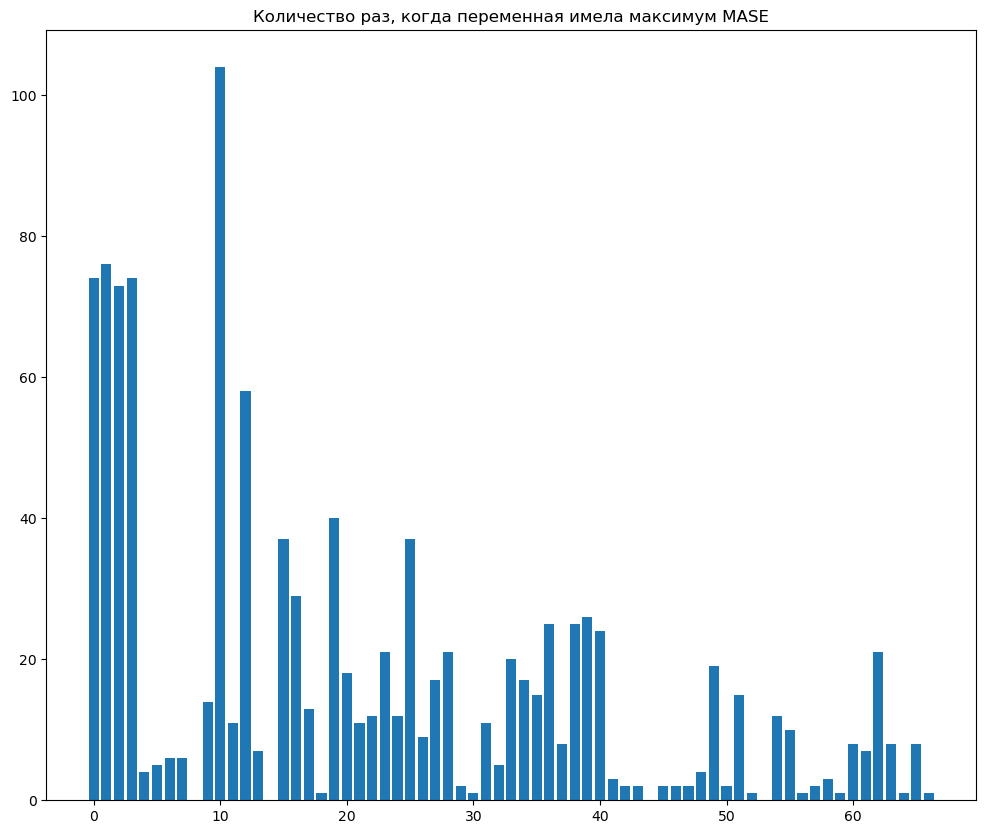

In [33]:
plt.figure(figsize=(12,10))
plt.bar(np.arange(bad_values.shape[0]), bad_values)
plt.title("Количество раз, когда переменная имела максимум MASE")
plt.savefig(f"plots/Dataset2/bad_values.png")
plt.show()

In [114]:
for key, val in maes.items():
    print(key)
    for val_c in val:
        print(f"     {np.where(val_c < 10)}")

(1, 2)
     (array([ 2,  4,  7,  8, 11, 14, 18, 21, 23, 25, 28, 30, 33, 37, 39, 43, 60,
       61, 62, 63, 65]),)
     (array([ 2,  4,  8, 14, 18, 30, 60, 61, 62, 63]),)
(1, 5)
     (array([ 2,  4,  9, 14, 18, 30, 39, 60, 61, 62, 63]),)
     (array([ 2,  4, 14, 18, 30, 60, 61, 62, 63]),)
     (array([ 2,  4,  8,  9, 11, 14, 18, 21, 22, 23, 24, 25, 26, 28, 30, 31, 33,
       39, 48, 50, 53, 60, 61, 62, 63, 65]),)
     (array([ 2,  4,  8, 14, 18, 30, 60, 61, 62, 63]),)
(1, 7)
     (array([ 2,  4,  8, 14, 18, 30, 60, 61, 62, 63]),)
     (array([ 2,  4, 14, 18, 30, 60, 61, 62, 63]),)
     (array([ 2,  4, 12, 14, 18, 28, 30, 60, 61, 62]),)
     (array([ 2,  4, 14, 18, 30, 60, 61, 62]),)
     (array([ 2,  4,  8, 14, 18, 30, 60, 61, 62, 63]),)
     (array([ 2,  4,  8, 11, 14, 18, 20, 21, 22, 23, 25, 26, 28, 30, 33, 37, 39,
       41, 43, 60, 61, 62, 63, 65]),)
     (array([ 2,  4, 14, 18, 30, 60, 61, 62, 63]),)
(1, 9)
     (array([ 2,  4,  9, 14, 18, 30, 60, 61, 62]),)
     (array([ 2,  4, 14

In [115]:
for key, val in mases.items():
    print(key)
    for val_c in val:
        print(f"     {np.where(val_c[0] < 1)}, {np.where(val_c[1] < 1)}")

In [116]:
for key, val in mapes.items():
    print(key)
    for val_c in val:
        print(f"     {np.where(val_c < 1)}")

(1, 2)
     (array([14, 18, 25, 30, 31, 33, 35, 37, 43]),)
     (array([14, 30]),)
(1, 5)
     (array([14, 18, 30]),)
     (array([14]),)
     (array([ 8, 14, 65]),)
     (array([14]),)
(1, 7)
     (array([14, 61]),)
     (array([14]),)
     (array([14, 18, 30, 60]),)
     (array([14]),)
     (array([14, 61, 62]),)
     (array([ 8, 11, 14]),)
     (array([14]),)
(1, 9)
     (array([14]),)
     (array([14]),)
     (array([14]),)
     (array([14, 18, 30]),)
     (array([ 4,  8, 14, 18, 30]),)
     (array([14, 61]),)
     (array([14, 60, 61]),)
(1, 11)
     (array([14]),)
     (array([14, 18, 30]),)
     (array([14]),)
     (array([14, 60, 61]),)
     (array([ 8, 14, 18, 30]),)
     (array([ 8, 14, 65]),)
     (array([14]),)
(3, 2)
     (array([ 4, 14, 18, 30, 31, 33, 35, 37, 42, 62]),)
     (array([14, 30]),)
(3, 5)
     (array([14]),)
     (array([14, 18, 30]),)
     (array([ 8, 14]),)
     (array([14]),)
     (array([14]),)
(3, 7)
     (array([14, 18, 30]),)
     (array([ 8, 14]),)
   